# Code to use all best models for 5 folds and print confusion matrix for each and some inferred images and save!

In [15]:
import numpy as np
import pandas as pd
import torch
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
tqdm.pandas()
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import cv2
import matplotlib
matplotlib.style.use('ggplot')
import albumentations as A
from albumentations.pytorch import ToTensorV2
Image.MAX_IMAGE_PIXELS = None
pd.set_option('display.float_format', '{:.2f}'.format)
import segmentation_models_pytorch as smp
from natsort import natsorted
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [16]:
class model_config:
    start_fold = 1  # start CV fold to train
    total_fold = 5  # total # of folds
    model_name = "resnet50"
    do_TTA = True
    seed = 42  # random seed
    test_batch_size = 8
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# sets the seed of the entire notebook so results are the same every time we run for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)  # numpy specific random
    random.seed(seed)  # python specific random (also for albumentation augmentations)
    torch.manual_seed(seed)  # torch specific random
    torch.cuda.manual_seed(seed)  # cuda specific random
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # when deterministic = true, benchmark = False, otherwise might not be deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)  # set a fixed value for the hash seed, for hashes like dictionary

set_seed(model_config.seed)  # set seed first

In [17]:
test_transforms = A.Compose([ToTensorV2()]) #just convert to tensor

In [18]:
class TestDataSet(Dataset):
    # initialize df, label, imagepath, transforms:
    def __init__(self, image_paths: list, mask_paths: list, transforms=None, label=True):
        self.label = label
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    # define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        if self.label:
            mask_path = self.mask_paths[idx]
            mask = cv2.imread(mask_path, 0)
            mask = np.array(mask)
            mask[mask == 13] = 0
        if self.transforms is not None:  # albumentations
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.unsqueeze(0)  # dtypes: image = torch.uin8, mask = torch.uint8
        return image, mask  # return tensors of equal dtype and size
        # image is size 3x1024x1024 and mask is size 1x1024x1024 (need dummy dimension to match dimension)

In [19]:
# define dataloading function to use above dataset to return train and val dataloaders:
def load_test_dataset():
    test_dataset = TestDataSet(image_paths=test_images, mask_paths=test_labels, transforms=test_transforms)
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=model_config.test_batch_size,
                                num_workers=0, pin_memory=True, shuffle=False)
    return test_dataloader # return train and val dataloaders

In [20]:
# Define test image and test label paths:
data_src = r"\\10.99.68.178\kyuex\image\skin_aging\deeplab_trainingset"
fold_dir = r"v11_fold{}".format(model_config.start_fold)
image_path = os.path.join(data_src, fold_dir)
test_dir = os.path.join(image_path, "validation")
test_image_dir = os.path.join(test_dir, "im")
test_label_dir = os.path.join(test_dir, 'label')
test_images = natsorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith(".png")])
test_labels = natsorted([os.path.join(test_label_dir, x) for x in os.listdir(test_label_dir) if x.endswith(".png")])
test_dataloader = load_test_dataset()  # load datasets

In [21]:
# test to see if dataloaders return desired batch size and visualize images to see if images are indeed transformed:
test_dataloader = load_test_dataset()
images, labels = next(iter(test_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))

Images have a tensor size of torch.Size([8, 3, 1024, 1024]), and Labels have a tensor size of torch.Size([8, 1, 1024, 1024])


In [22]:
def build_model():
    model = smp.DeepLabV3Plus(encoder_name=model_config.model_name, encoder_weights=None, encoder_depth=5,
                              decoder_channels=512, activation=None,
                              in_channels=3, classes=13)
    model.to(model_config.device)  # move model to gpu
    return model

In [23]:
def perform_TTA(x: torch.Tensor, model):
    shape = x.shape #must be BCHW
    x = [x, *[torch.rot90(x, k=i, dims=(-2, -1)) for i in range(1, 4)]]
    x = torch.cat(x, dim=0)
    x = model(x)
    x = x.reshape(4, shape[0], 13, *shape[-2:]) # 4 = three different rotations + original image, 13 = # of classes (y_pred)
    x = [torch.rot90(x[i], k=-i, dims=(-2, -1)) for i in range(4)]
    x = torch.stack(x, dim=0)
    return x.mean(0)

In [24]:
def calculate_f1_score_conf_matrix(y_pred: torch.Tensor, y_true: torch.Tensor):  # y_pred in probabilities
    y_pred = y_pred.cpu().numpy().flatten()  # 1d numpy array
    y_true = y_true.cpu().numpy().flatten()  # 1d numpy array
    f1_score_result = f1_score(y_pred, y_true, average="weighted")
    conf_matrix = confusion_matrix(y_true,y_pred)

    return f1_score_result, conf_matrix

In [25]:
@torch.no_grad() #decorator to disable gradient calc
def run_inference(model, dataloader, device, fold, TTA: bool, weight_dir):
    valid_f1_history, y_true_list, y_pred_list = [],[],[]
    conf_matrix_total = np.zeros((13,13),dtype=int)
    model_path = os.path.join(weight_dir,"best_epoch-0{}.pt".format(fold))
    model.load_state_dict(torch.load(model_path)) #load model weights
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Inference', colour='red')
    for idx, (images,masks) in pbar:
        model.eval() # eval stage
        images = images.to(device, dtype=torch.float)  #move tensor to gpu
        masks = masks.to(device, dtype=torch.int64)  #move tensor to gpu
        if TTA:
            prediction = perform_TTA(images,model)
        else:
            prediction = model(images)
        masks = masks.squeeze(1)  # N x 1024 x 1024
        y_pred = torch.argmax(prediction, dim=1)  # get most likely class by applying argmax to logit y_pred (same as applying sigmoid), N x 13 x 1024 x 1024 -> N x 1 x 1024 x 1024
        y_pred = y_pred.squeeze(1)  # N x 1024 x 1024
        # get 13 x 13 conf matrix
        valid_f1, conf_matrix = calculate_f1_score_conf_matrix(y_pred, masks)  # find f1 score
        y_true_list.append(masks.cpu().numpy().flatten())
        y_pred_list.append(y_pred.cpu().numpy().flatten())
        valid_f1_history.append(valid_f1)
        conf_matrix_total += conf_matrix
    valid_f1_history = np.mean(valid_f1_history,
                                        axis=0)
    return valid_f1_history, conf_matrix_total,y_true_list,y_pred_list

### Code until above is the same, but the actual inference code is slightly different for below now:

### Below is inference on each fold with TTA:

Running Inference for Fold 1


Inference: 100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


Valid F1 Score for fold1 is : 0.9146462614449372
              precision  recall  f1-score     support
background         0.99    1.00      0.99 20448735.00
corneum            0.90    0.88      0.89  1625646.00
spinosum           0.91    0.92      0.91  1610949.00
hairshaft          0.92    0.87      0.89  1555060.00
hairfollicle       0.90    0.84      0.87  2236595.00
smoothmuscle       0.82    0.65      0.72  1725615.00
oil                0.93    0.93      0.93  1841226.00
sweat              0.85    0.81      0.83  1733896.00
nerve              0.96    0.74      0.83  1571381.00
bloodvessel        0.86    0.61      0.71  1747577.00
ecm                0.82    0.94      0.88 11149088.00
fat                0.83    0.80      0.81  1605810.00
white              0.87    0.80      0.83  1480070.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.89    0.83      0.85 50331648.00
weighted avg       0.91    0.91      0.91 50331648.00
Running Inference for Fold 2


Inference: 100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


Valid F1 Score for fold2 is : 0.9162683047963481
              precision  recall  f1-score     support
background         0.99    1.00      0.99 20443050.00
corneum            0.88    0.88      0.88  1717392.00
spinosum           0.89    0.92      0.90  1778946.00
hairshaft          0.93    0.83      0.88  1672455.00
hairfollicle       0.89    0.84      0.87  2193227.00
smoothmuscle       0.80    0.75      0.77  1839449.00
oil                0.91    0.92      0.91  1473369.00
sweat              0.90    0.81      0.85  1837889.00
nerve              0.95    0.79      0.86  1521205.00
bloodvessel        0.82    0.71      0.76  1720911.00
ecm                0.84    0.93      0.88 10521526.00
fat                0.82    0.83      0.82  1792178.00
white              0.87    0.78      0.82  1820051.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.88    0.85      0.86 50331648.00
weighted avg       0.92    0.92      0.91 50331648.00
Running Inference for Fold 3


Inference: 100%|██████████| 6/6 [00:36<00:00,  6.05s/it]


Valid F1 Score for fold3 is : 0.9107898815530596
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19558190.00
corneum            0.93    0.89      0.91  2061052.00
spinosum           0.89    0.90      0.90  1813422.00
hairshaft          0.93    0.80      0.86  1870024.00
hairfollicle       0.87    0.84      0.85  2300474.00
smoothmuscle       0.85    0.64      0.73  1879365.00
oil                0.95    0.89      0.92  1822049.00
sweat              0.83    0.85      0.84  1718007.00
nerve              0.93    0.81      0.86  1599669.00
bloodvessel        0.85    0.67      0.75  1890150.00
ecm                0.81    0.94      0.87  9950966.00
fat                0.80    0.88      0.84  1839593.00
white              0.91    0.80      0.85  2028687.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.89    0.84      0.86 50331648.00
weighted avg       0.91    0.91      0.91 50331648.00
Running Inference for Fold 4


Inference: 100%|██████████| 6/6 [00:35<00:00,  5.94s/it]


Valid F1 Score for fold4 is : 0.9088800769048051
              precision  recall  f1-score     support
background         0.99    1.00      0.99 19910261.00
corneum            0.92    0.86      0.88  1940033.00
spinosum           0.86    0.90      0.88  1823206.00
hairshaft          0.91    0.78      0.84  1652409.00
hairfollicle       0.89    0.82      0.85  2127411.00
smoothmuscle       0.82    0.68      0.74  1815789.00
oil                0.93    0.93      0.93  1909185.00
sweat              0.87    0.82      0.84  1773378.00
nerve              0.93    0.82      0.87  1585437.00
bloodvessel        0.84    0.67      0.75  1779307.00
ecm                0.83    0.93      0.87 10576403.00
fat                0.77    0.81      0.79  1658742.00
white              0.82    0.80      0.81  1780087.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.88    0.83      0.85 50331648.00
weighted avg       0.91    0.91      0.91 50331648.00
Running Inference for Fold 5


Inference: 100%|██████████| 6/6 [00:36<00:00,  6.05s/it]


Valid F1 Score for fold5 is : 0.9079966190930948
              precision  recall  f1-score     support
background         0.99    1.00      0.99 19579425.00
corneum            0.89    0.88      0.89  2041265.00
spinosum           0.91    0.87      0.89  1975690.00
hairshaft          0.90    0.83      0.87  1854423.00
hairfollicle       0.87    0.83      0.85  2560328.00
smoothmuscle       0.81    0.65      0.72  1722520.00
oil                0.88    0.94      0.91  1709972.00
sweat              0.81    0.80      0.80  1783783.00
nerve              0.94    0.80      0.86  1584420.00
bloodvessel        0.85    0.64      0.73  1735745.00
ecm                0.82    0.93      0.87  9973606.00
fat                0.83    0.84      0.83  1821976.00
white              0.90    0.80      0.85  1988495.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.88    0.83      0.85 50331648.00
weighted avg       0.91    0.91      0.91 50331648.00


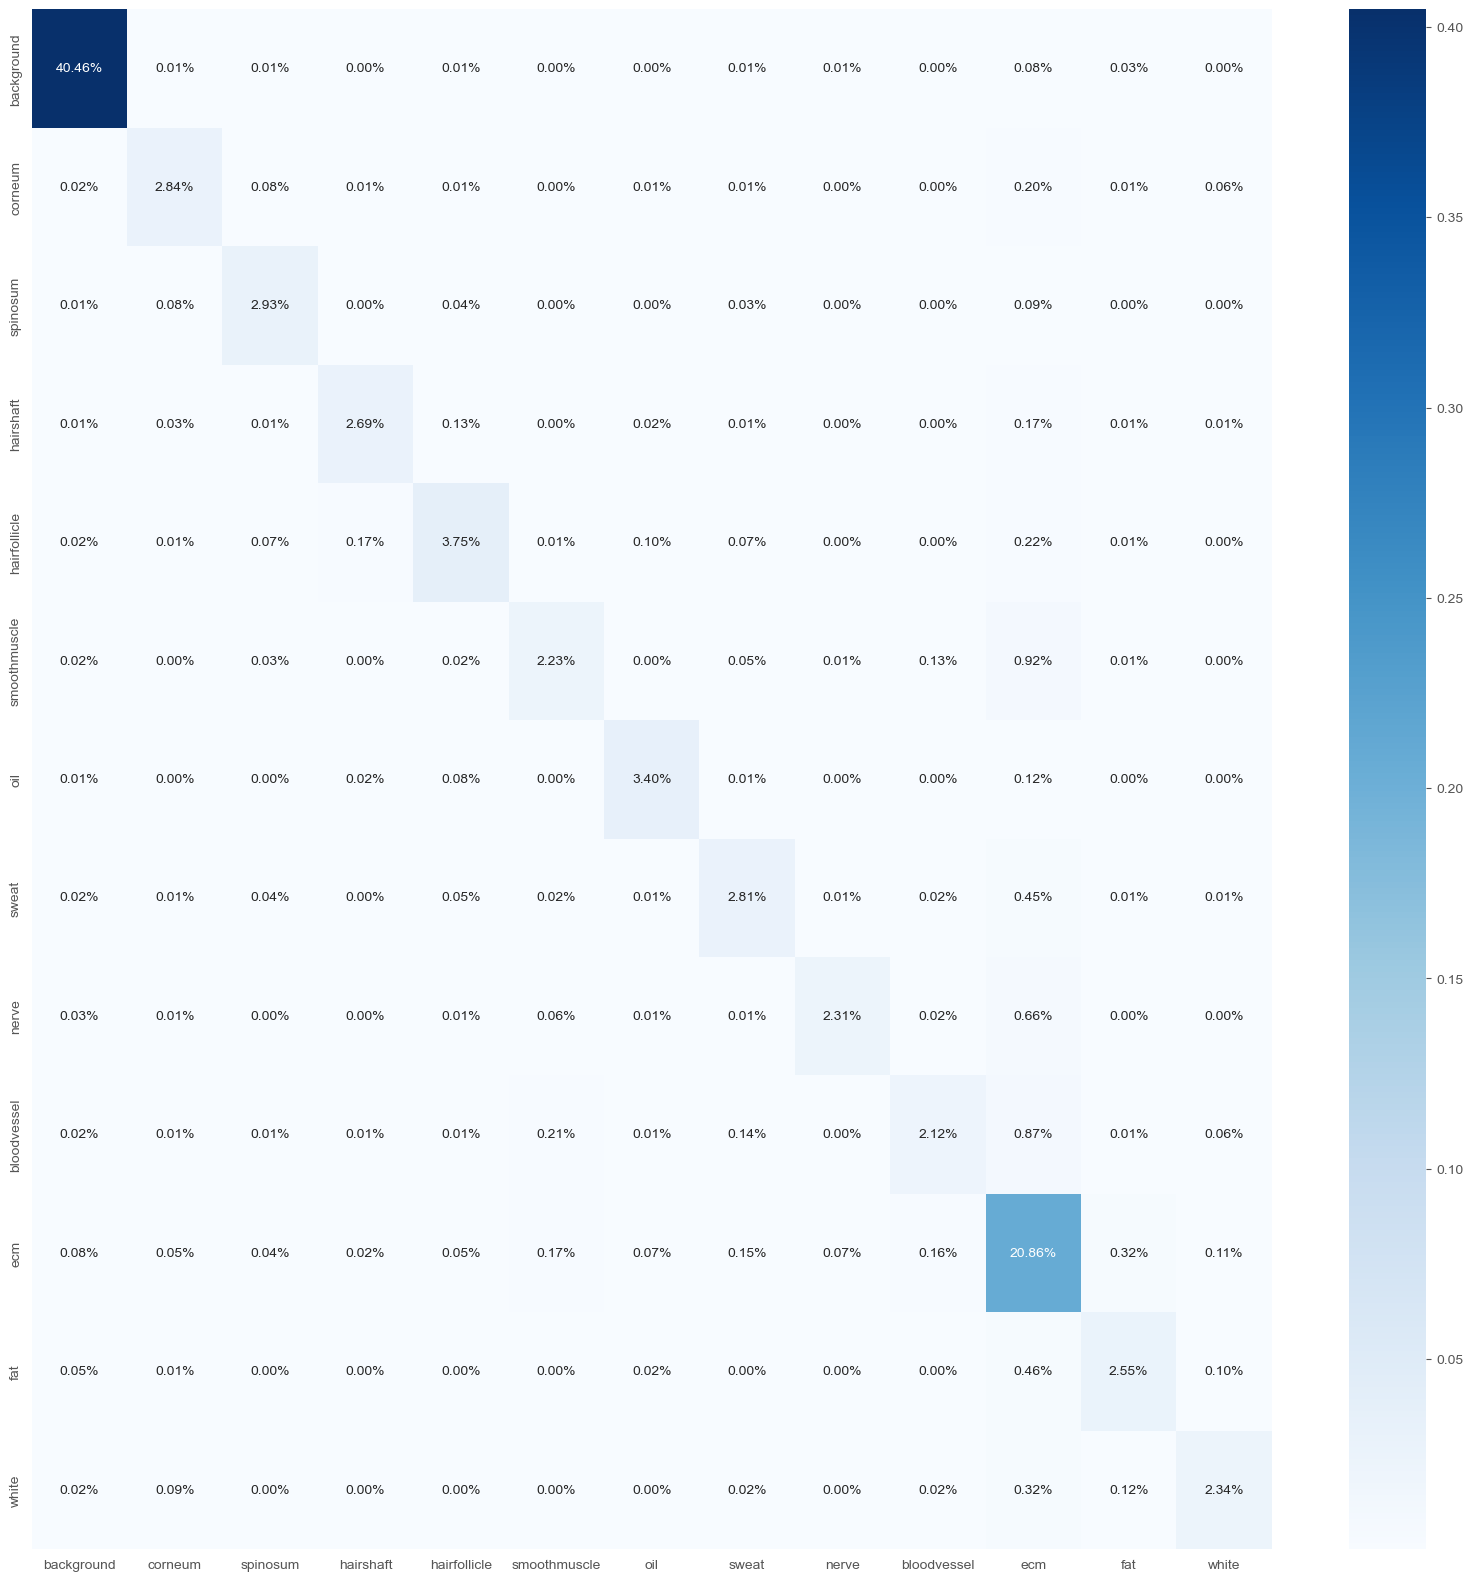

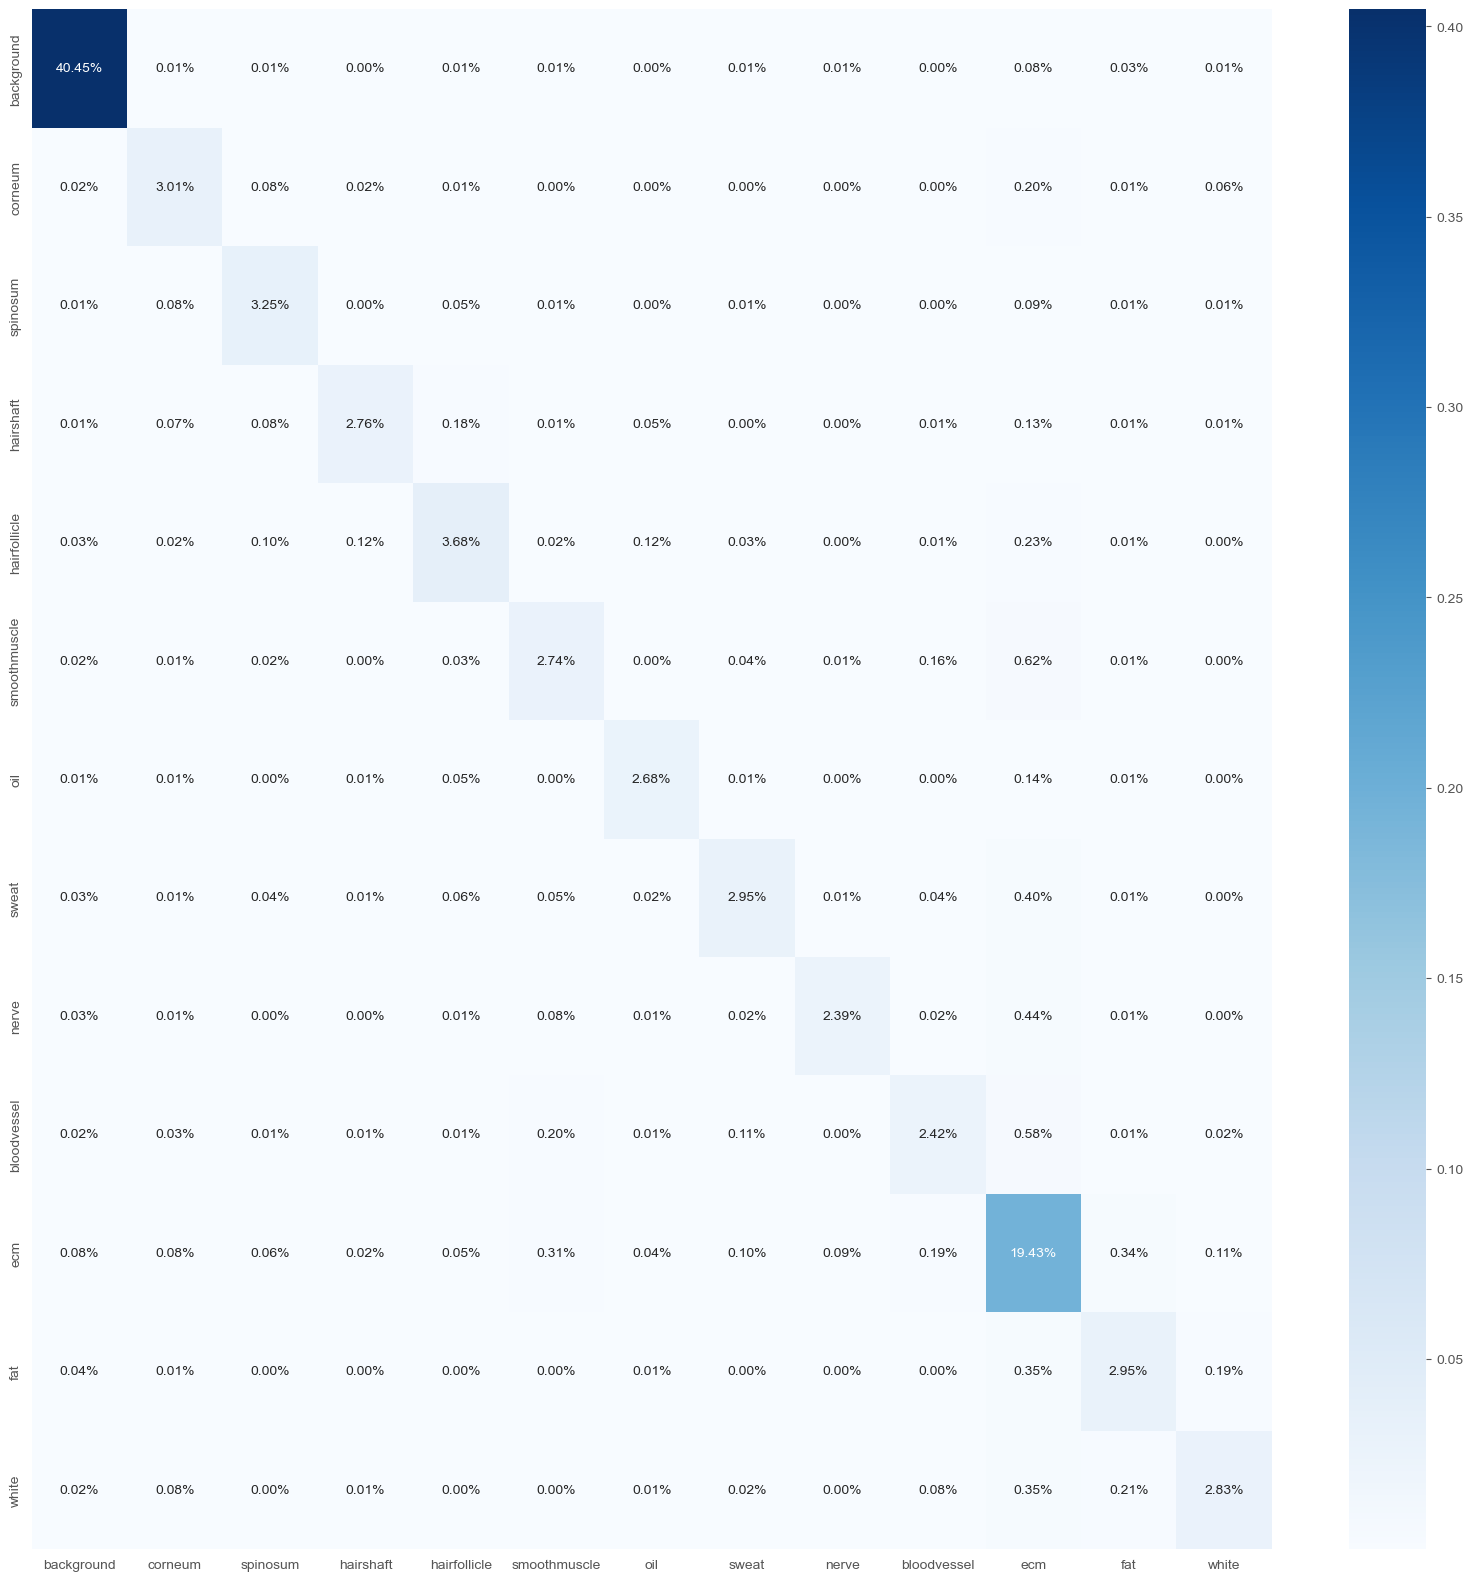

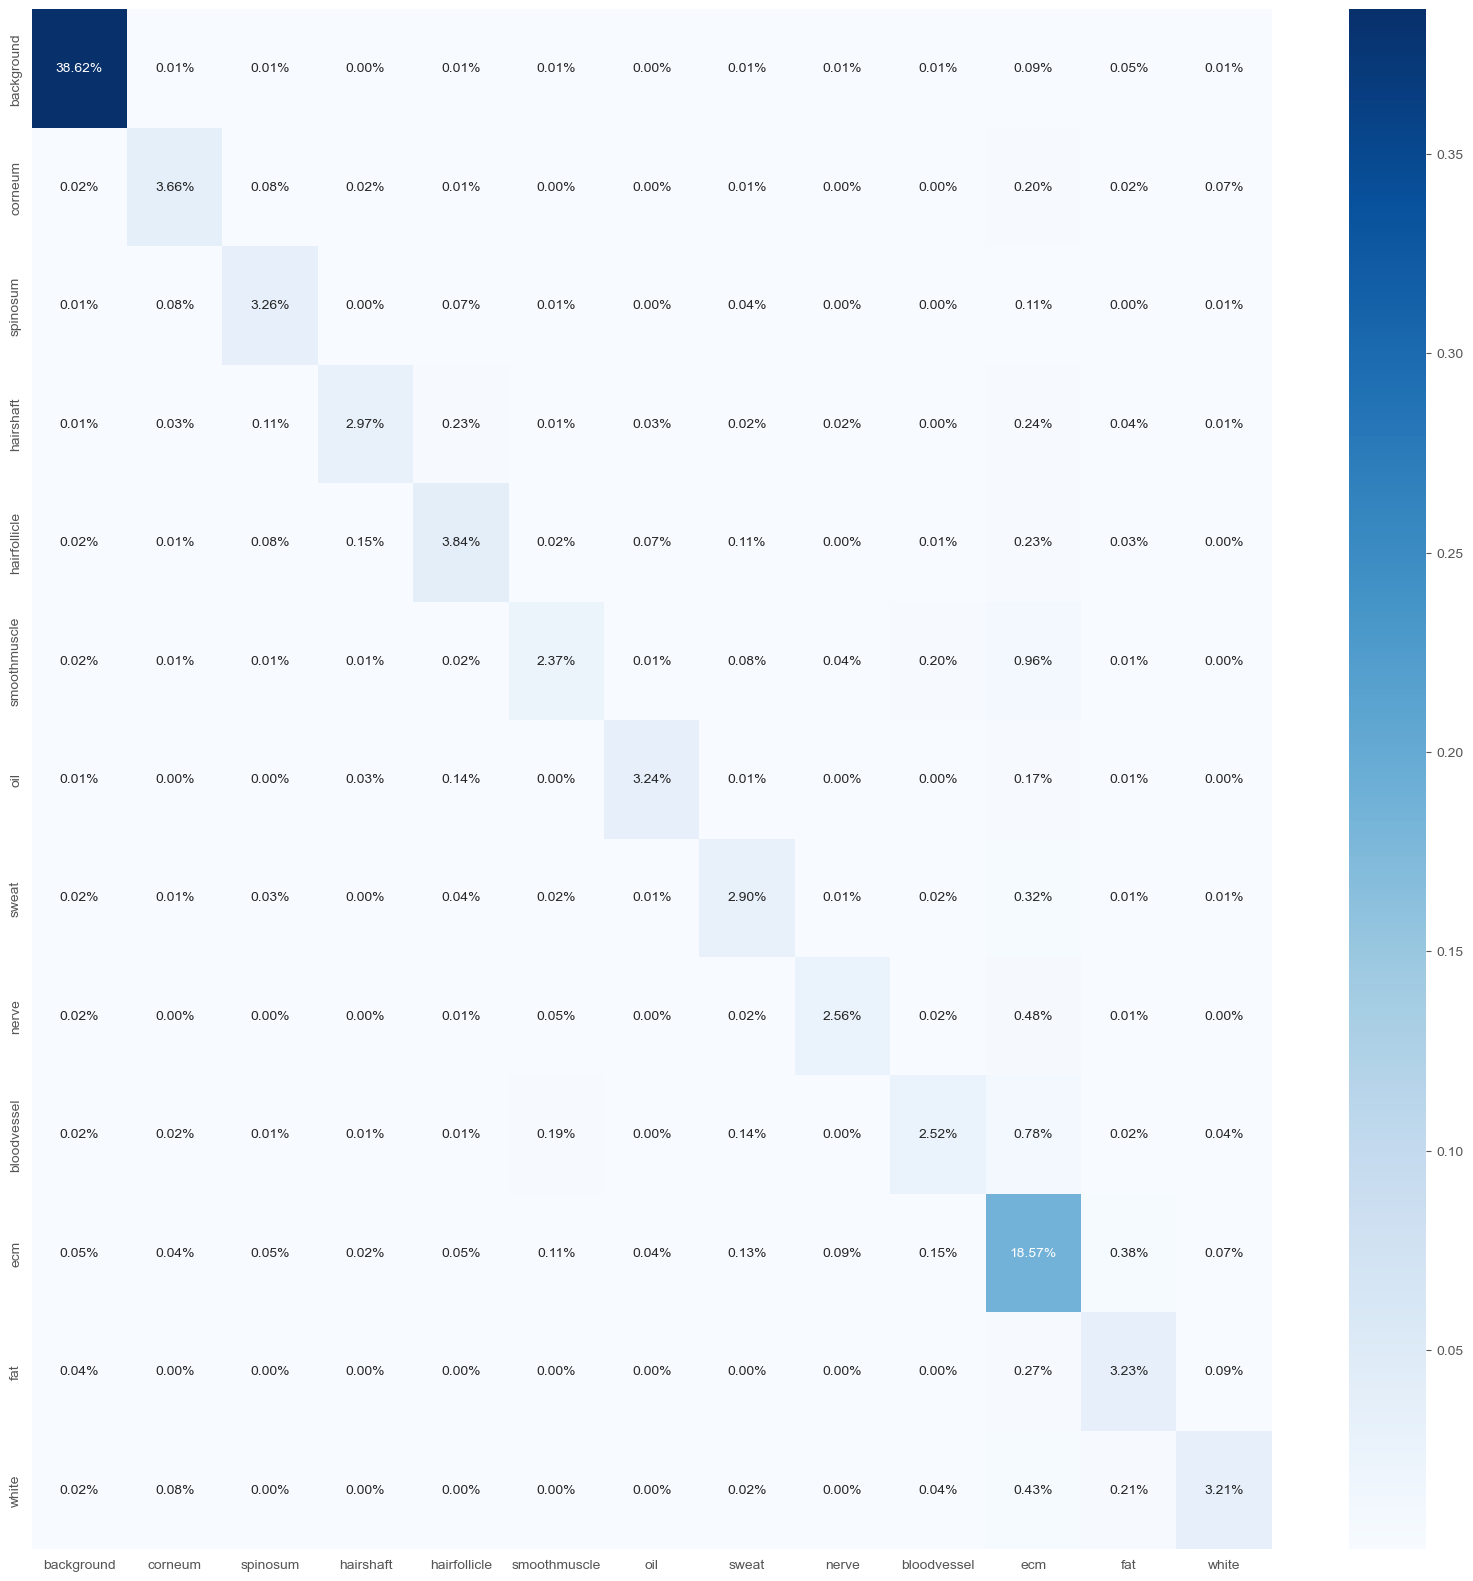

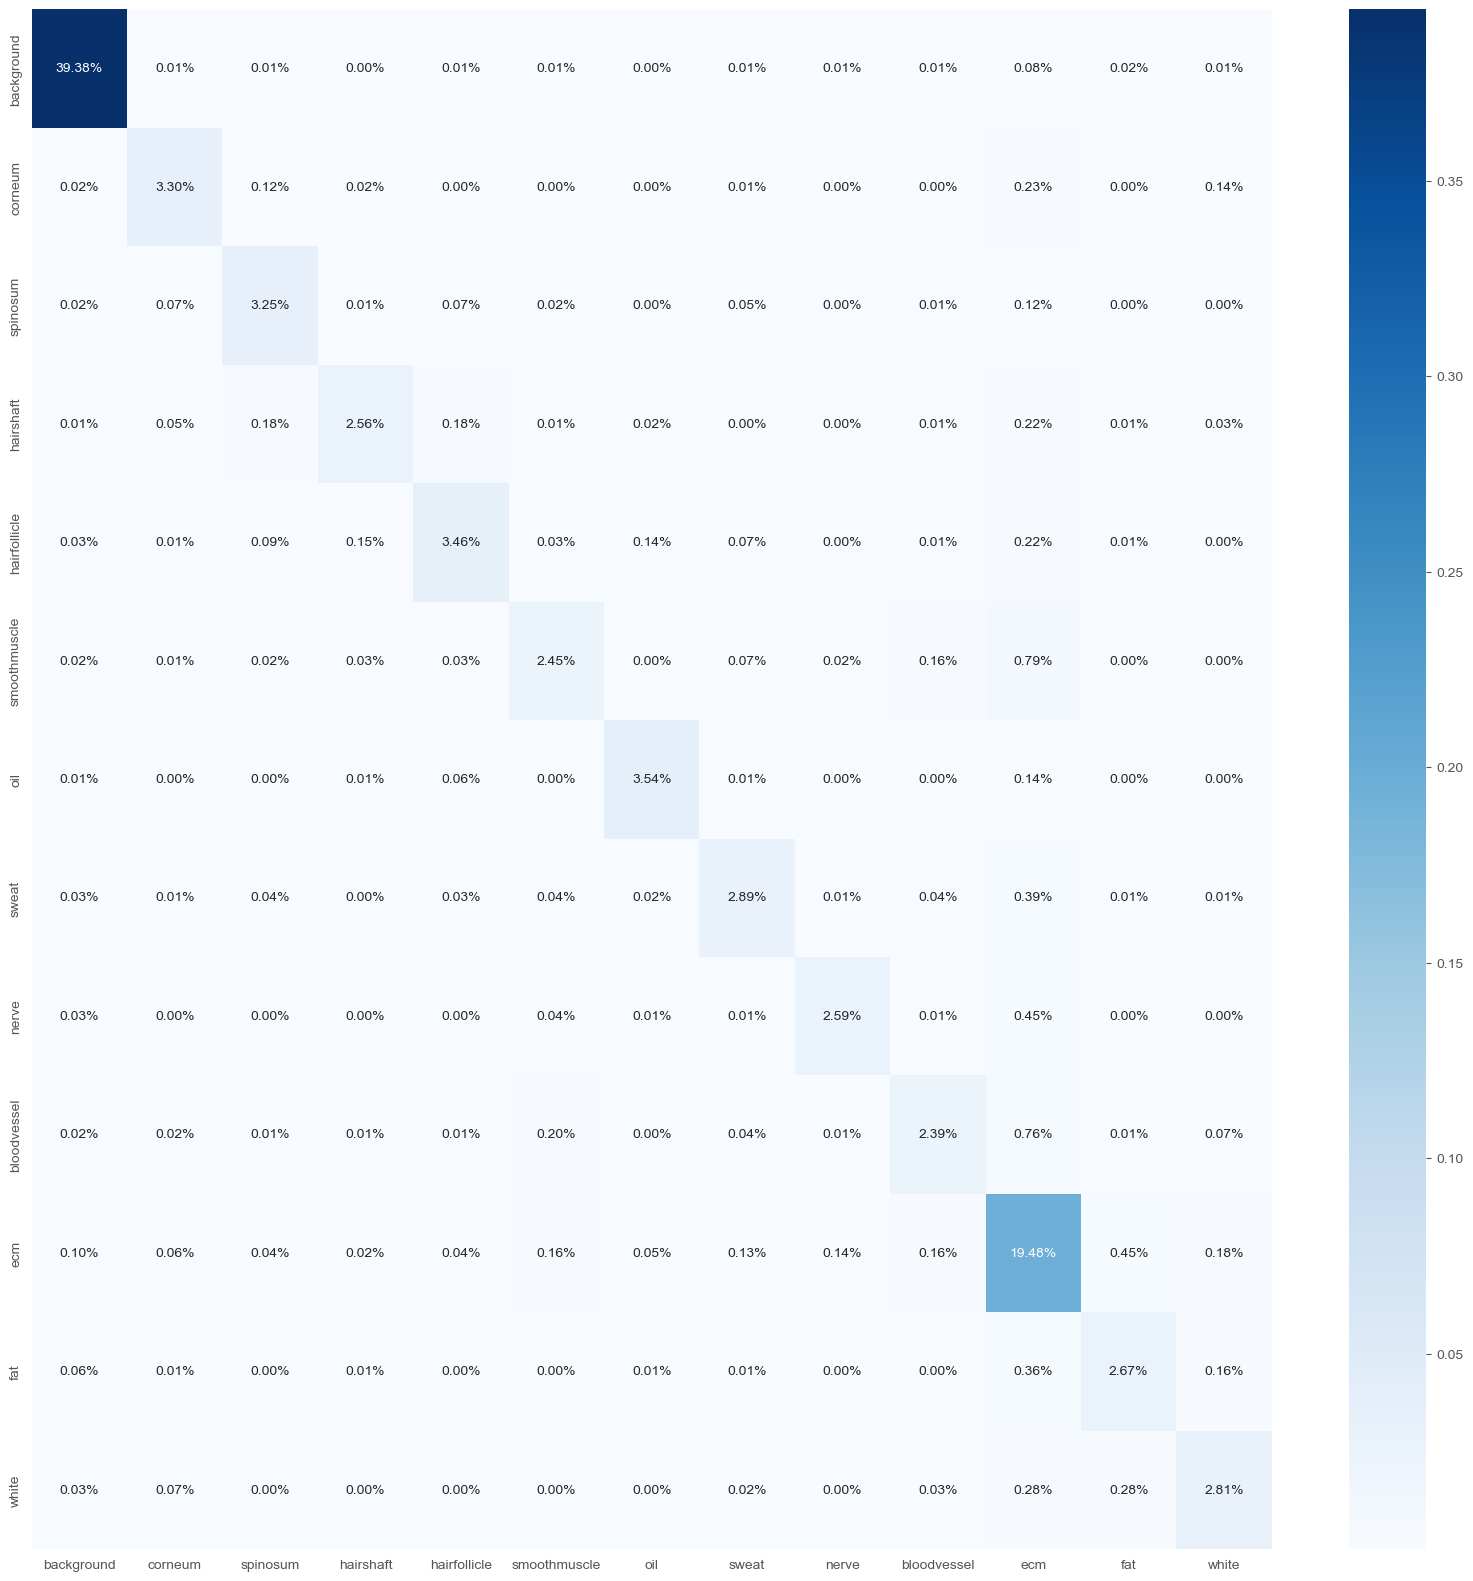

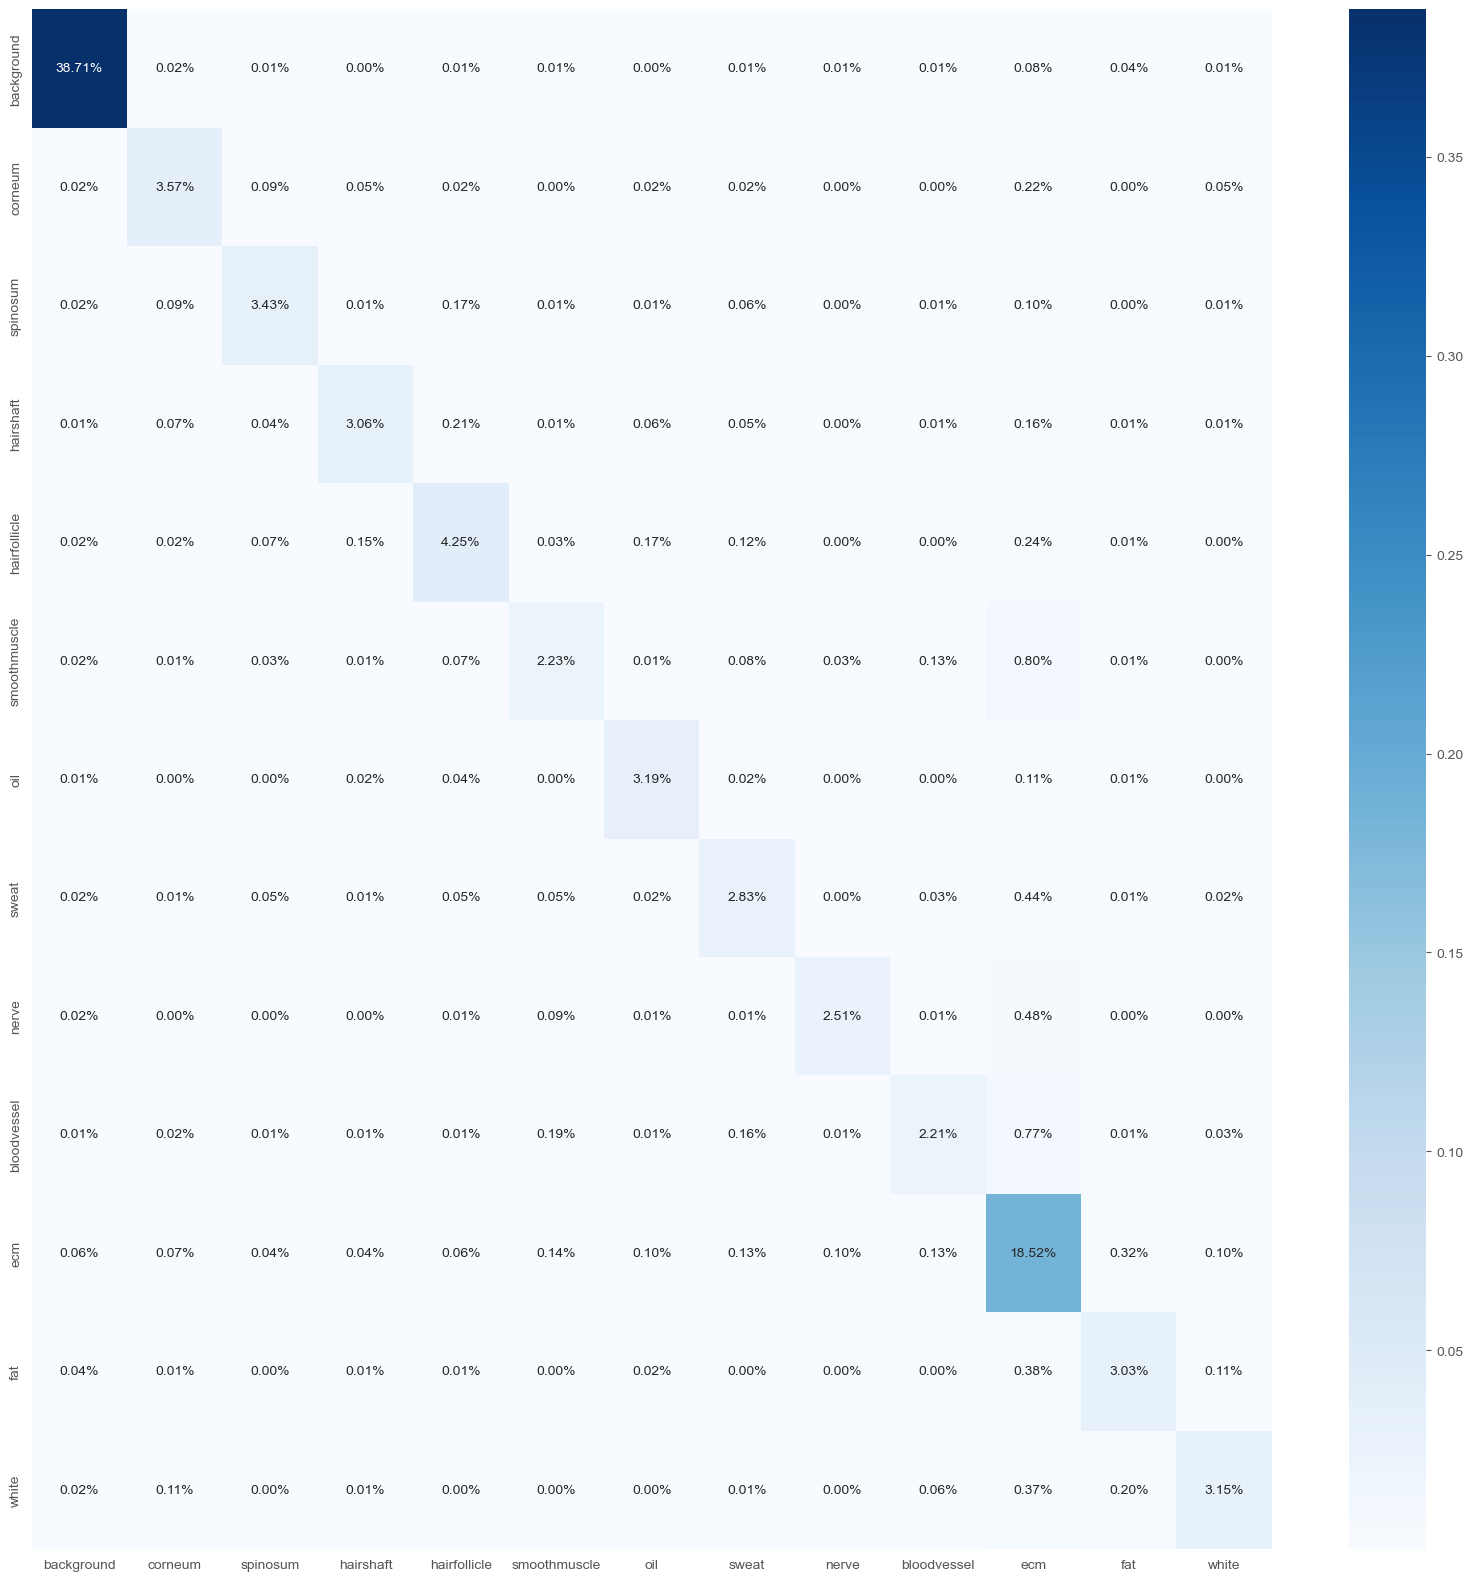

In [12]:
# finally run inference:
data_src = r"\\10.99.68.178\kyuex\image\skin_aging\deeplab_trainingset"
model_weight_dir = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet101"
start_fold = model_config.start_fold
do_TTA = model_config.do_TTA
class_list = list(['background','corneum','spinosum','hairshaft','hairfollicle','smoothmuscle','oil','sweat','nerve','bloodvessel','ecm','fat','white'])
# repeat for all number of folds:
for fold in range(0, model_config.total_fold):
    current_fold = start_fold + fold
    fold_dir = r"v11_fold{}".format(current_fold)
    image_path = os.path.join(data_src, fold_dir)
    test_dir = os.path.join(image_path, "validation")
    test_image_dir = os.path.join(test_dir, "im")
    test_label_dir = os.path.join(test_dir, 'label')
    test_images = natsorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith(".png")])
    test_labels = natsorted([os.path.join(test_label_dir, x) for x in os.listdir(test_label_dir) if x.endswith(".png")])
    test_dataloader = load_test_dataset()  # load datasets
    model = build_model()  # build model
    # print(model)
    print("Running Inference for Fold {}".format(current_fold))
    valid_f1_score, conf_matrix_total,y_true_list, y_pred_list = run_inference(model,test_dataloader,model_config.device,current_fold,do_TTA,model_weight_dir)
    print("Valid F1 Score for fold{} is : {}".format(current_fold,valid_f1_score))

    fig, ax = plt.subplots(figsize=(20,20))
    plot = sns.heatmap(conf_matrix_total/np.sum(conf_matrix_total),annot=True, fmt = '.2%', cmap = 'Blues', ax = ax, xticklabels=class_list, yticklabels=class_list)
    save_path = os.path.join(model_weight_dir,"confusion_matrix")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,"confusion_matrix_fold{}.png".format(current_fold)))
    y_true_list = [x for y in y_true_list for x in y]
    y_pred_list = [x for y in y_pred_list for x in y]
    classification_rep = classification_report(y_true_list, y_pred_list, target_names=class_list, output_dict=True)
    df = pd.DataFrame(classification_rep).transpose()
    print(df)

### Below is inference on each fold without TTA:

Running Inference for Fold 1


Inference: 100%|██████████| 6/6 [00:19<00:00,  3.25s/it]


Valid F1 Score for fold1 is : 0.9237743666639037
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20448735.00
corneum            0.89    0.88      0.89  1625646.00
spinosum           0.90    0.92      0.91  1610949.00
hairshaft          0.90    0.91      0.91  1555060.00
hairfollicle       0.89    0.86      0.87  2236595.00
smoothmuscle       0.82    0.76      0.79  1725615.00
oil                0.92    0.93      0.92  1841226.00
sweat              0.88    0.84      0.86  1733896.00
nerve              0.94    0.82      0.87  1571381.00
bloodvessel        0.86    0.76      0.81  1747577.00
ecm                0.87    0.93      0.89 11149088.00
fat                0.81    0.80      0.81  1605810.00
white              0.85    0.80      0.82  1480070.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.86      0.87 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 2


Inference: 100%|██████████| 6/6 [00:18<00:00,  3.14s/it]


Valid F1 Score for fold2 is : 0.9215938463145777
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20443050.00
corneum            0.88    0.89      0.88  1717392.00
spinosum           0.91    0.91      0.91  1778946.00
hairshaft          0.91    0.90      0.90  1672455.00
hairfollicle       0.88    0.86      0.87  2193227.00
smoothmuscle       0.80    0.81      0.80  1839449.00
oil                0.90    0.91      0.91  1473369.00
sweat              0.91    0.82      0.86  1837889.00
nerve              0.93    0.84      0.88  1521205.00
bloodvessel        0.82    0.79      0.80  1720911.00
ecm                0.87    0.91      0.89 10521526.00
fat                0.82    0.82      0.82  1792178.00
white              0.86    0.80      0.83  1820051.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.88    0.87      0.87 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 3


Inference: 100%|██████████| 6/6 [00:21<00:00,  3.51s/it]


Valid F1 Score for fold3 is : 0.9189442635675605
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19558190.00
corneum            0.92    0.89      0.90  2061052.00
spinosum           0.90    0.91      0.90  1813422.00
hairshaft          0.91    0.86      0.89  1870024.00
hairfollicle       0.87    0.85      0.86  2300474.00
smoothmuscle       0.85    0.72      0.78  1879365.00
oil                0.94    0.90      0.92  1822049.00
sweat              0.86    0.87      0.86  1718007.00
nerve              0.92    0.86      0.89  1599669.00
bloodvessel        0.85    0.76      0.80  1890150.00
ecm                0.85    0.93      0.89  9950966.00
fat                0.80    0.88      0.84  1839593.00
white              0.91    0.81      0.85  2028687.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.86      0.88 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 4


Inference: 100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


Valid F1 Score for fold4 is : 0.916935752867151
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19910261.00
corneum            0.91    0.86      0.88  1940033.00
spinosum           0.91    0.89      0.90  1823206.00
hairshaft          0.90    0.89      0.89  1652409.00
hairfollicle       0.89    0.84      0.86  2127411.00
smoothmuscle       0.83    0.78      0.80  1815789.00
oil                0.93    0.93      0.93  1909185.00
sweat              0.87    0.83      0.85  1773378.00
nerve              0.91    0.86      0.89  1585437.00
bloodvessel        0.84    0.75      0.79  1779307.00
ecm                0.86    0.91      0.89 10576403.00
fat                0.76    0.81      0.78  1658742.00
white              0.82    0.79      0.81  1780087.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.88    0.86      0.87 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 5


Inference: 100%|██████████| 6/6 [00:18<00:00,  3.08s/it]


Valid F1 Score for fold5 is : 0.9140365457008134
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19579425.00
corneum            0.90    0.88      0.89  2041265.00
spinosum           0.90    0.88      0.89  1975690.00
hairshaft          0.90    0.85      0.87  1854423.00
hairfollicle       0.86    0.84      0.85  2560328.00
smoothmuscle       0.82    0.74      0.78  1722520.00
oil                0.88    0.93      0.90  1709972.00
sweat              0.83    0.82      0.83  1783783.00
nerve              0.91    0.85      0.88  1584420.00
bloodvessel        0.85    0.75      0.79  1735745.00
ecm                0.85    0.92      0.88  9973606.00
fat                0.83    0.84      0.83  1821976.00
white              0.89    0.80      0.85  1988495.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.88    0.85      0.86 50331648.00
weighted avg       0.91    0.91      0.91 50331648.00


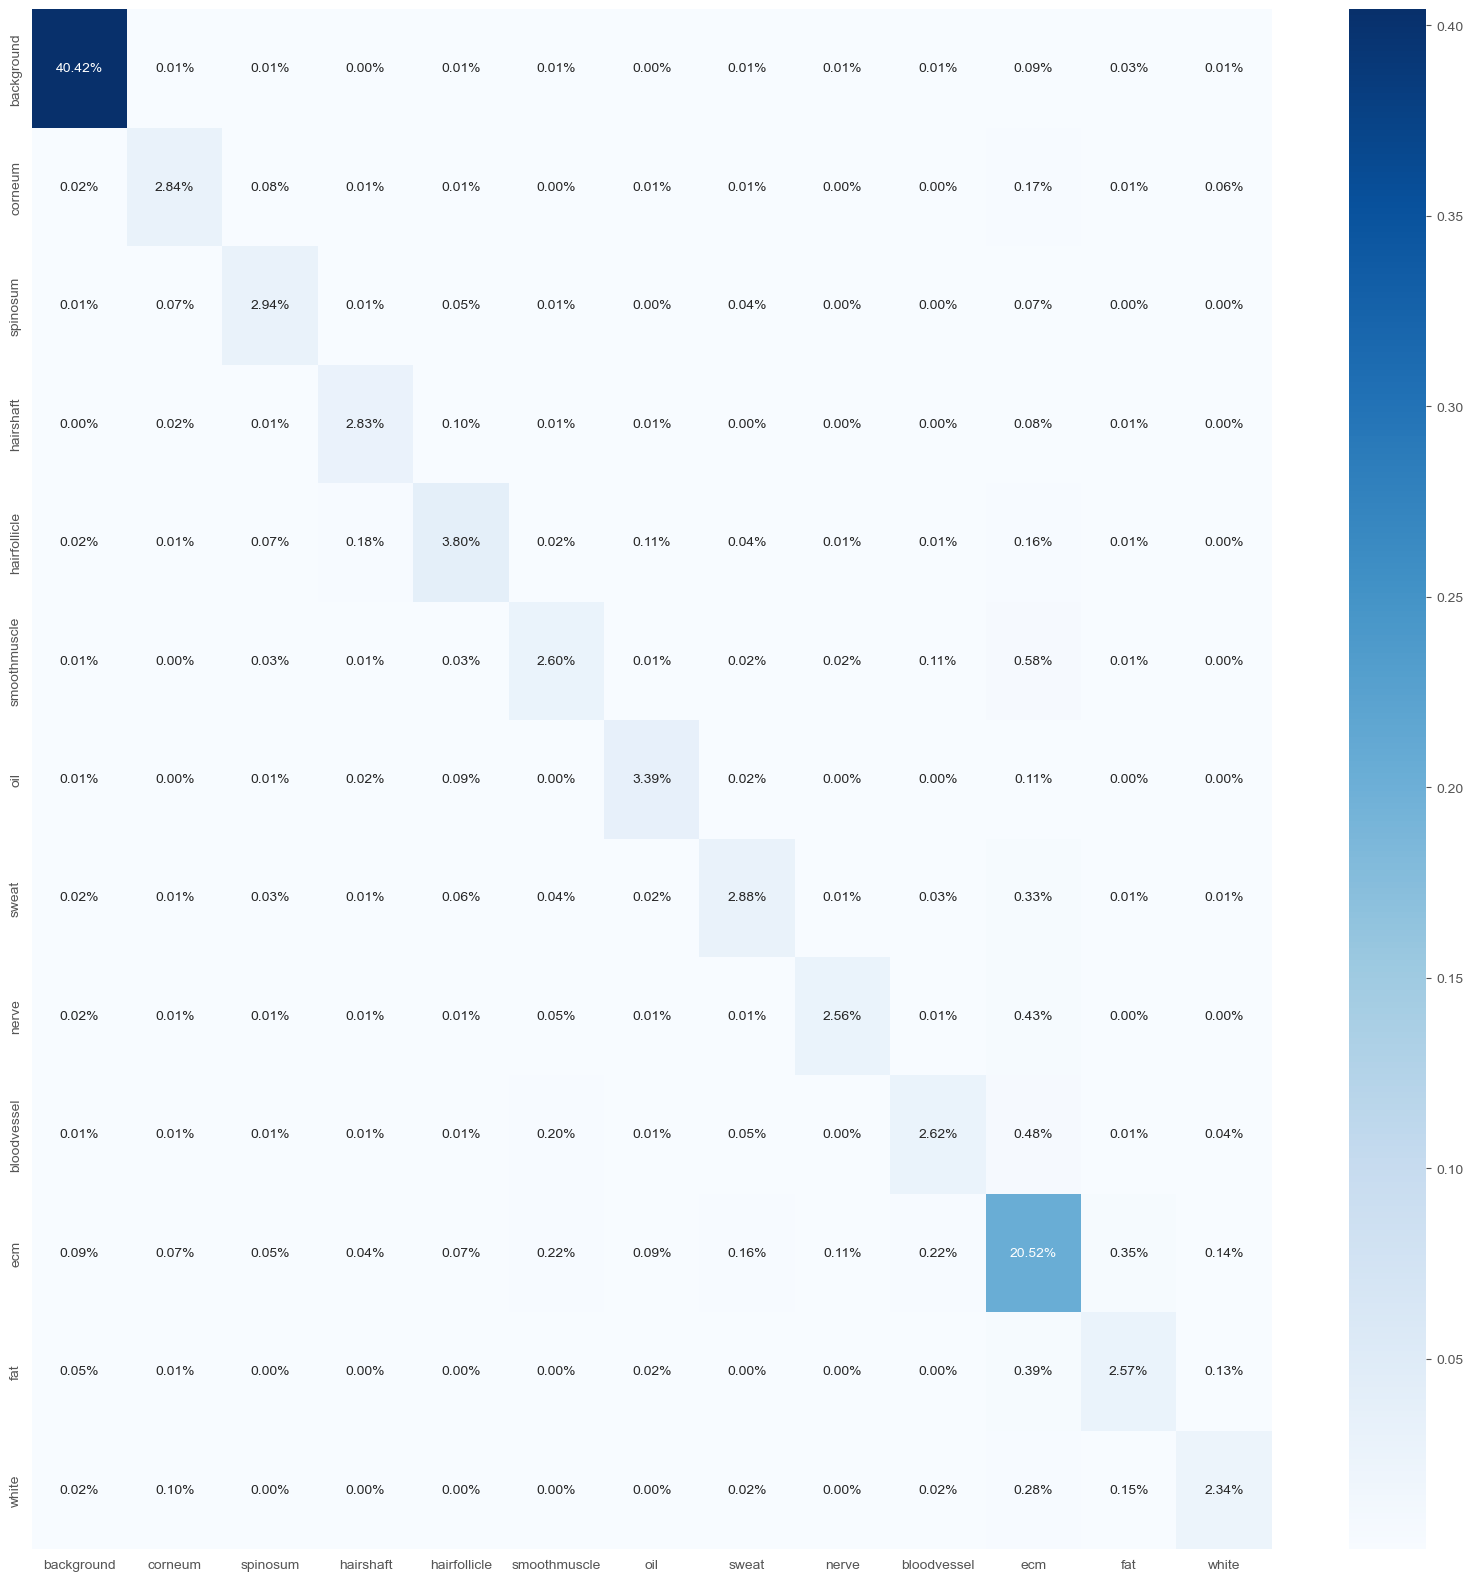

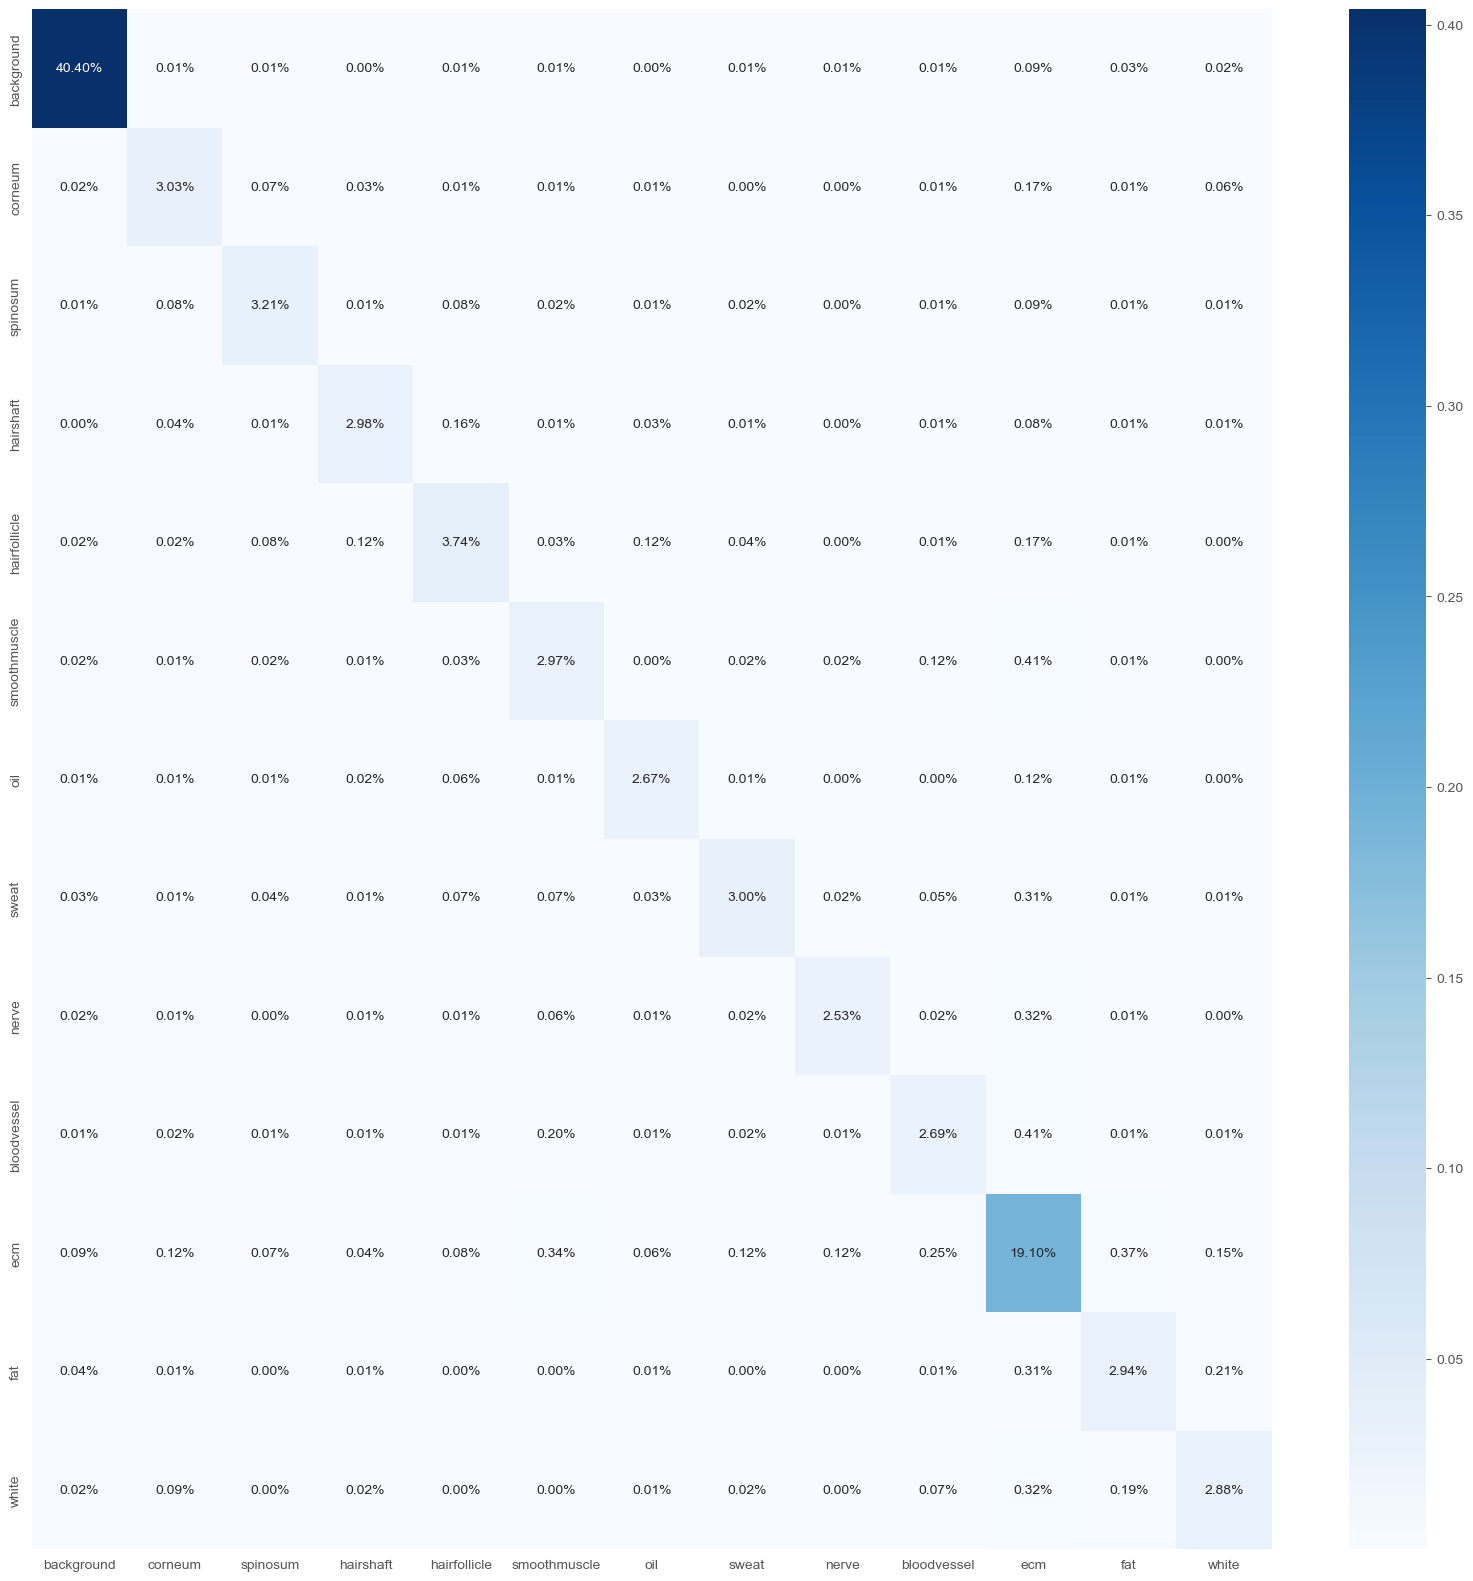

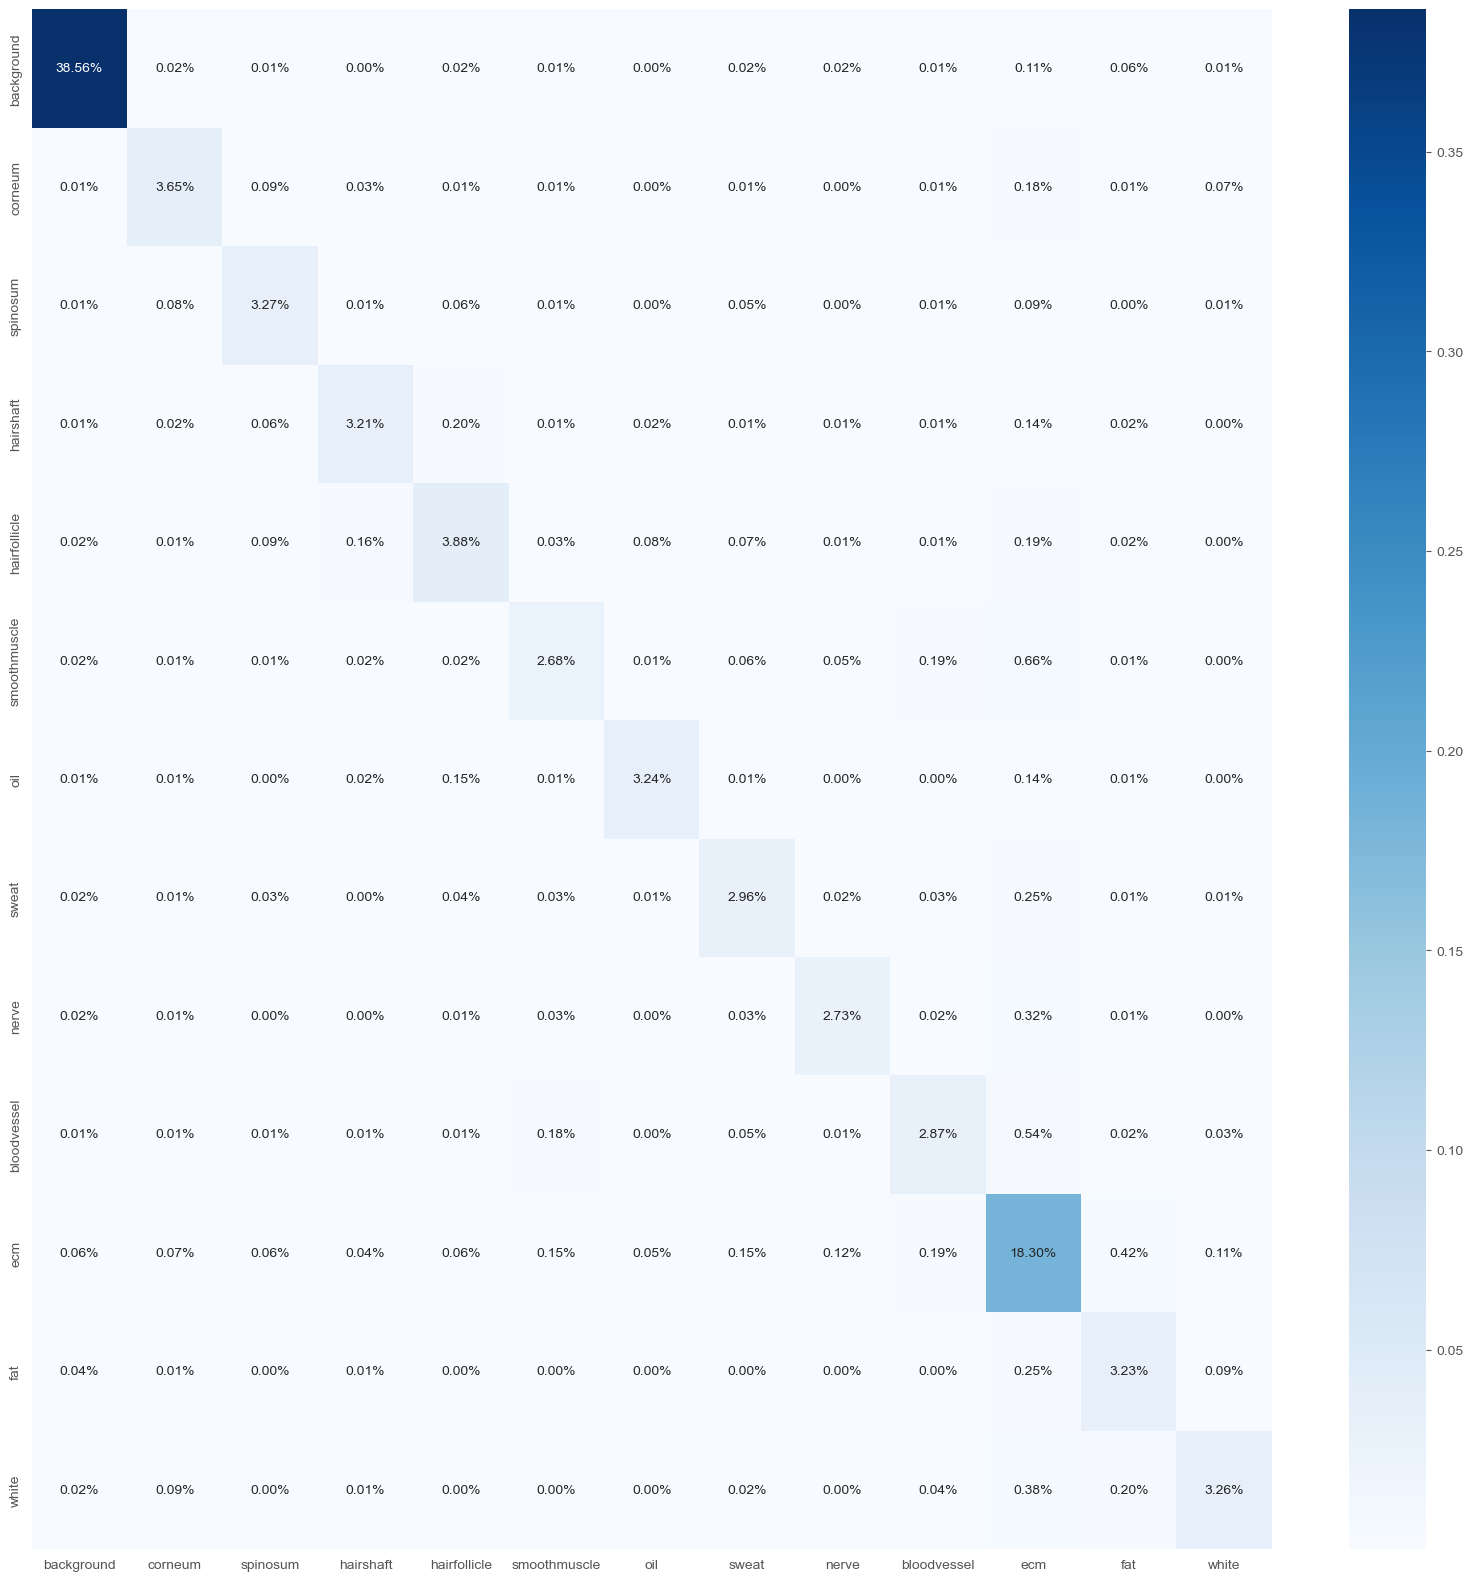

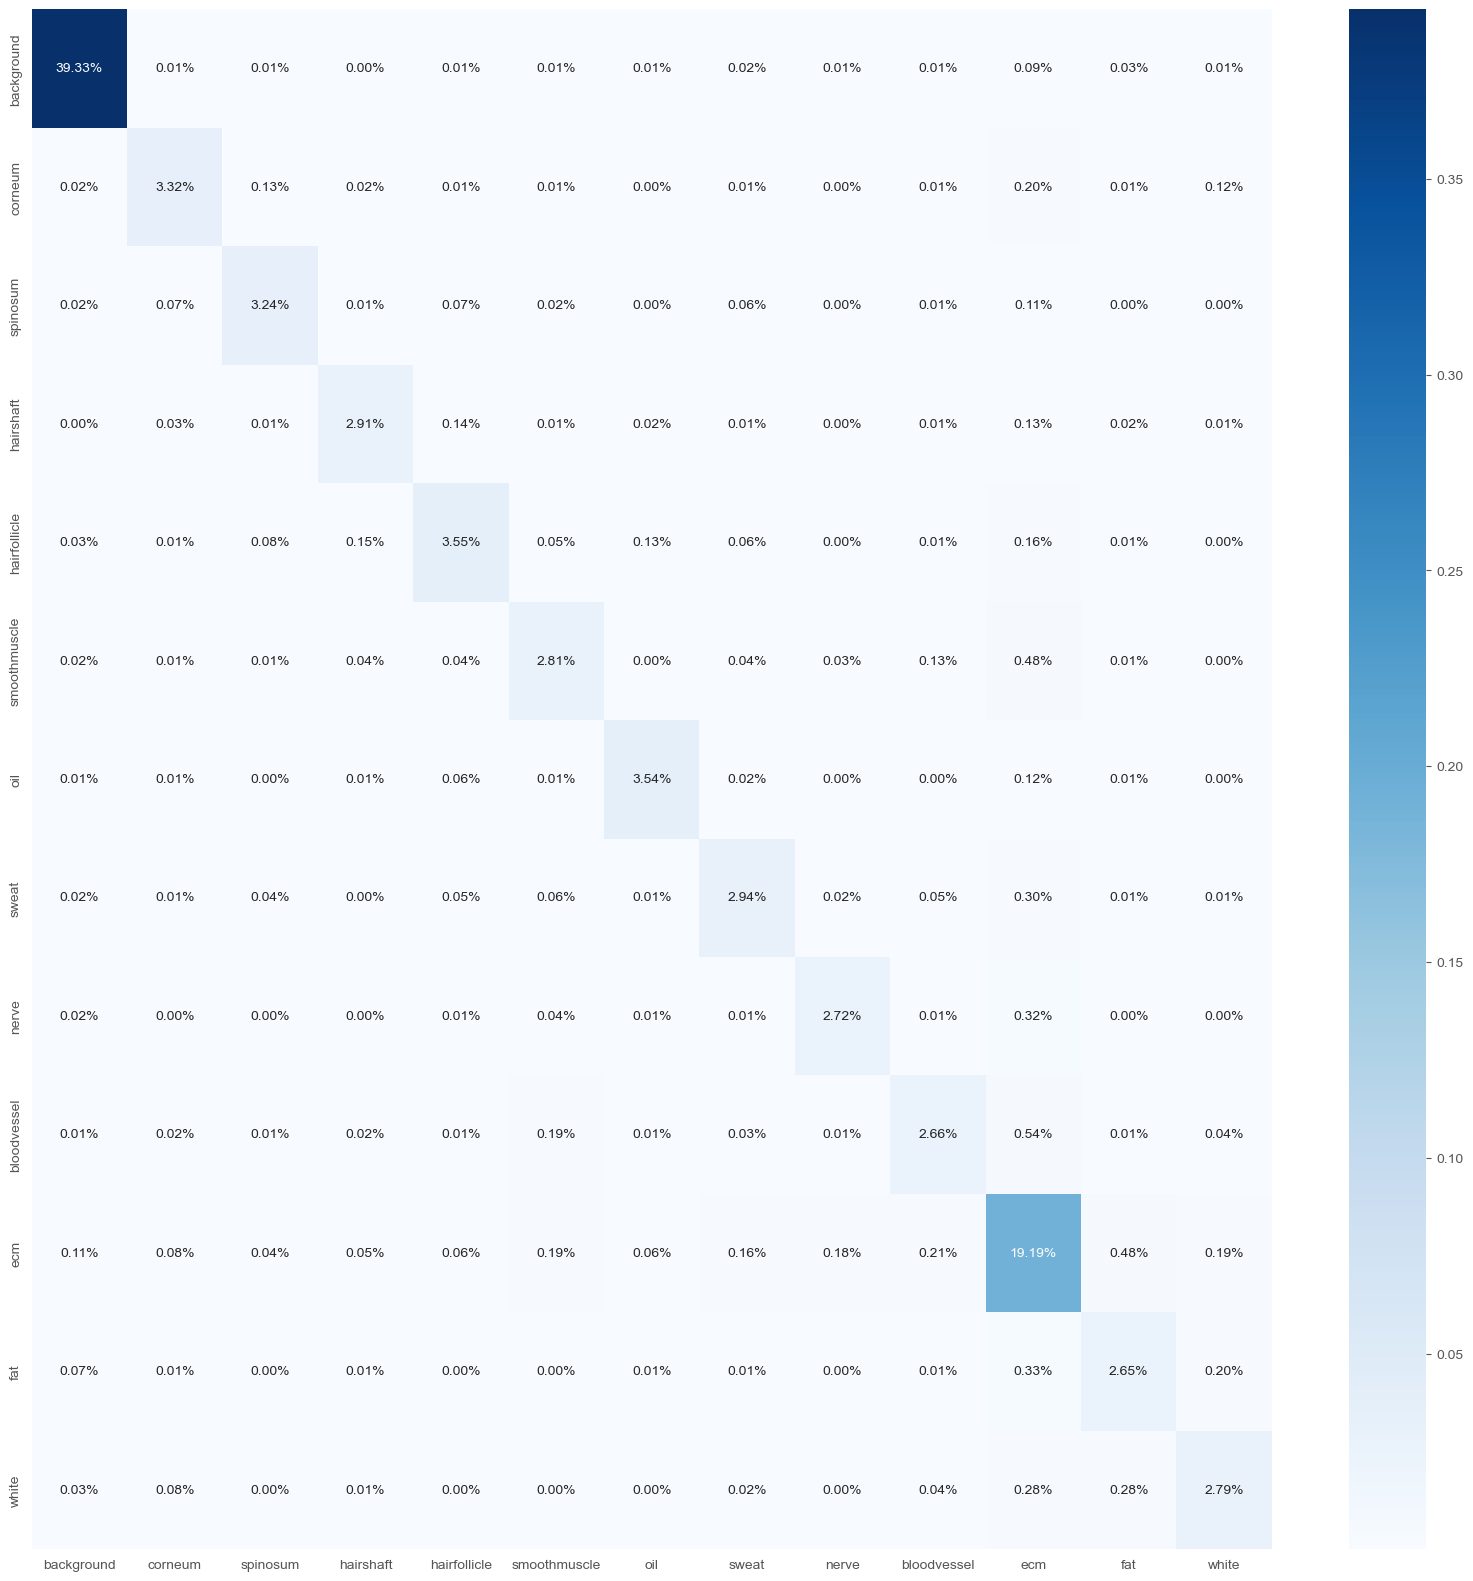

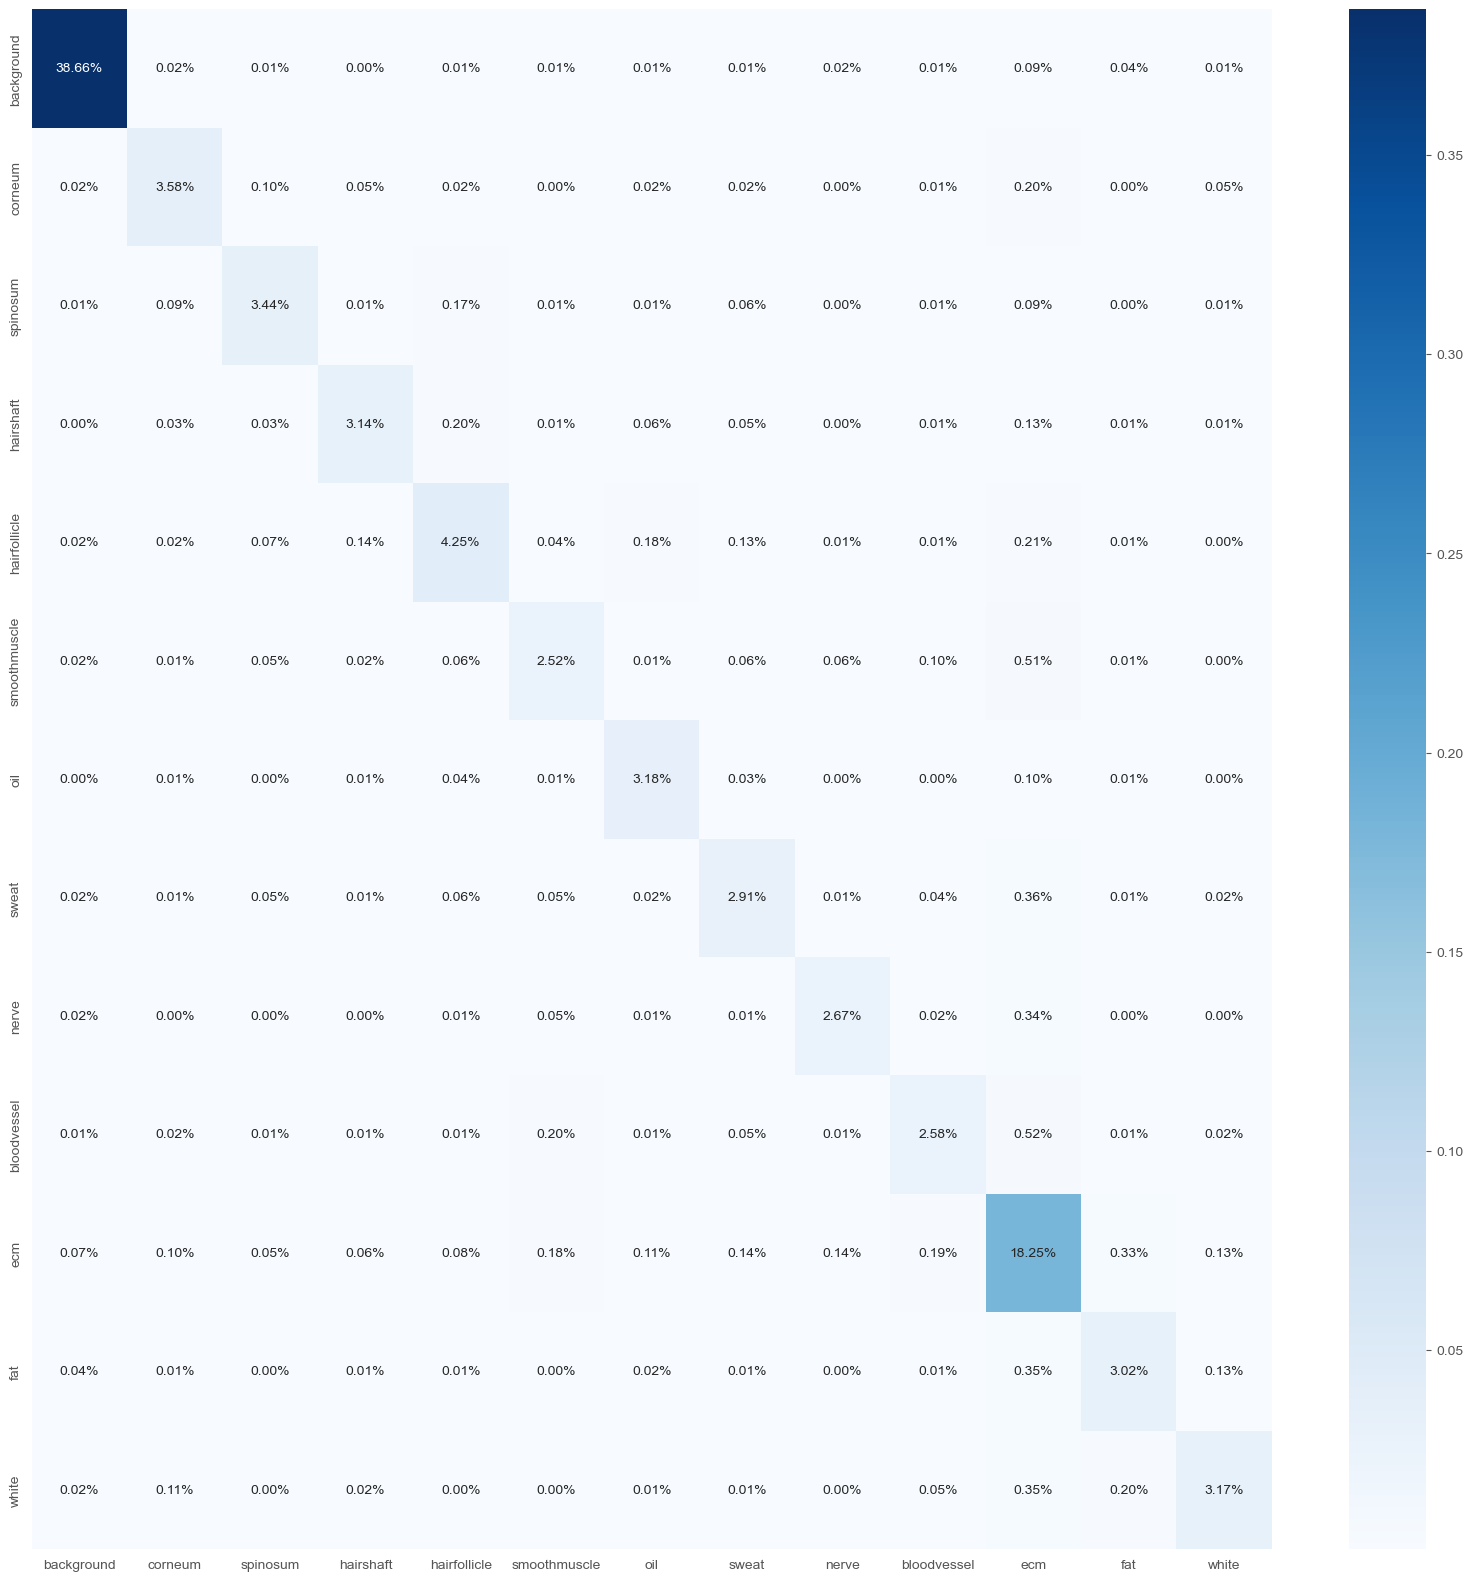

In [13]:
# finally run inference:
data_src = r"\\10.99.68.178\kyuex\image\skin_aging\deeplab_trainingset"
model_weight_dir = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet101"
start_fold = model_config.start_fold
do_TTA = not model_config.do_TTA
class_list = list(['background','corneum','spinosum','hairshaft','hairfollicle','smoothmuscle','oil','sweat','nerve','bloodvessel','ecm','fat','white'])
# repeat for all number of folds:
for fold in range(0, model_config.total_fold):
    current_fold = start_fold + fold
    fold_dir = r"v11_fold{}".format(current_fold)
    image_path = os.path.join(data_src, fold_dir)
    test_dir = os.path.join(image_path, "validation")
    test_image_dir = os.path.join(test_dir, "im")
    test_label_dir = os.path.join(test_dir, 'label')
    test_images = natsorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith(".png")])
    test_labels = natsorted([os.path.join(test_label_dir, x) for x in os.listdir(test_label_dir) if x.endswith(".png")])
    test_dataloader = load_test_dataset()  # load datasets
    model = build_model()  # build model
    # print(model)
    print("Running Inference for Fold {}".format(current_fold))
    valid_f1_score, conf_matrix_total,y_true_list, y_pred_list = run_inference(model,test_dataloader,model_config.device,current_fold,do_TTA,model_weight_dir)
    print("Valid F1 Score for fold{} is : {}".format(current_fold,valid_f1_score))

    fig, ax = plt.subplots(figsize=(20,20))
    plot = sns.heatmap(conf_matrix_total/np.sum(conf_matrix_total),annot=True, fmt = '.2%', cmap = 'Blues', ax = ax, xticklabels=class_list, yticklabels=class_list)
    save_path = os.path.join(model_weight_dir,"confusion_matrix")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,"confusion_matrix_no_TTA_fold{}.png".format(current_fold)))
    y_true_list = [x for y in y_true_list for x in y]
    y_pred_list = [x for y in y_pred_list for x in y]
    classification_rep = classification_report(y_true_list, y_pred_list, target_names=class_list, output_dict=True)
    df = pd.DataFrame(classification_rep).transpose()
    print(df)

### Now do the same pipeline as above but for resnet50 instead. With TTA:

Running Inference for Fold 1


Inference: 100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


Valid F1 Score for fold1 is : 0.9186413731076751
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20448735.00
corneum            0.90    0.88      0.89  1625646.00
spinosum           0.91    0.93      0.92  1610949.00
hairshaft          0.93    0.86      0.89  1555060.00
hairfollicle       0.89    0.87      0.88  2236595.00
smoothmuscle       0.83    0.68      0.75  1725615.00
oil                0.94    0.93      0.93  1841226.00
sweat              0.88    0.81      0.84  1733896.00
nerve              0.94    0.80      0.86  1571381.00
bloodvessel        0.86    0.63      0.73  1747577.00
ecm                0.83    0.95      0.88 11149088.00
fat                0.83    0.81      0.82  1605810.00
white              0.89    0.77      0.83  1480070.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.84      0.86 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 2


Inference: 100%|██████████| 6/6 [00:43<00:00,  7.32s/it]


Valid F1 Score for fold2 is : 0.9190429652197328
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20443050.00
corneum            0.87    0.90      0.89  1717392.00
spinosum           0.91    0.91      0.91  1778946.00
hairshaft          0.92    0.85      0.88  1672455.00
hairfollicle       0.89    0.85      0.87  2193227.00
smoothmuscle       0.87    0.69      0.77  1839449.00
oil                0.90    0.93      0.91  1473369.00
sweat              0.85    0.87      0.86  1837889.00
nerve              0.95    0.79      0.87  1521205.00
bloodvessel        0.83    0.71      0.77  1720911.00
ecm                0.85    0.93      0.89 10521526.00
fat                0.82    0.85      0.84  1792178.00
white              0.87    0.81      0.84  1820051.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.85      0.87 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 3


Inference: 100%|██████████| 6/6 [00:53<00:00,  8.89s/it]


Valid F1 Score for fold3 is : 0.9150518802972162
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19558190.00
corneum            0.92    0.90      0.91  2061052.00
spinosum           0.92    0.87      0.90  1813422.00
hairshaft          0.95    0.81      0.87  1870024.00
hairfollicle       0.86    0.86      0.86  2300474.00
smoothmuscle       0.83    0.68      0.75  1879365.00
oil                0.92    0.93      0.92  1822049.00
sweat              0.87    0.84      0.85  1718007.00
nerve              0.95    0.80      0.87  1599669.00
bloodvessel        0.85    0.70      0.77  1890150.00
ecm                0.82    0.94      0.88  9950966.00
fat                0.83    0.85      0.84  1839593.00
white              0.88    0.83      0.85  2028687.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.89    0.85      0.87 50331648.00
weighted avg       0.92    0.91      0.91 50331648.00
Running Inference for Fold 4


Inference: 100%|██████████| 6/6 [00:44<00:00,  7.45s/it]


Valid F1 Score for fold4 is : 0.9145568949023138
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19910261.00
corneum            0.91    0.87      0.89  1940033.00
spinosum           0.88    0.90      0.89  1823206.00
hairshaft          0.93    0.78      0.84  1652409.00
hairfollicle       0.87    0.84      0.86  2127411.00
smoothmuscle       0.80    0.74      0.77  1815789.00
oil                0.89    0.96      0.92  1909185.00
sweat              0.88    0.84      0.86  1773378.00
nerve              0.94    0.83      0.88  1585437.00
bloodvessel        0.85    0.71      0.77  1779307.00
ecm                0.85    0.92      0.88 10576403.00
fat                0.76    0.85      0.80  1658742.00
white              0.87    0.78      0.82  1780087.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.88    0.85      0.86 50331648.00
weighted avg       0.92    0.91      0.91 50331648.00
Running Inference for Fold 5


Inference: 100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


Valid F1 Score for fold5 is : 0.9141517675078054
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19579425.00
corneum            0.91    0.88      0.89  2041265.00
spinosum           0.94    0.85      0.89  1975690.00
hairshaft          0.90    0.85      0.87  1854423.00
hairfollicle       0.87    0.86      0.86  2560328.00
smoothmuscle       0.85    0.66      0.74  1722520.00
oil                0.93    0.92      0.92  1709972.00
sweat              0.87    0.83      0.85  1783783.00
nerve              0.94    0.81      0.87  1584420.00
bloodvessel        0.84    0.69      0.76  1735745.00
ecm                0.82    0.94      0.88  9973606.00
fat                0.83    0.85      0.84  1821976.00
white              0.88    0.83      0.85  1988495.00
accuracy           0.91    0.91      0.91        0.91
macro avg          0.89    0.84      0.86 50331648.00
weighted avg       0.91    0.91      0.91 50331648.00


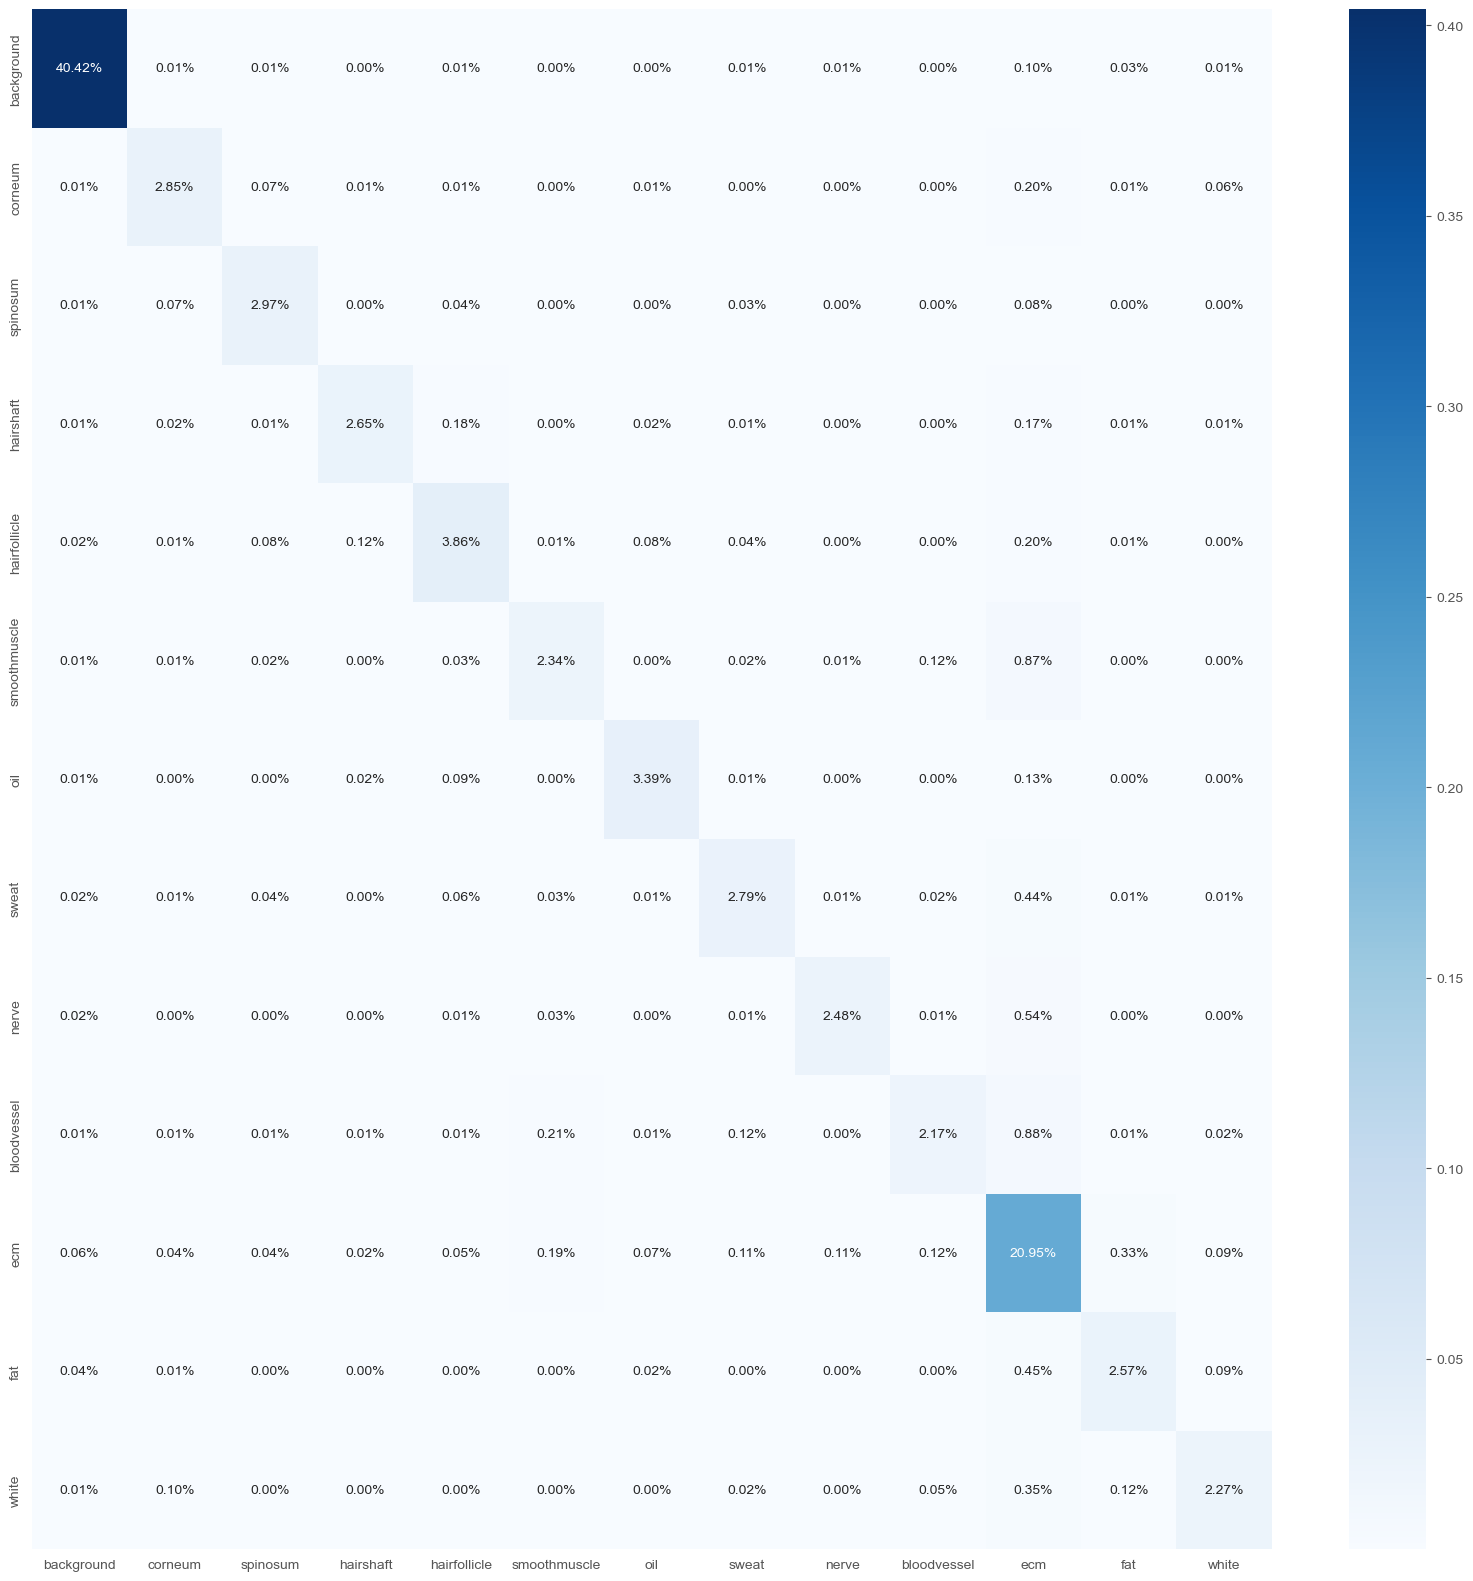

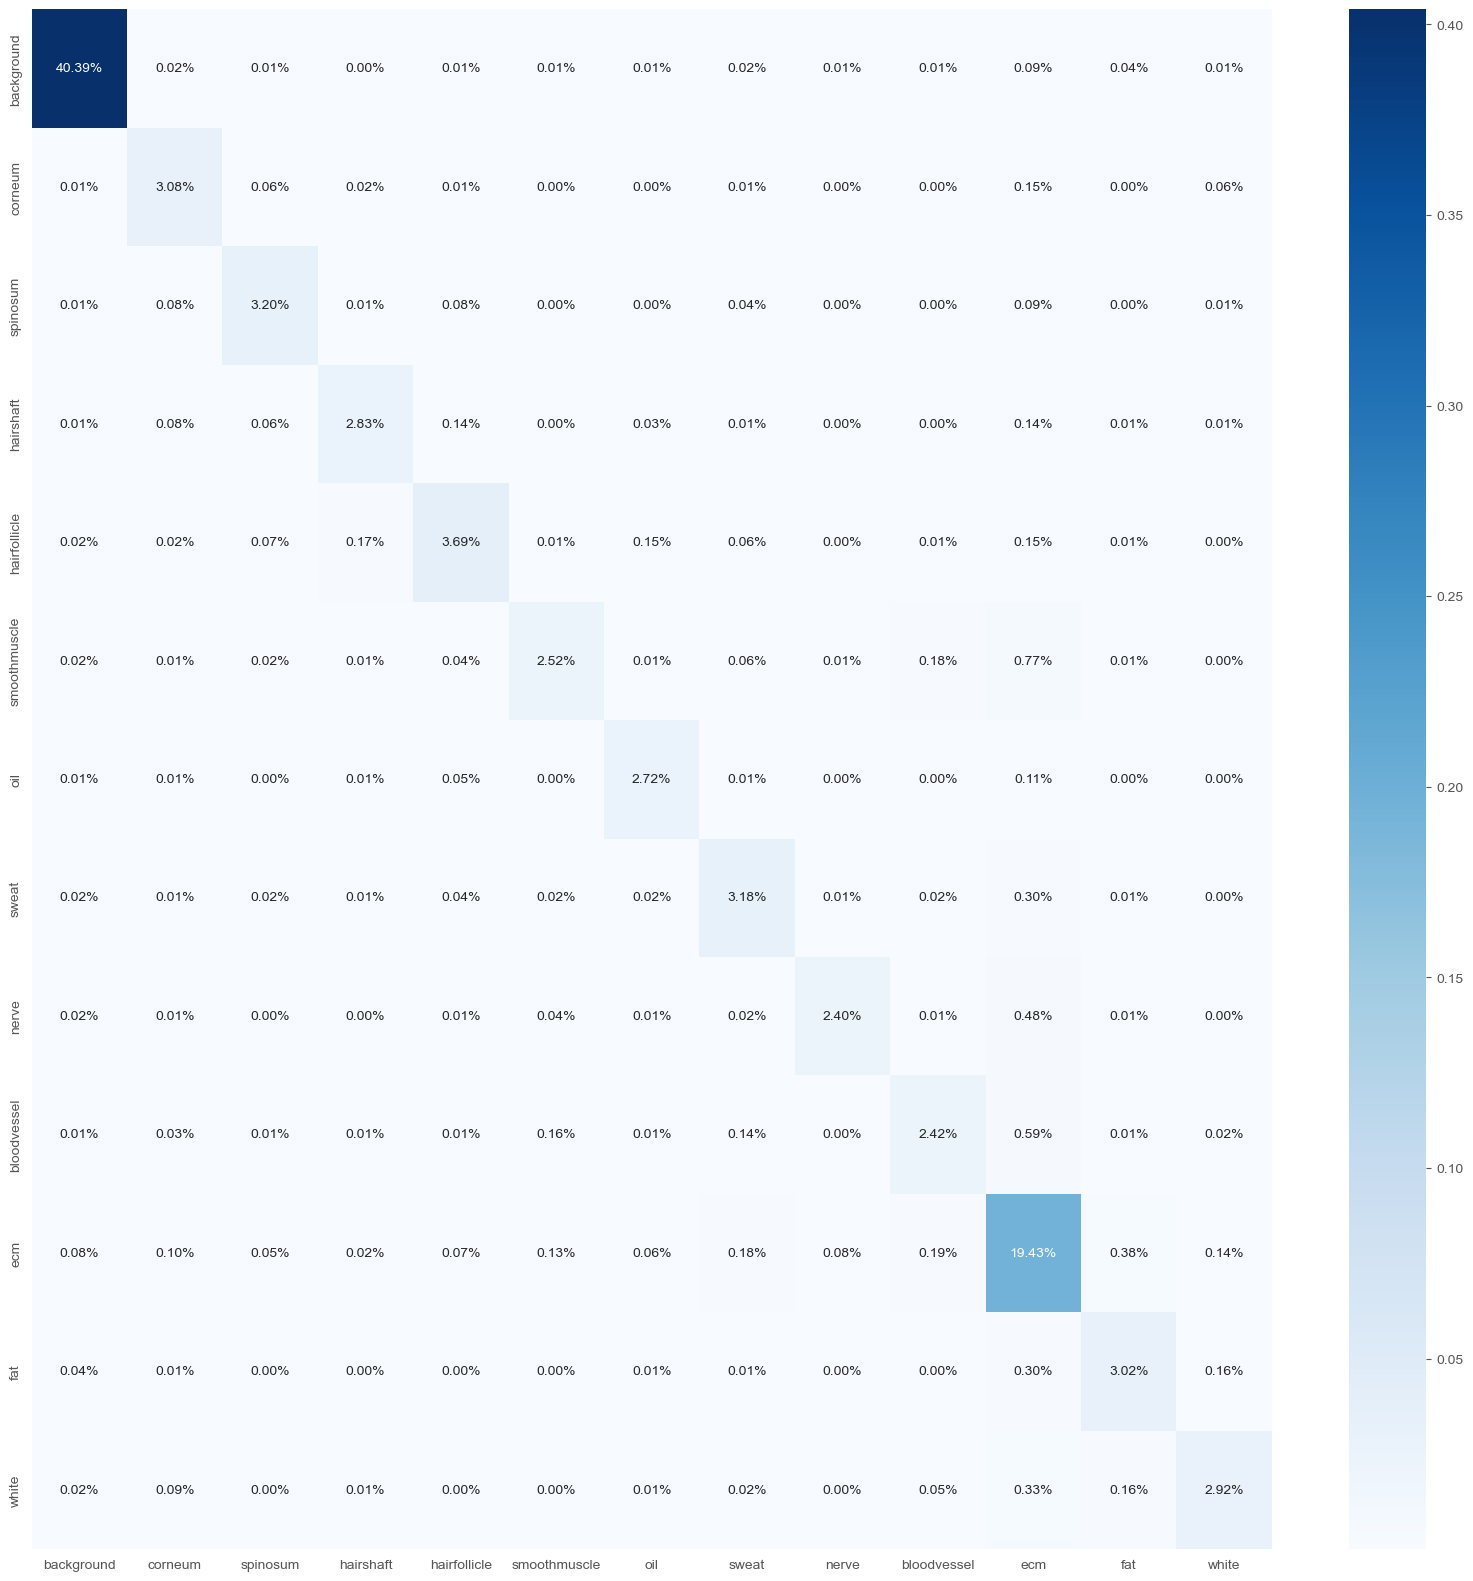

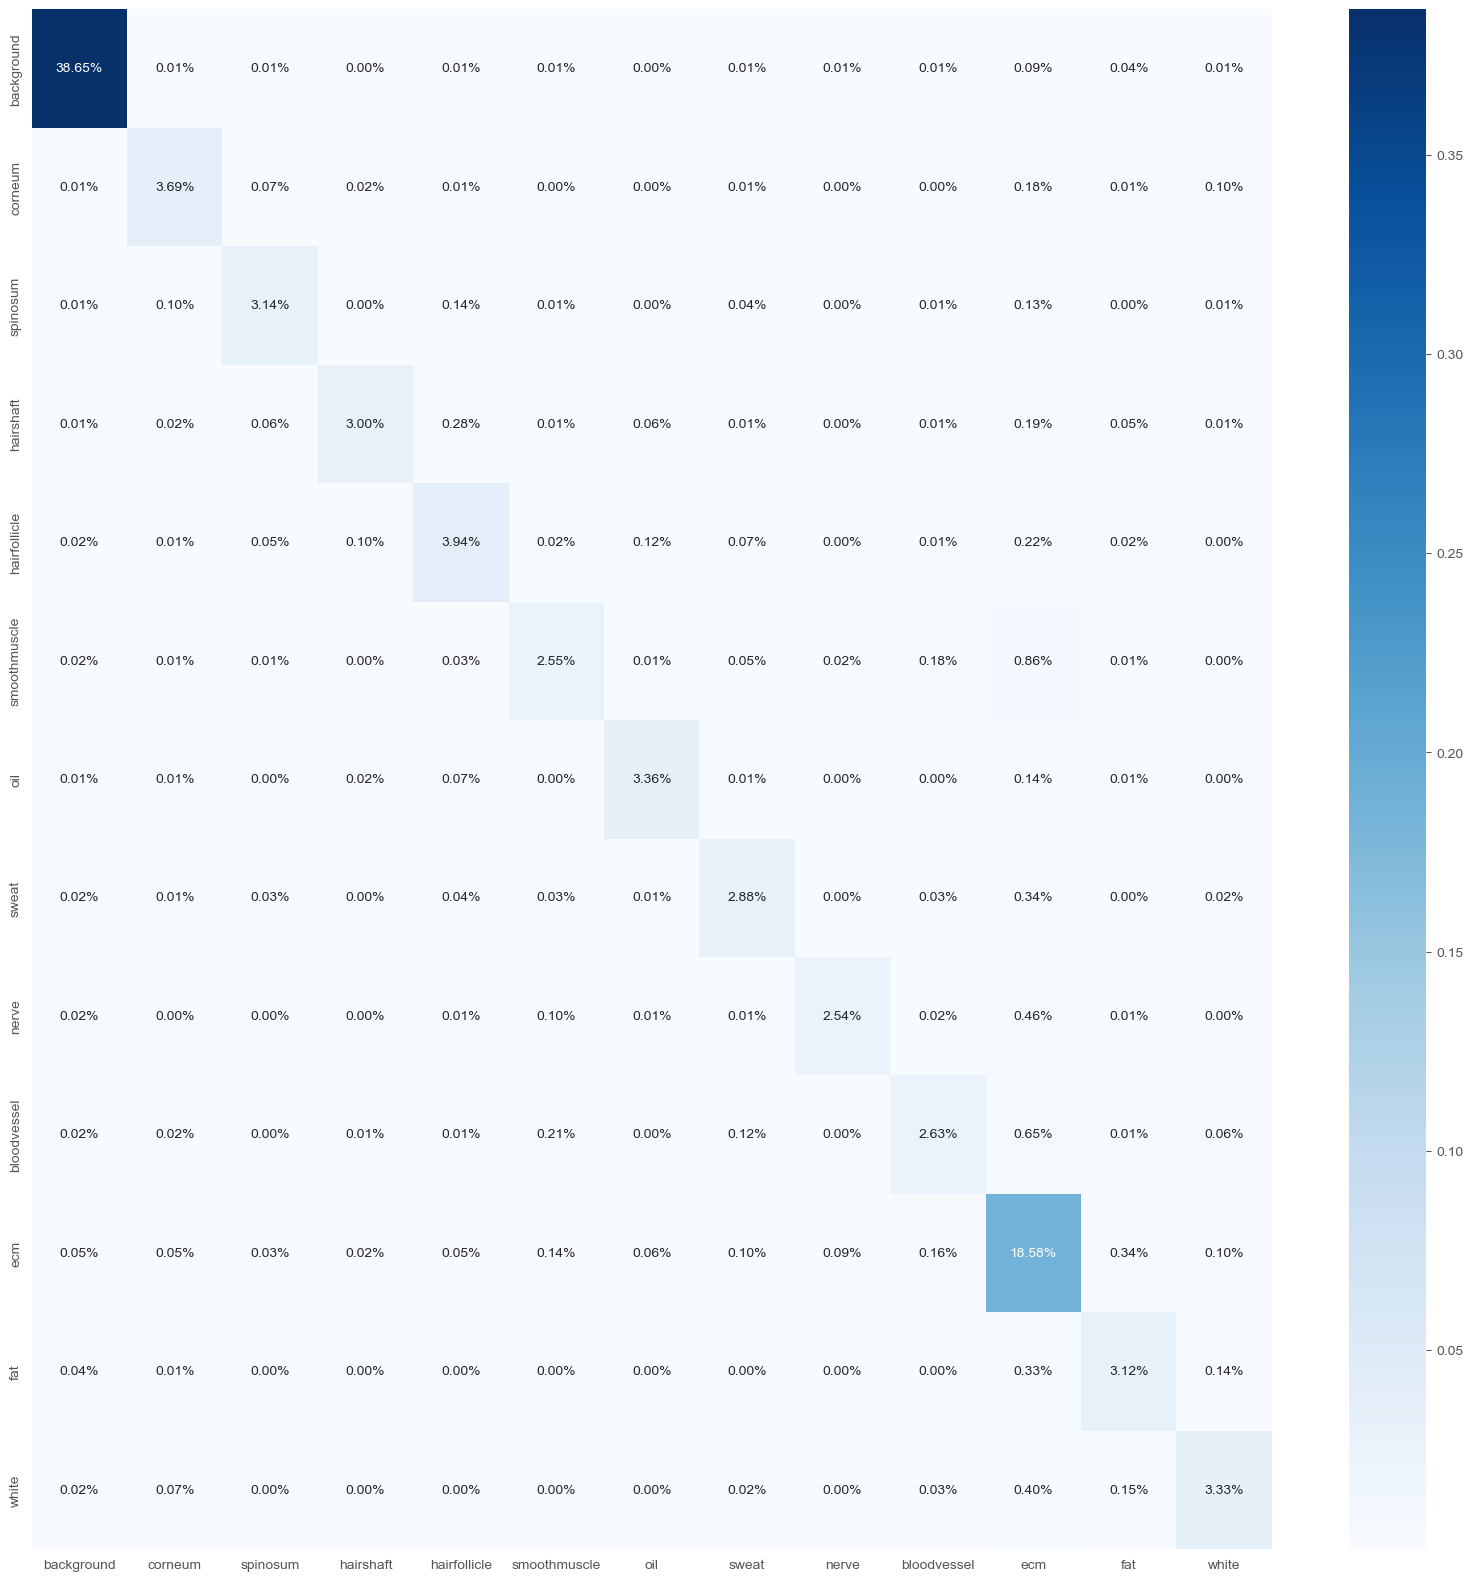

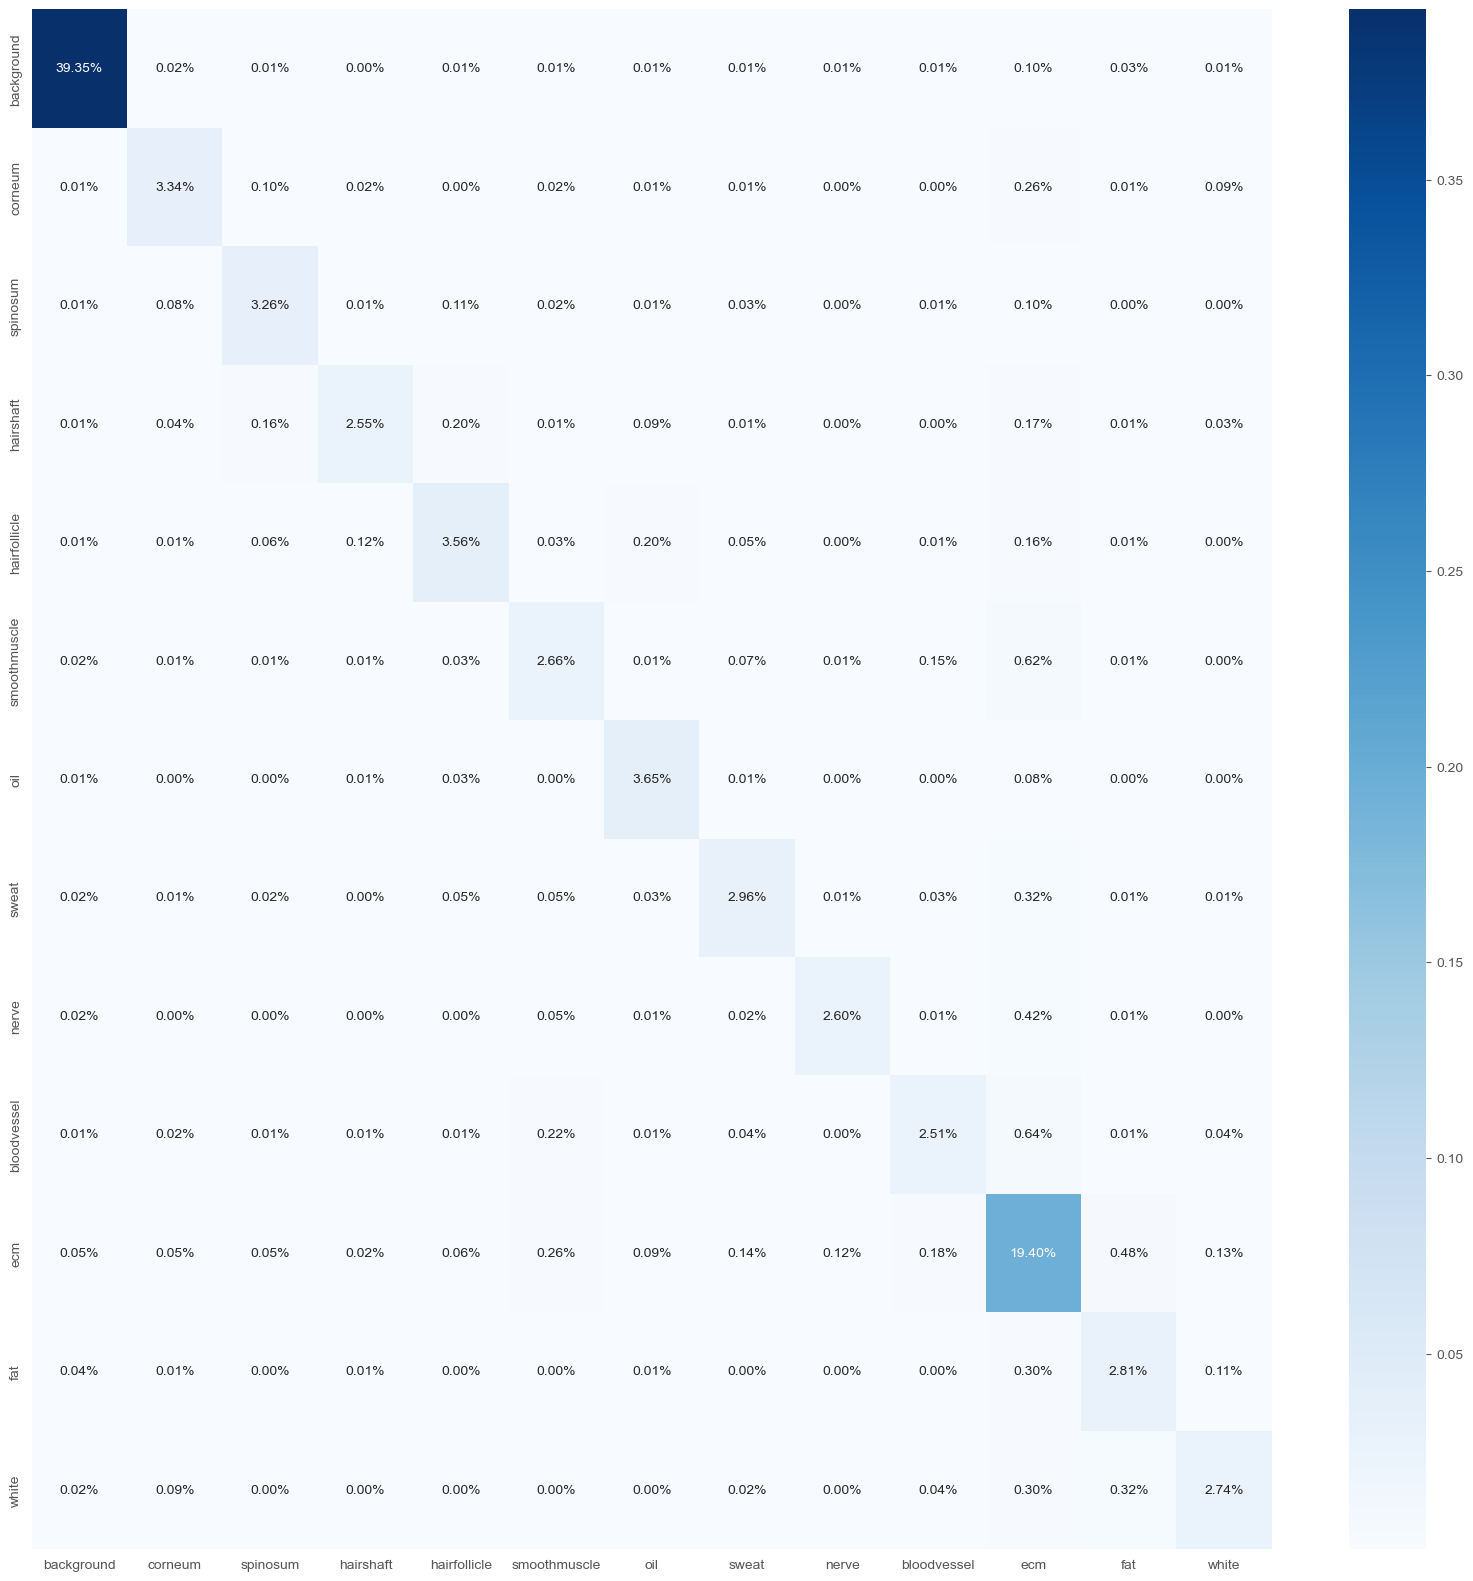

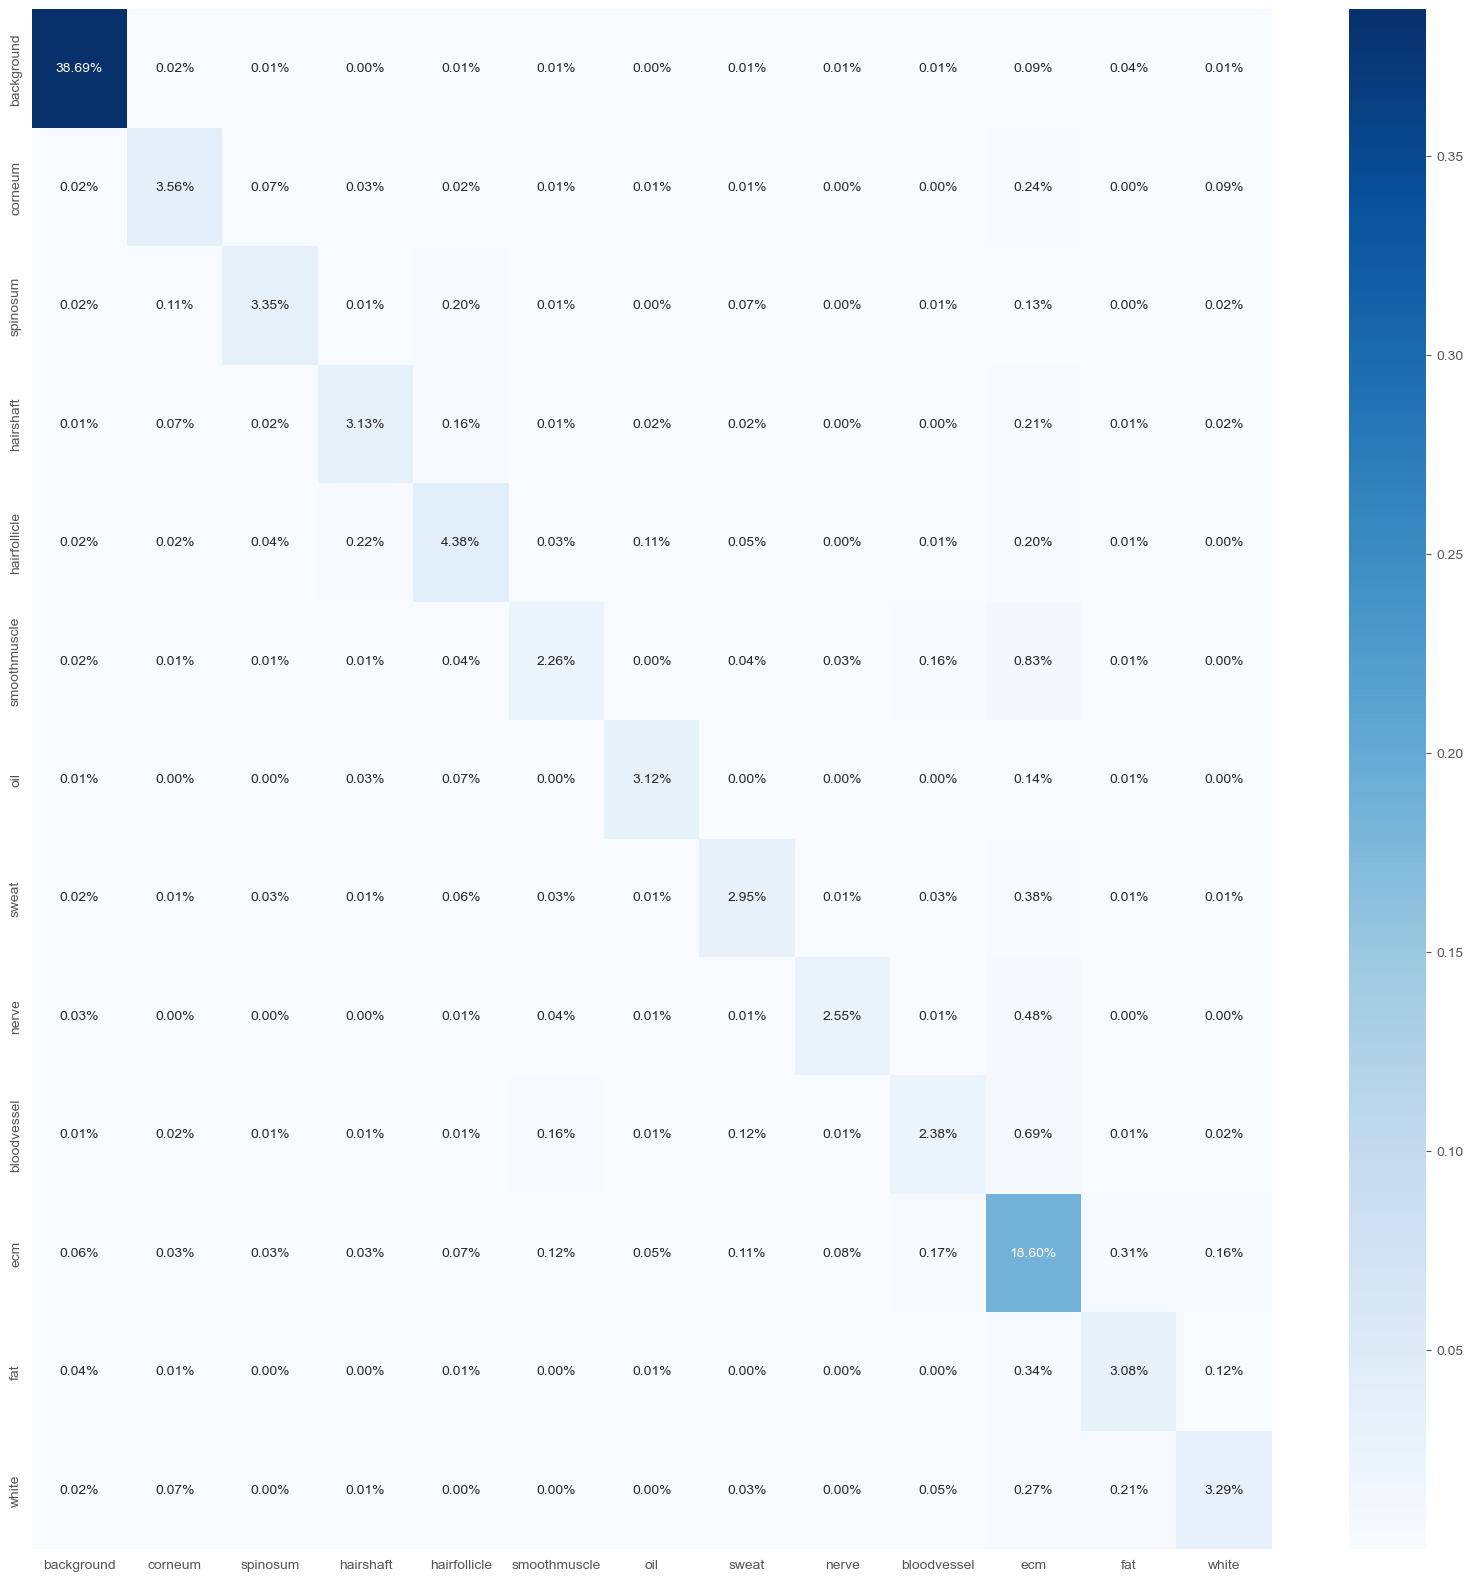

In [26]:
# finally run inference:
data_src = r"\\10.99.68.178\kyuex\image\skin_aging\deeplab_trainingset"
model_weight_dir = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet50"
start_fold = model_config.start_fold
do_TTA = model_config.do_TTA
class_list = list(['background','corneum','spinosum','hairshaft','hairfollicle','smoothmuscle','oil','sweat','nerve','bloodvessel','ecm','fat','white'])
# repeat for all number of folds:
for fold in range(0, model_config.total_fold):
    current_fold = start_fold + fold
    fold_dir = r"v11_fold{}".format(current_fold)
    image_path = os.path.join(data_src, fold_dir)
    test_dir = os.path.join(image_path, "validation")
    test_image_dir = os.path.join(test_dir, "im")
    test_label_dir = os.path.join(test_dir, 'label')
    test_images = natsorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith(".png")])
    test_labels = natsorted([os.path.join(test_label_dir, x) for x in os.listdir(test_label_dir) if x.endswith(".png")])
    test_dataloader = load_test_dataset()  # load datasets
    model = build_model()  # build model
    # print(model)
    print("Running Inference for Fold {}".format(current_fold))
    valid_f1_score, conf_matrix_total,y_true_list, y_pred_list = run_inference(model,test_dataloader,model_config.device,current_fold,do_TTA,model_weight_dir)
    print("Valid F1 Score for fold{} is : {}".format(current_fold,valid_f1_score))

    fig, ax = plt.subplots(figsize=(20,20))
    plot = sns.heatmap(conf_matrix_total/np.sum(conf_matrix_total),annot=True, fmt = '.2%', cmap = 'Blues', ax = ax, xticklabels=class_list, yticklabels=class_list)
    save_path = os.path.join(model_weight_dir,"confusion_matrix")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,"confusion_matrix_fold{}.png".format(current_fold)))
    y_true_list = [x for y in y_true_list for x in y]
    y_pred_list = [x for y in y_pred_list for x in y]
    classification_rep = classification_report(y_true_list, y_pred_list, target_names=class_list, output_dict=True)
    df = pd.DataFrame(classification_rep).transpose()
    print(df)

### Without TTA:

Running Inference for Fold 1


Inference: 100%|██████████| 6/6 [00:35<00:00,  5.95s/it]


Valid F1 Score for fold1 is : 0.9282280098325987
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20448735.00
corneum            0.90    0.88      0.89  1625646.00
spinosum           0.91    0.93      0.92  1610949.00
hairshaft          0.93    0.90      0.92  1555060.00
hairfollicle       0.88    0.88      0.88  2236595.00
smoothmuscle       0.83    0.79      0.81  1725615.00
oil                0.93    0.93      0.93  1841226.00
sweat              0.90    0.84      0.87  1733896.00
nerve              0.93    0.87      0.90  1571381.00
bloodvessel        0.88    0.74      0.81  1747577.00
ecm                0.87    0.93      0.90 11149088.00
fat                0.82    0.83      0.82  1605810.00
white              0.88    0.77      0.82  1480070.00
accuracy           0.93    0.93      0.93        0.93
macro avg          0.90    0.87      0.88 50331648.00
weighted avg       0.93    0.93      0.93 50331648.00
Running Inference for Fold 2


Inference: 100%|██████████| 6/6 [00:26<00:00,  4.36s/it]


Valid F1 Score for fold2 is : 0.9253068566631918
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20443050.00
corneum            0.87    0.91      0.89  1717392.00
spinosum           0.92    0.90      0.91  1778946.00
hairshaft          0.91    0.91      0.91  1672455.00
hairfollicle       0.89    0.85      0.87  2193227.00
smoothmuscle       0.87    0.77      0.82  1839449.00
oil                0.90    0.93      0.91  1473369.00
sweat              0.86    0.89      0.87  1837889.00
nerve              0.94    0.85      0.89  1521205.00
bloodvessel        0.84    0.79      0.81  1720911.00
ecm                0.88    0.91      0.90 10521526.00
fat                0.82    0.85      0.83  1792178.00
white              0.86    0.81      0.84  1820051.00
accuracy           0.93    0.93      0.93        0.93
macro avg          0.89    0.88      0.88 50331648.00
weighted avg       0.93    0.93      0.92 50331648.00
Running Inference for Fold 3


Inference: 100%|██████████| 6/6 [00:21<00:00,  3.54s/it]


Valid F1 Score for fold3 is : 0.9251170287962318
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19558190.00
corneum            0.91    0.90      0.91  2061052.00
spinosum           0.93    0.88      0.91  1813422.00
hairshaft          0.94    0.88      0.91  1870024.00
hairfollicle       0.87    0.87      0.87  2300474.00
smoothmuscle       0.86    0.76      0.81  1879365.00
oil                0.92    0.93      0.93  1822049.00
sweat              0.89    0.87      0.88  1718007.00
nerve              0.94    0.87      0.90  1599669.00
bloodvessel        0.86    0.79      0.82  1890150.00
ecm                0.86    0.93      0.89  9950966.00
fat                0.84    0.85      0.84  1839593.00
white              0.87    0.84      0.86  2028687.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.90    0.87      0.89 50331648.00
weighted avg       0.93    0.92      0.92 50331648.00
Running Inference for Fold 4


Inference: 100%|██████████| 6/6 [00:23<00:00,  3.91s/it]


Valid F1 Score for fold4 is : 0.9232589756139392
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19910261.00
corneum            0.91    0.88      0.89  1940033.00
spinosum           0.92    0.90      0.91  1823206.00
hairshaft          0.93    0.88      0.91  1652409.00
hairfollicle       0.88    0.86      0.87  2127411.00
smoothmuscle       0.83    0.80      0.82  1815789.00
oil                0.89    0.96      0.93  1909185.00
sweat              0.88    0.86      0.87  1773378.00
nerve              0.93    0.88      0.90  1585437.00
bloodvessel        0.85    0.78      0.81  1779307.00
ecm                0.88    0.91      0.90 10576403.00
fat                0.75    0.84      0.80  1658742.00
white              0.87    0.78      0.82  1780087.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.87      0.88 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 5


Inference: 100%|██████████| 6/6 [00:25<00:00,  4.20s/it]


Valid F1 Score for fold5 is : 0.9208762947922909
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19579425.00
corneum            0.91    0.88      0.89  2041265.00
spinosum           0.94    0.86      0.90  1975690.00
hairshaft          0.90    0.88      0.89  1854423.00
hairfollicle       0.87    0.86      0.86  2560328.00
smoothmuscle       0.86    0.75      0.80  1722520.00
oil                0.93    0.91      0.92  1709972.00
sweat              0.88    0.85      0.87  1783783.00
nerve              0.92    0.85      0.89  1584420.00
bloodvessel        0.84    0.78      0.81  1735745.00
ecm                0.85    0.93      0.89  9973606.00
fat                0.83    0.84      0.83  1821976.00
white              0.87    0.84      0.85  1988495.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.86      0.88 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00


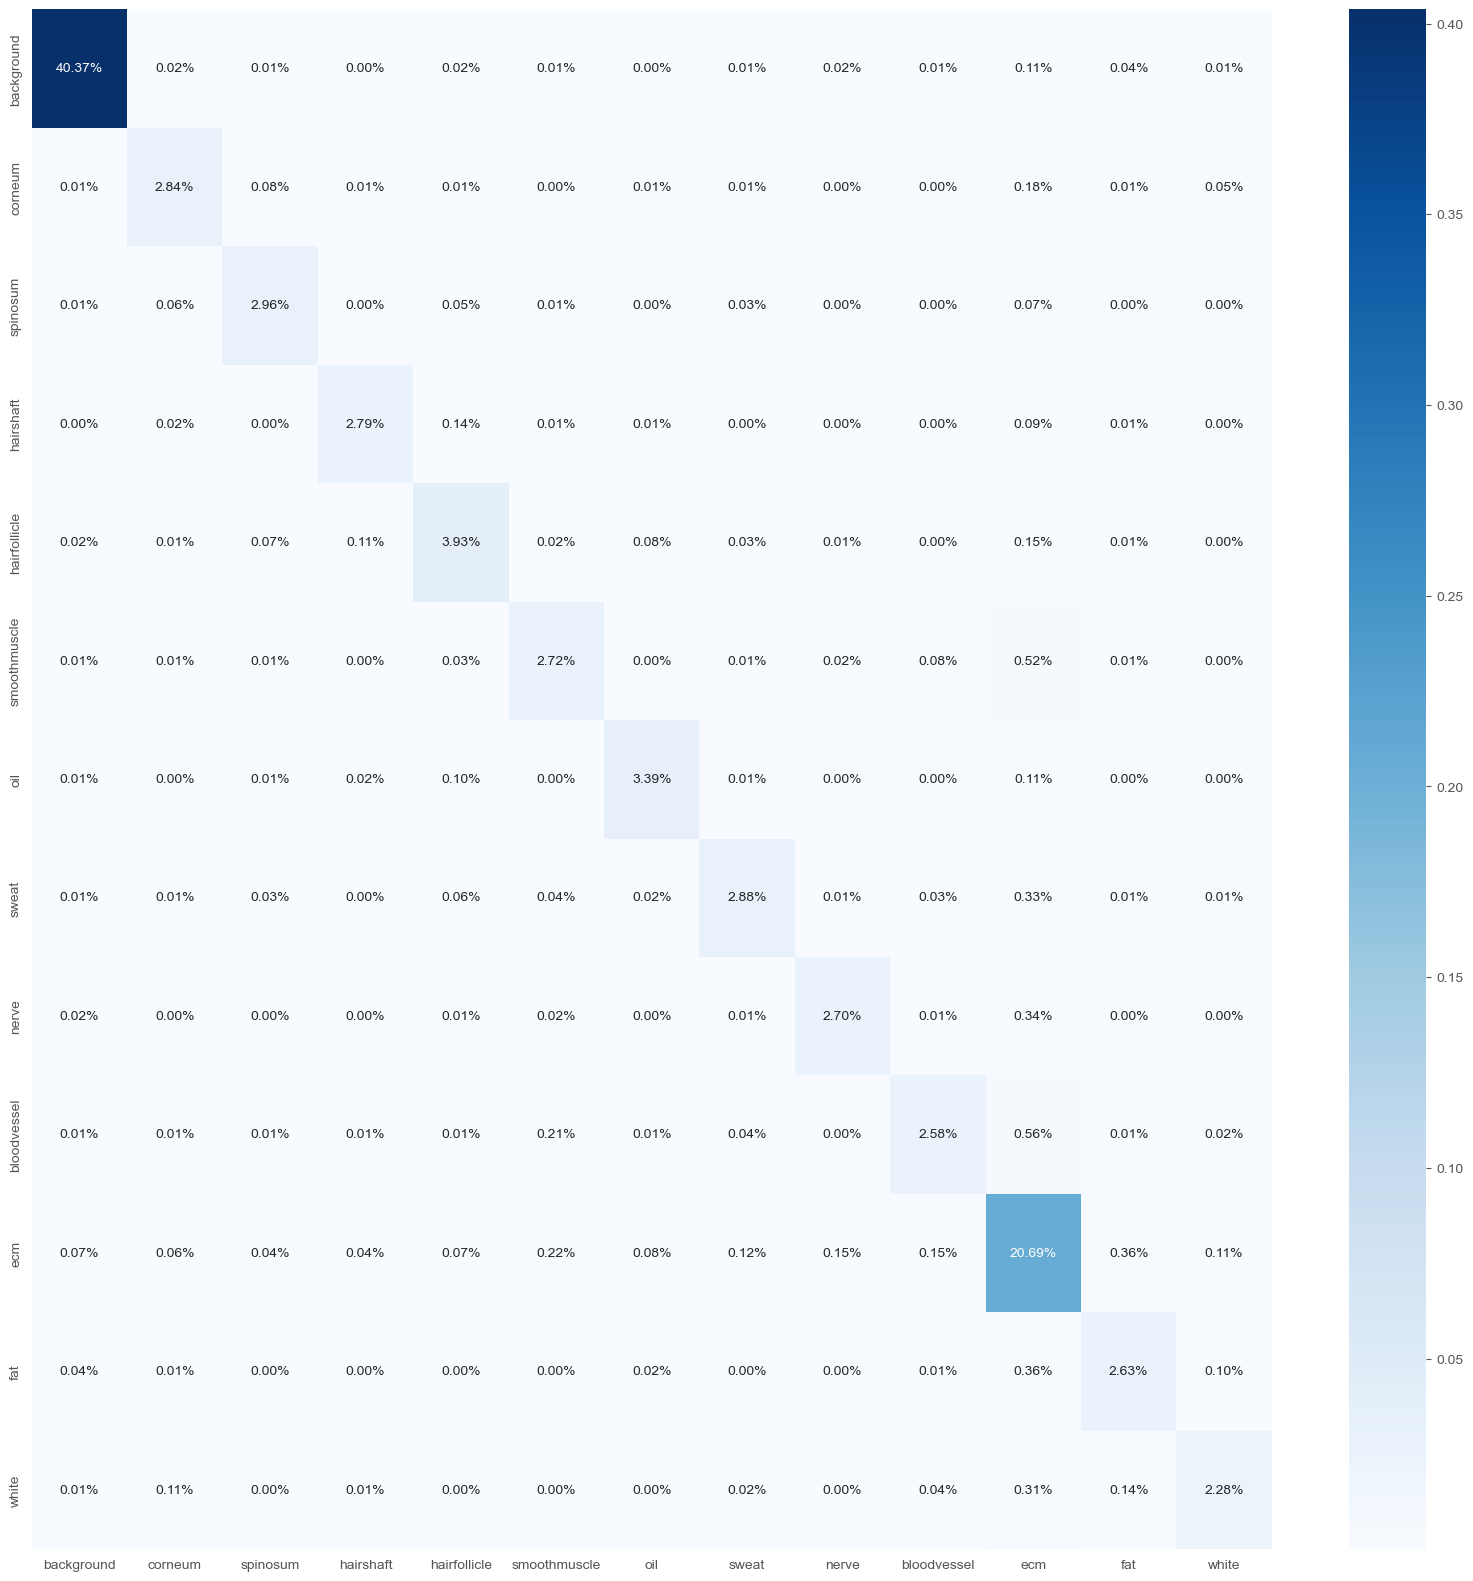

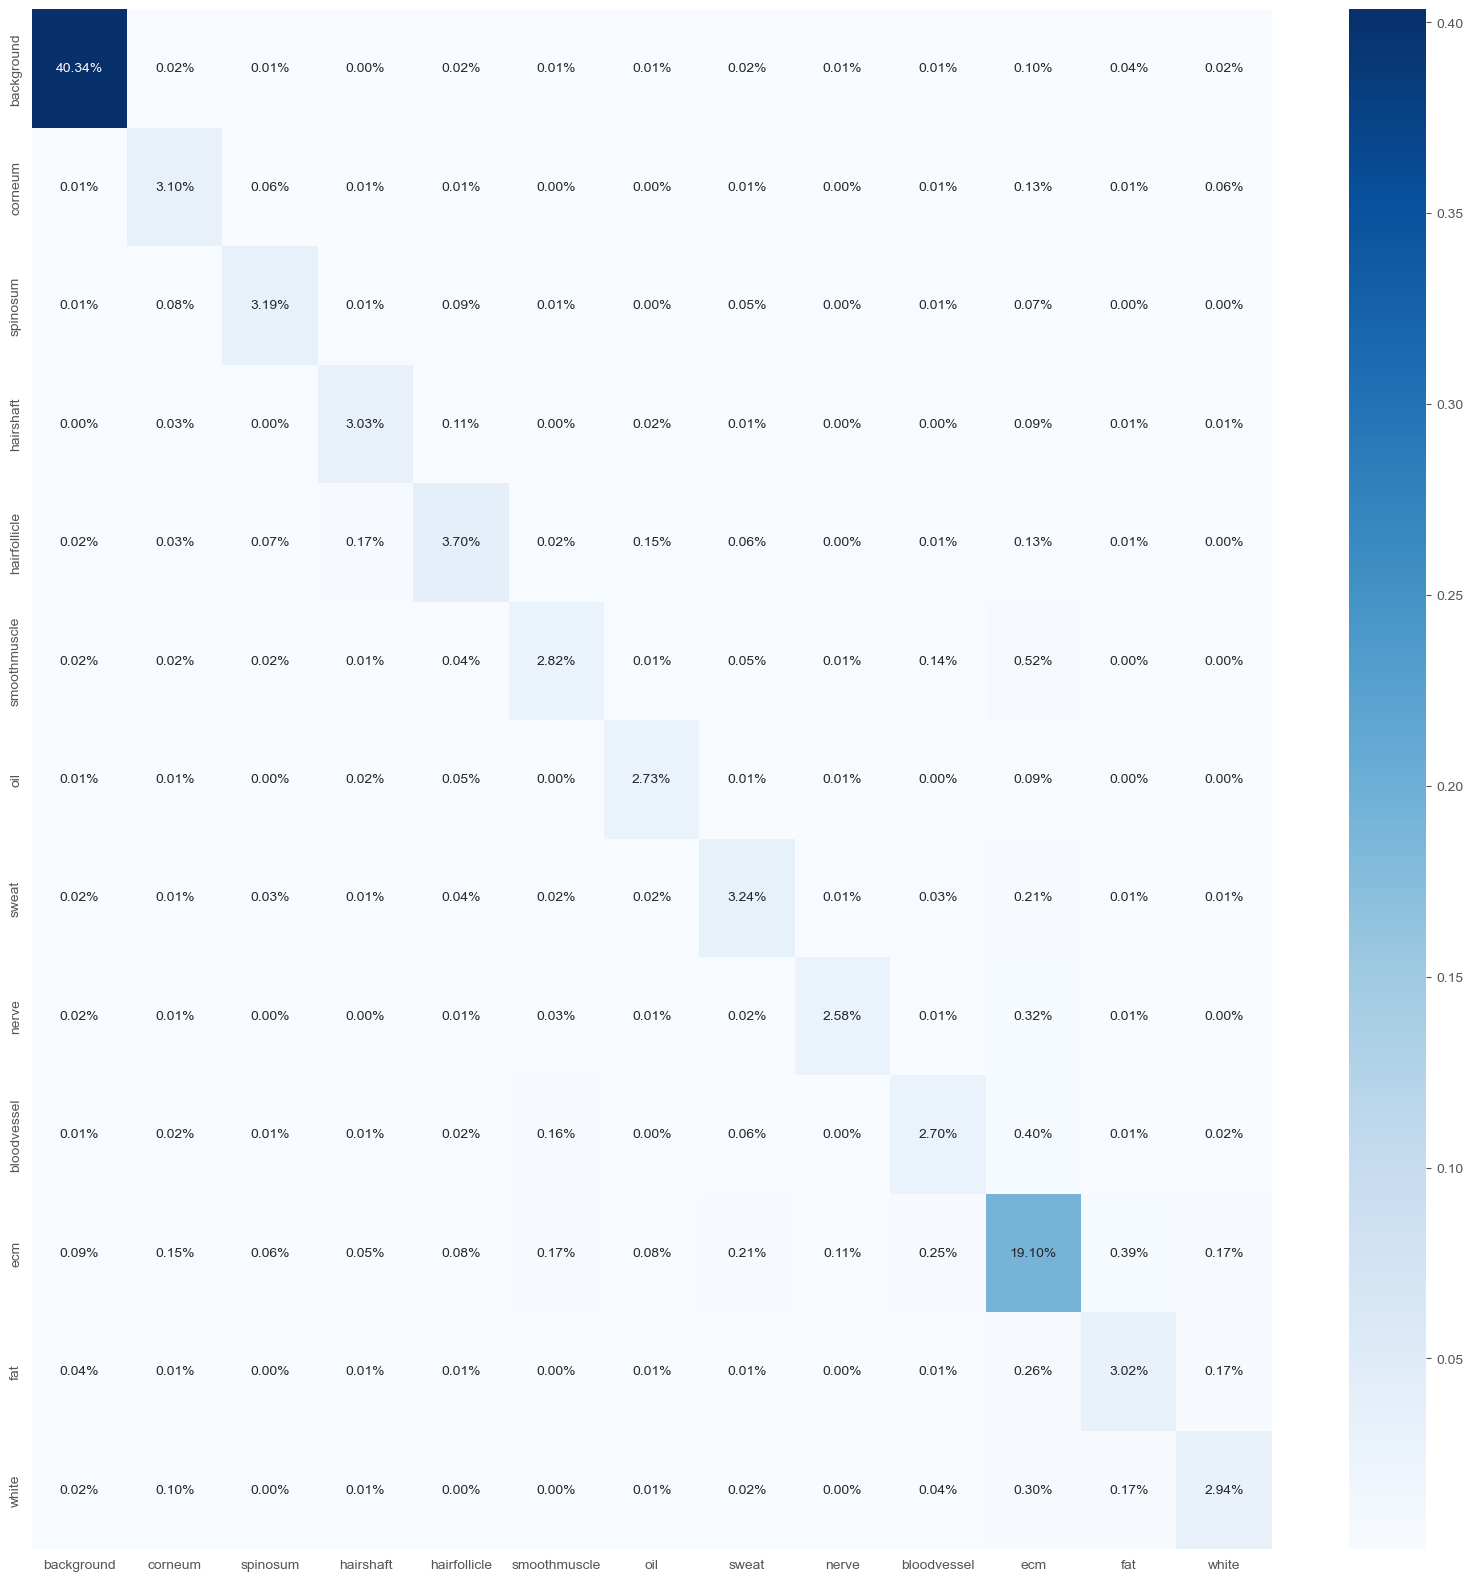

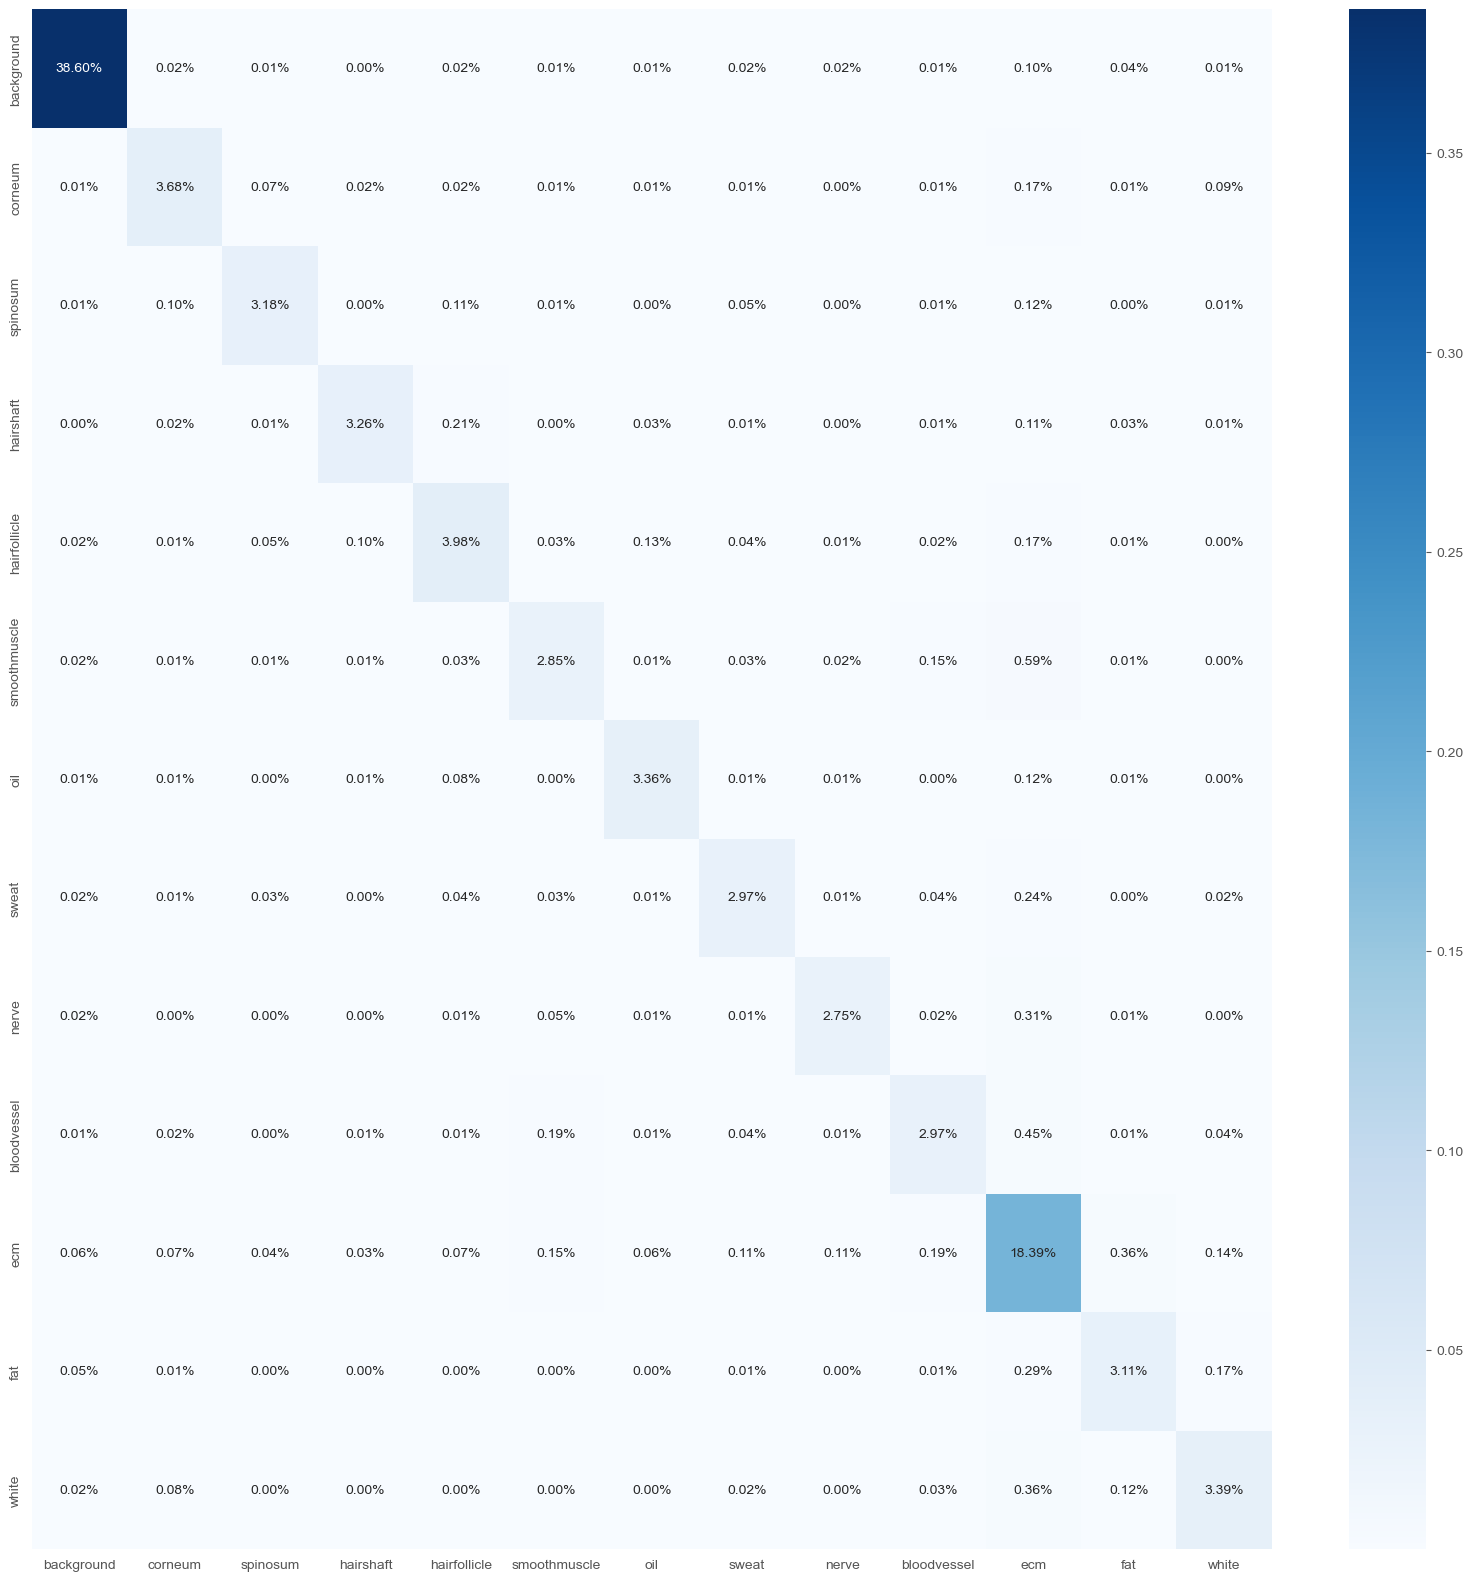

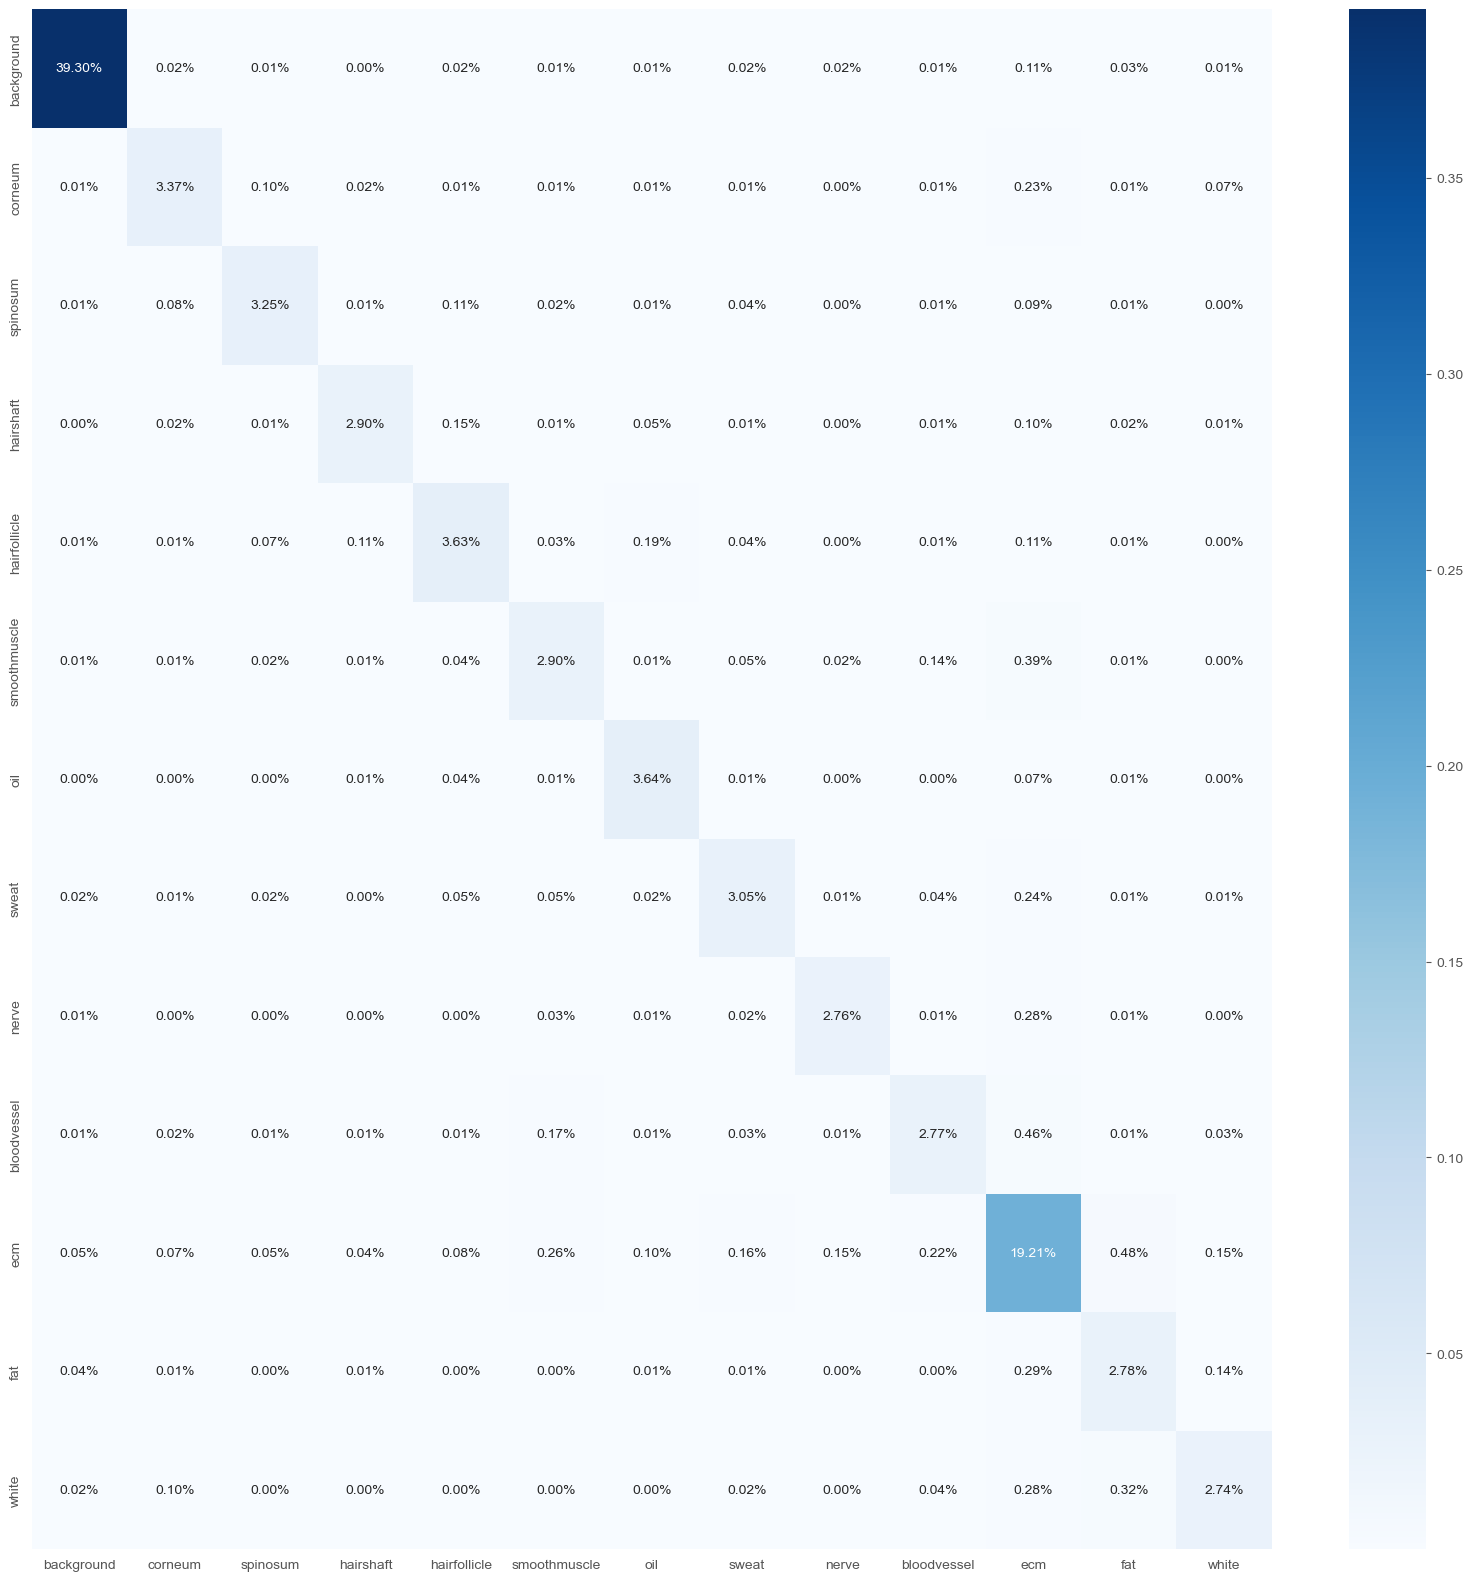

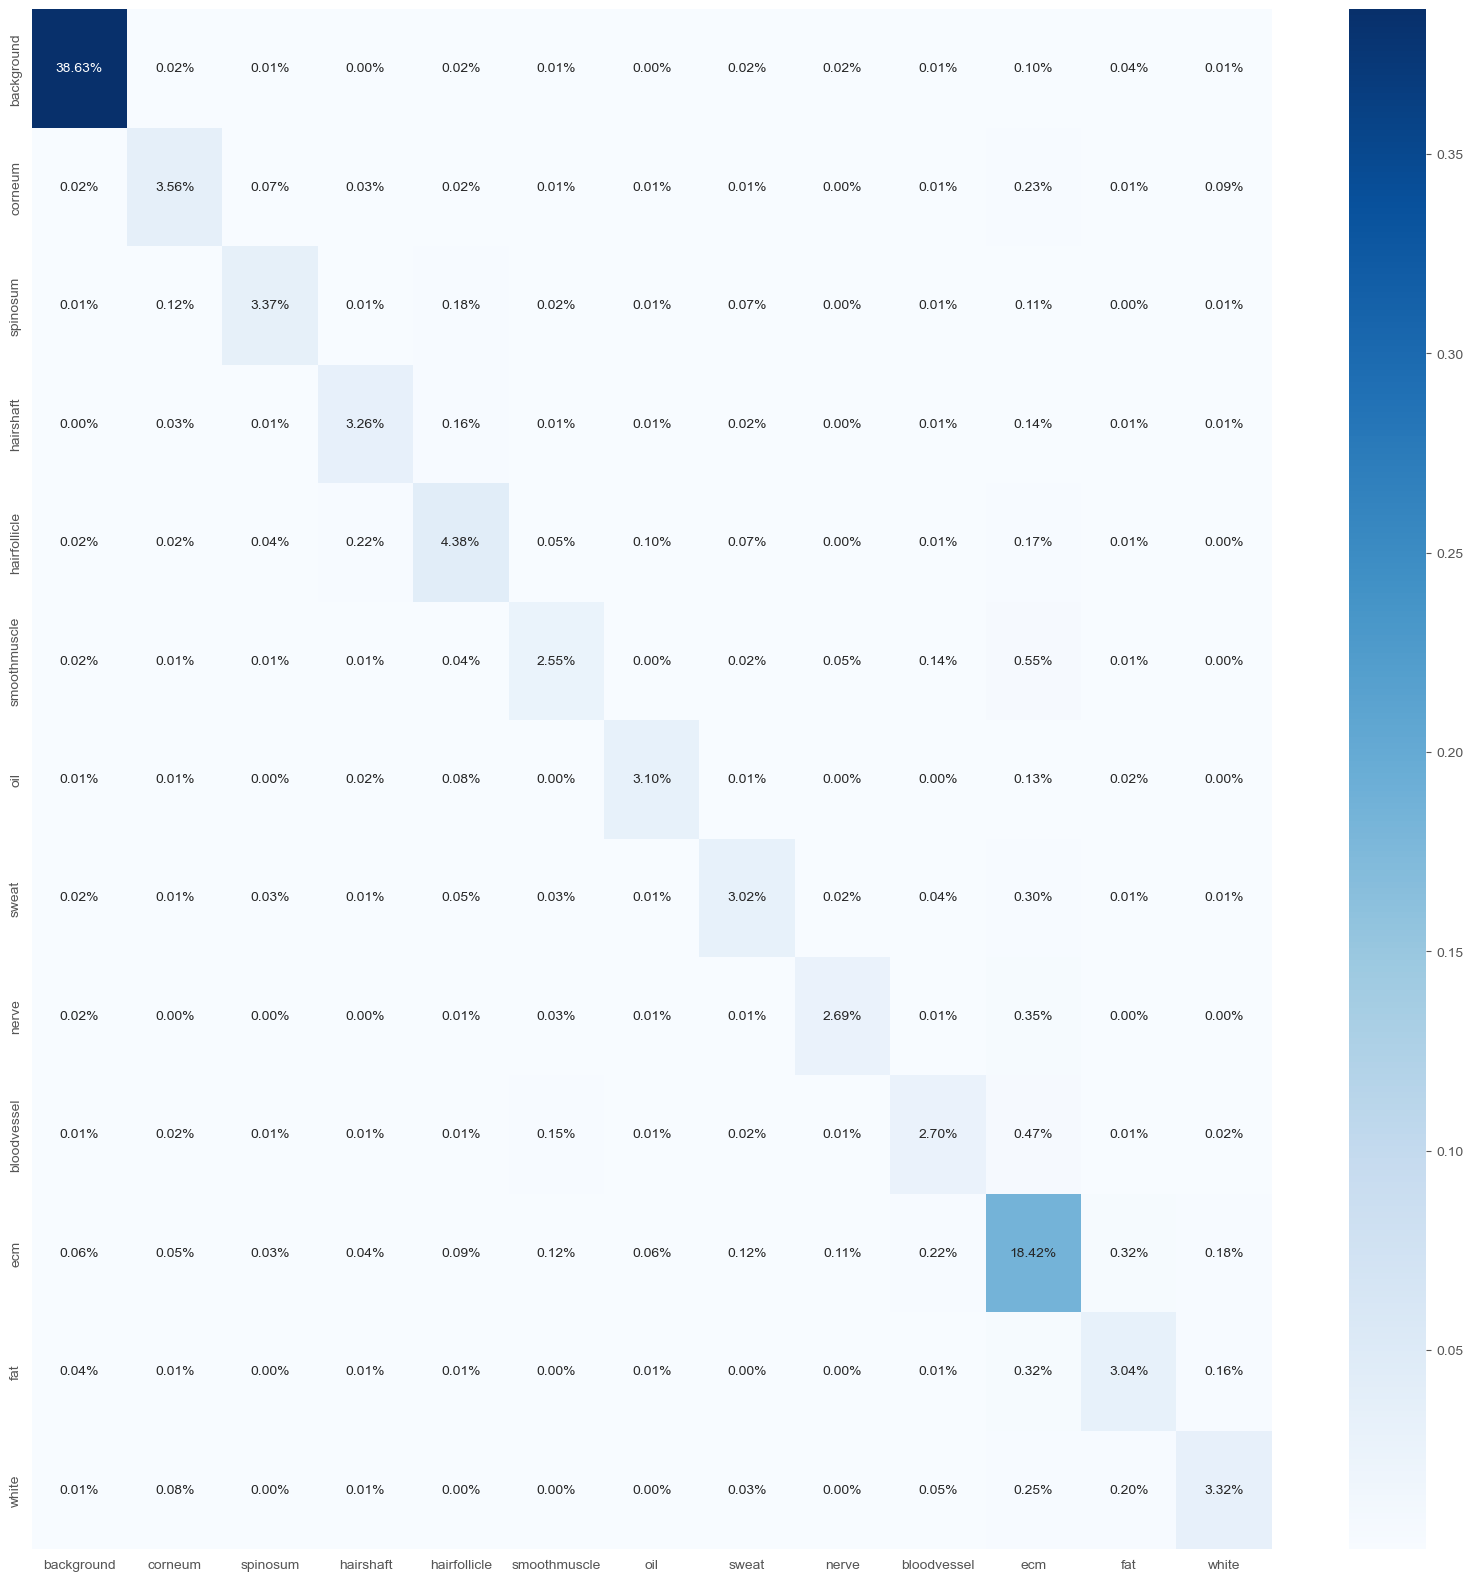

Running Inference for Fold 1


Inference: 100%|██████████| 6/6 [00:23<00:00,  3.89s/it]


Valid F1 Score for fold1 is : 0.9282280098325987
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20448735.00
corneum            0.90    0.88      0.89  1625646.00
spinosum           0.91    0.93      0.92  1610949.00
hairshaft          0.93    0.90      0.92  1555060.00
hairfollicle       0.88    0.88      0.88  2236595.00
smoothmuscle       0.83    0.79      0.81  1725615.00
oil                0.93    0.93      0.93  1841226.00
sweat              0.90    0.84      0.87  1733896.00
nerve              0.93    0.87      0.90  1571381.00
bloodvessel        0.88    0.74      0.81  1747577.00
ecm                0.87    0.93      0.90 11149088.00
fat                0.82    0.83      0.82  1605810.00
white              0.88    0.77      0.82  1480070.00
accuracy           0.93    0.93      0.93        0.93
macro avg          0.90    0.87      0.88 50331648.00
weighted avg       0.93    0.93      0.93 50331648.00
Running Inference for Fold 2


Inference: 100%|██████████| 6/6 [00:21<00:00,  3.66s/it]


Valid F1 Score for fold2 is : 0.9253068566631918
              precision  recall  f1-score     support
background         0.99    0.99      0.99 20443050.00
corneum            0.87    0.91      0.89  1717392.00
spinosum           0.92    0.90      0.91  1778946.00
hairshaft          0.91    0.91      0.91  1672455.00
hairfollicle       0.89    0.85      0.87  2193227.00
smoothmuscle       0.87    0.77      0.82  1839449.00
oil                0.90    0.93      0.91  1473369.00
sweat              0.86    0.89      0.87  1837889.00
nerve              0.94    0.85      0.89  1521205.00
bloodvessel        0.84    0.79      0.81  1720911.00
ecm                0.88    0.91      0.90 10521526.00
fat                0.82    0.85      0.83  1792178.00
white              0.86    0.81      0.84  1820051.00
accuracy           0.93    0.93      0.93        0.93
macro avg          0.89    0.88      0.88 50331648.00
weighted avg       0.93    0.93      0.92 50331648.00
Running Inference for Fold 3


Inference: 100%|██████████| 6/6 [00:22<00:00,  3.71s/it]


Valid F1 Score for fold3 is : 0.9251170287962318
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19558190.00
corneum            0.91    0.90      0.91  2061052.00
spinosum           0.93    0.88      0.91  1813422.00
hairshaft          0.94    0.88      0.91  1870024.00
hairfollicle       0.87    0.87      0.87  2300474.00
smoothmuscle       0.86    0.76      0.81  1879365.00
oil                0.92    0.93      0.93  1822049.00
sweat              0.89    0.87      0.88  1718007.00
nerve              0.94    0.87      0.90  1599669.00
bloodvessel        0.86    0.79      0.82  1890150.00
ecm                0.86    0.93      0.89  9950966.00
fat                0.84    0.85      0.84  1839593.00
white              0.87    0.84      0.86  2028687.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.90    0.87      0.89 50331648.00
weighted avg       0.93    0.92      0.92 50331648.00
Running Inference for Fold 4


Inference: 100%|██████████| 6/6 [00:21<00:00,  3.64s/it]


Valid F1 Score for fold4 is : 0.9232589756139392
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19910261.00
corneum            0.91    0.88      0.89  1940033.00
spinosum           0.92    0.90      0.91  1823206.00
hairshaft          0.93    0.88      0.91  1652409.00
hairfollicle       0.88    0.86      0.87  2127411.00
smoothmuscle       0.83    0.80      0.82  1815789.00
oil                0.89    0.96      0.93  1909185.00
sweat              0.88    0.86      0.87  1773378.00
nerve              0.93    0.88      0.90  1585437.00
bloodvessel        0.85    0.78      0.81  1779307.00
ecm                0.88    0.91      0.90 10576403.00
fat                0.75    0.84      0.80  1658742.00
white              0.87    0.78      0.82  1780087.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.87      0.88 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00
Running Inference for Fold 5


Inference: 100%|██████████| 6/6 [00:22<00:00,  3.79s/it]


Valid F1 Score for fold5 is : 0.9208762947922909
              precision  recall  f1-score     support
background         0.99    0.99      0.99 19579425.00
corneum            0.91    0.88      0.89  2041265.00
spinosum           0.94    0.86      0.90  1975690.00
hairshaft          0.90    0.88      0.89  1854423.00
hairfollicle       0.87    0.86      0.86  2560328.00
smoothmuscle       0.86    0.75      0.80  1722520.00
oil                0.93    0.91      0.92  1709972.00
sweat              0.88    0.85      0.87  1783783.00
nerve              0.92    0.85      0.89  1584420.00
bloodvessel        0.84    0.78      0.81  1735745.00
ecm                0.85    0.93      0.89  9973606.00
fat                0.83    0.84      0.83  1821976.00
white              0.87    0.84      0.85  1988495.00
accuracy           0.92    0.92      0.92        0.92
macro avg          0.89    0.86      0.88 50331648.00
weighted avg       0.92    0.92      0.92 50331648.00


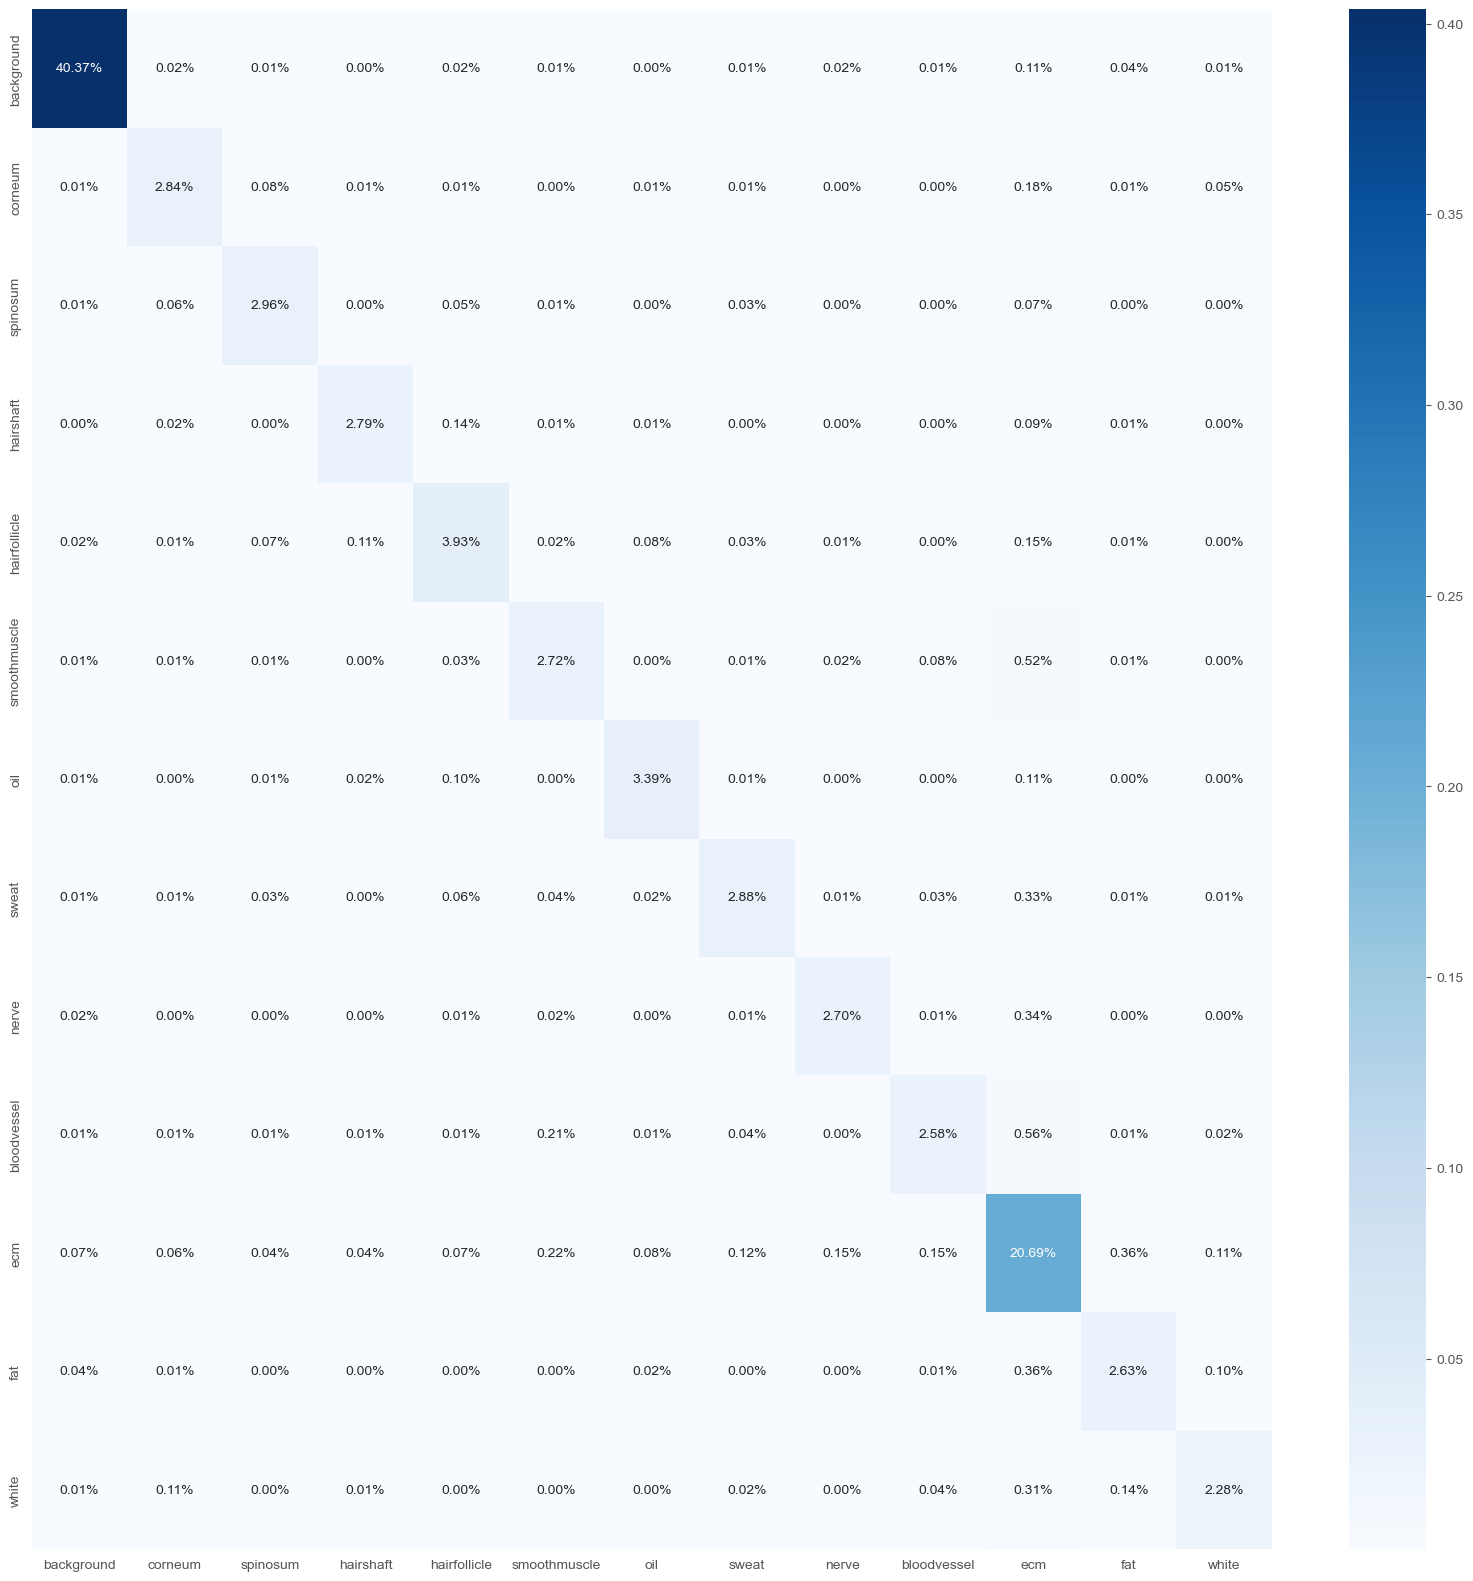

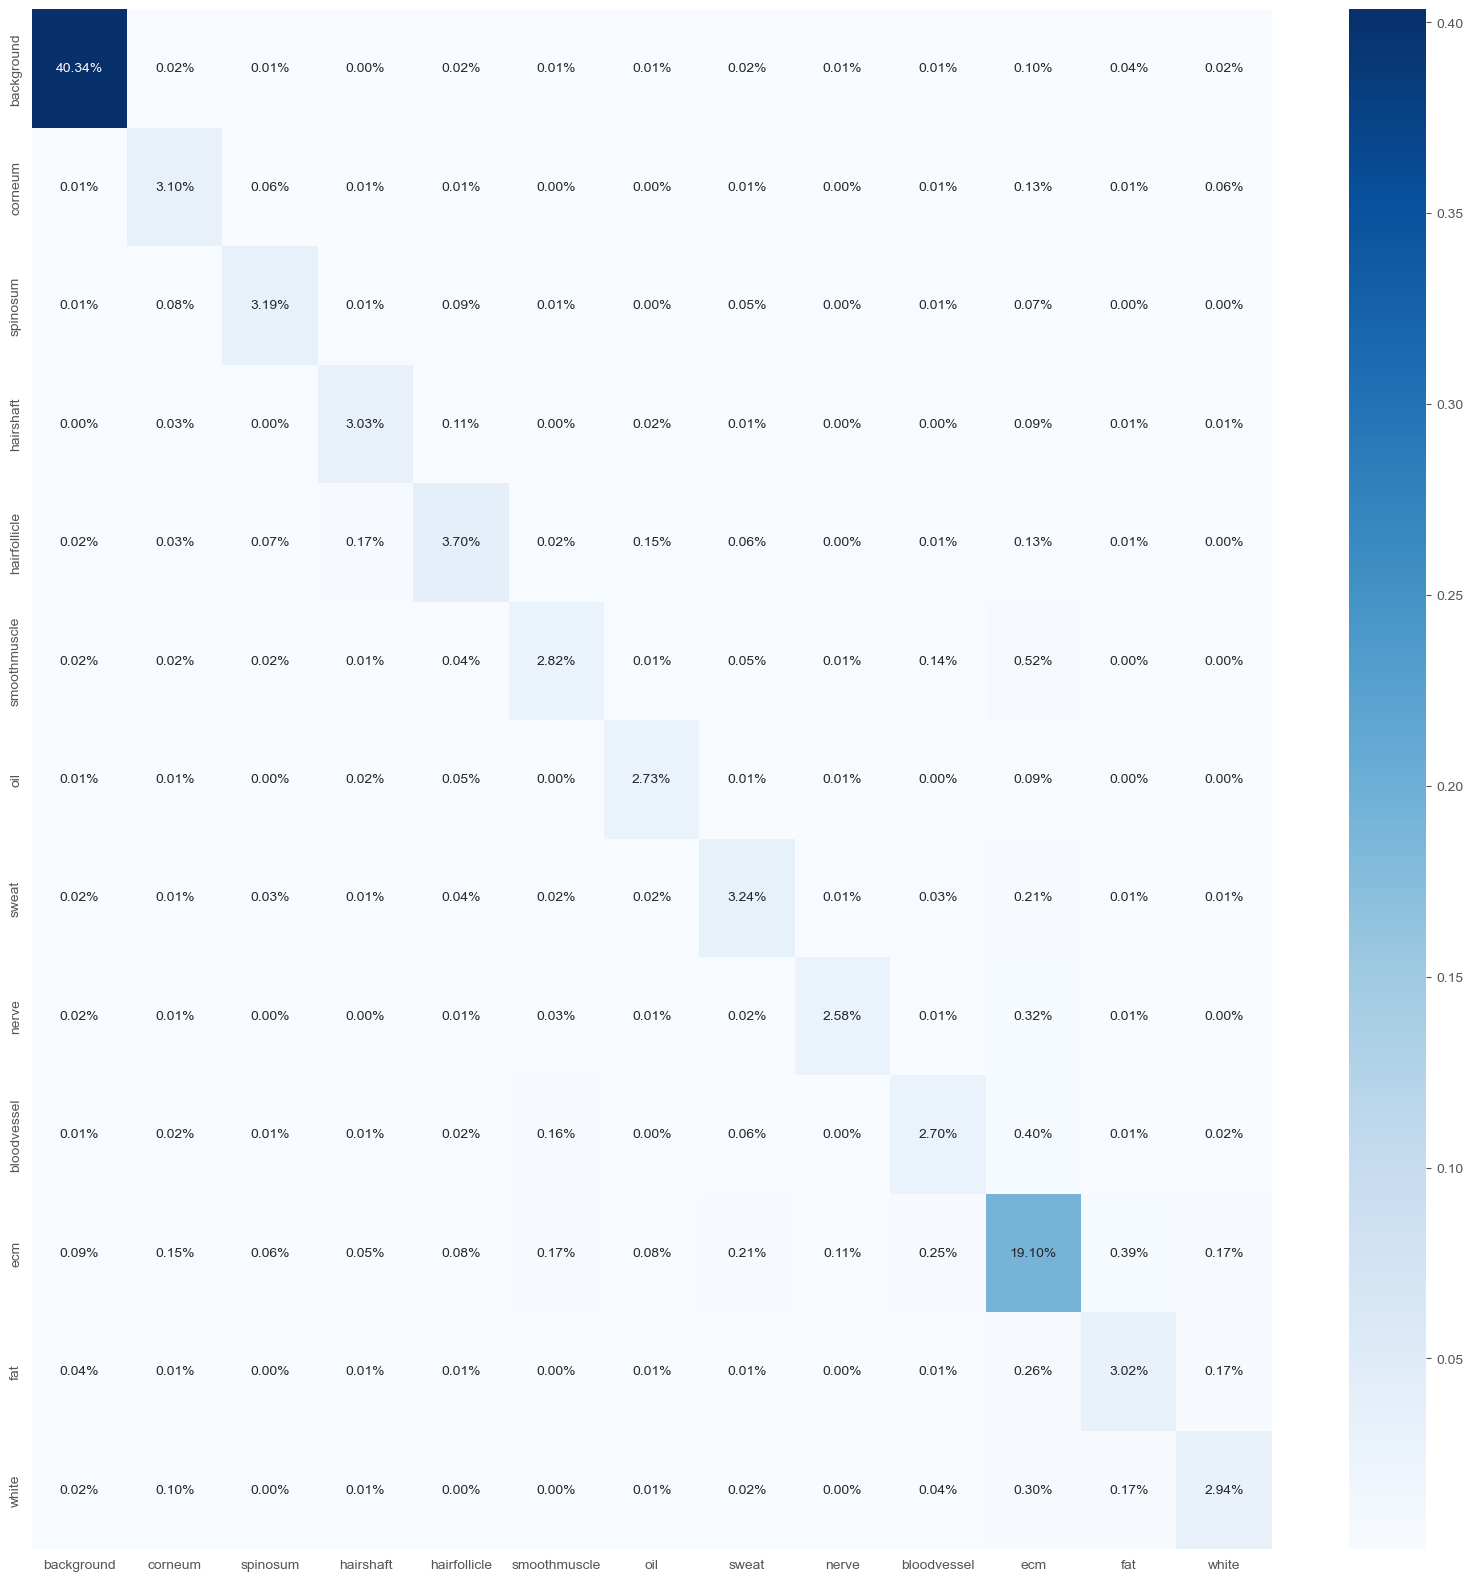

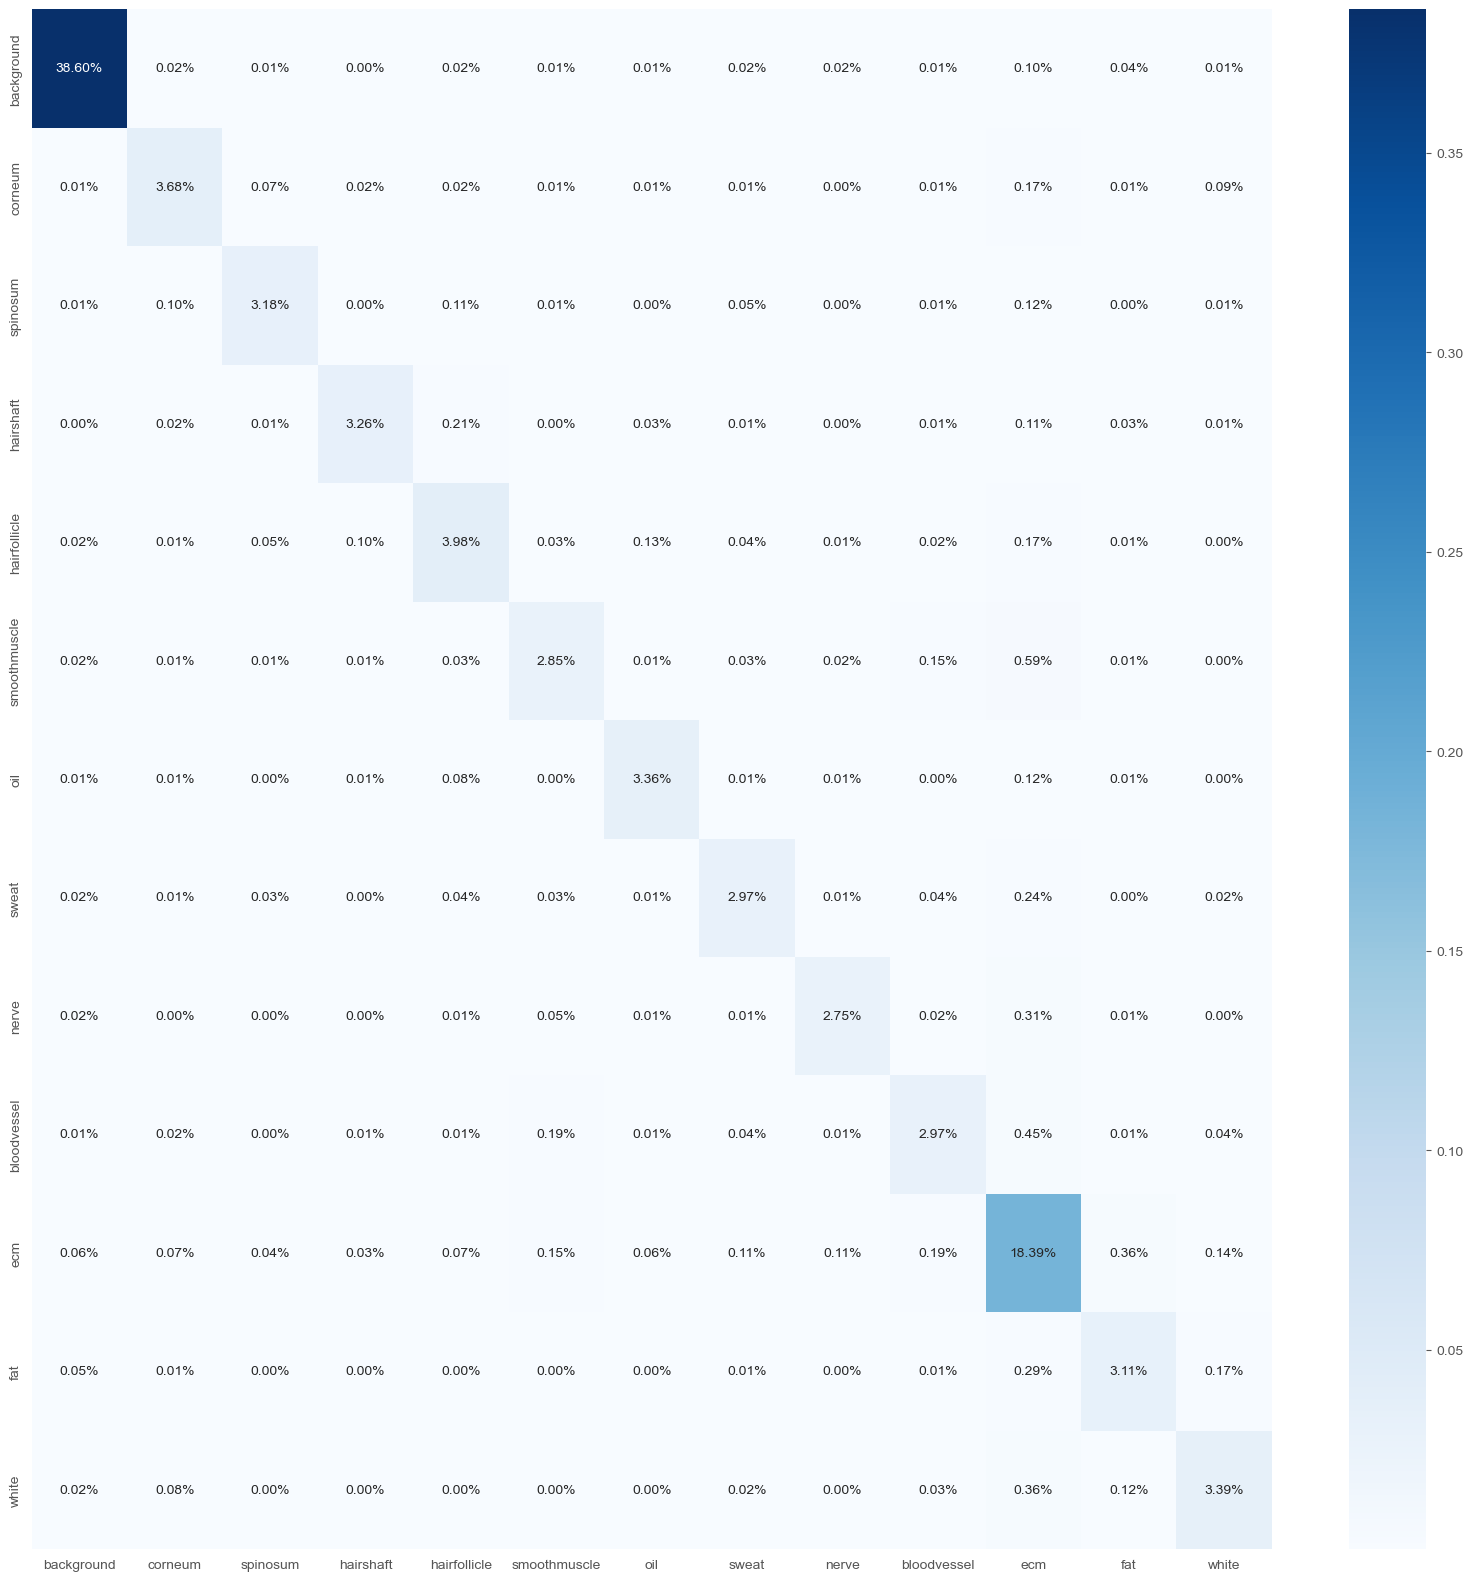

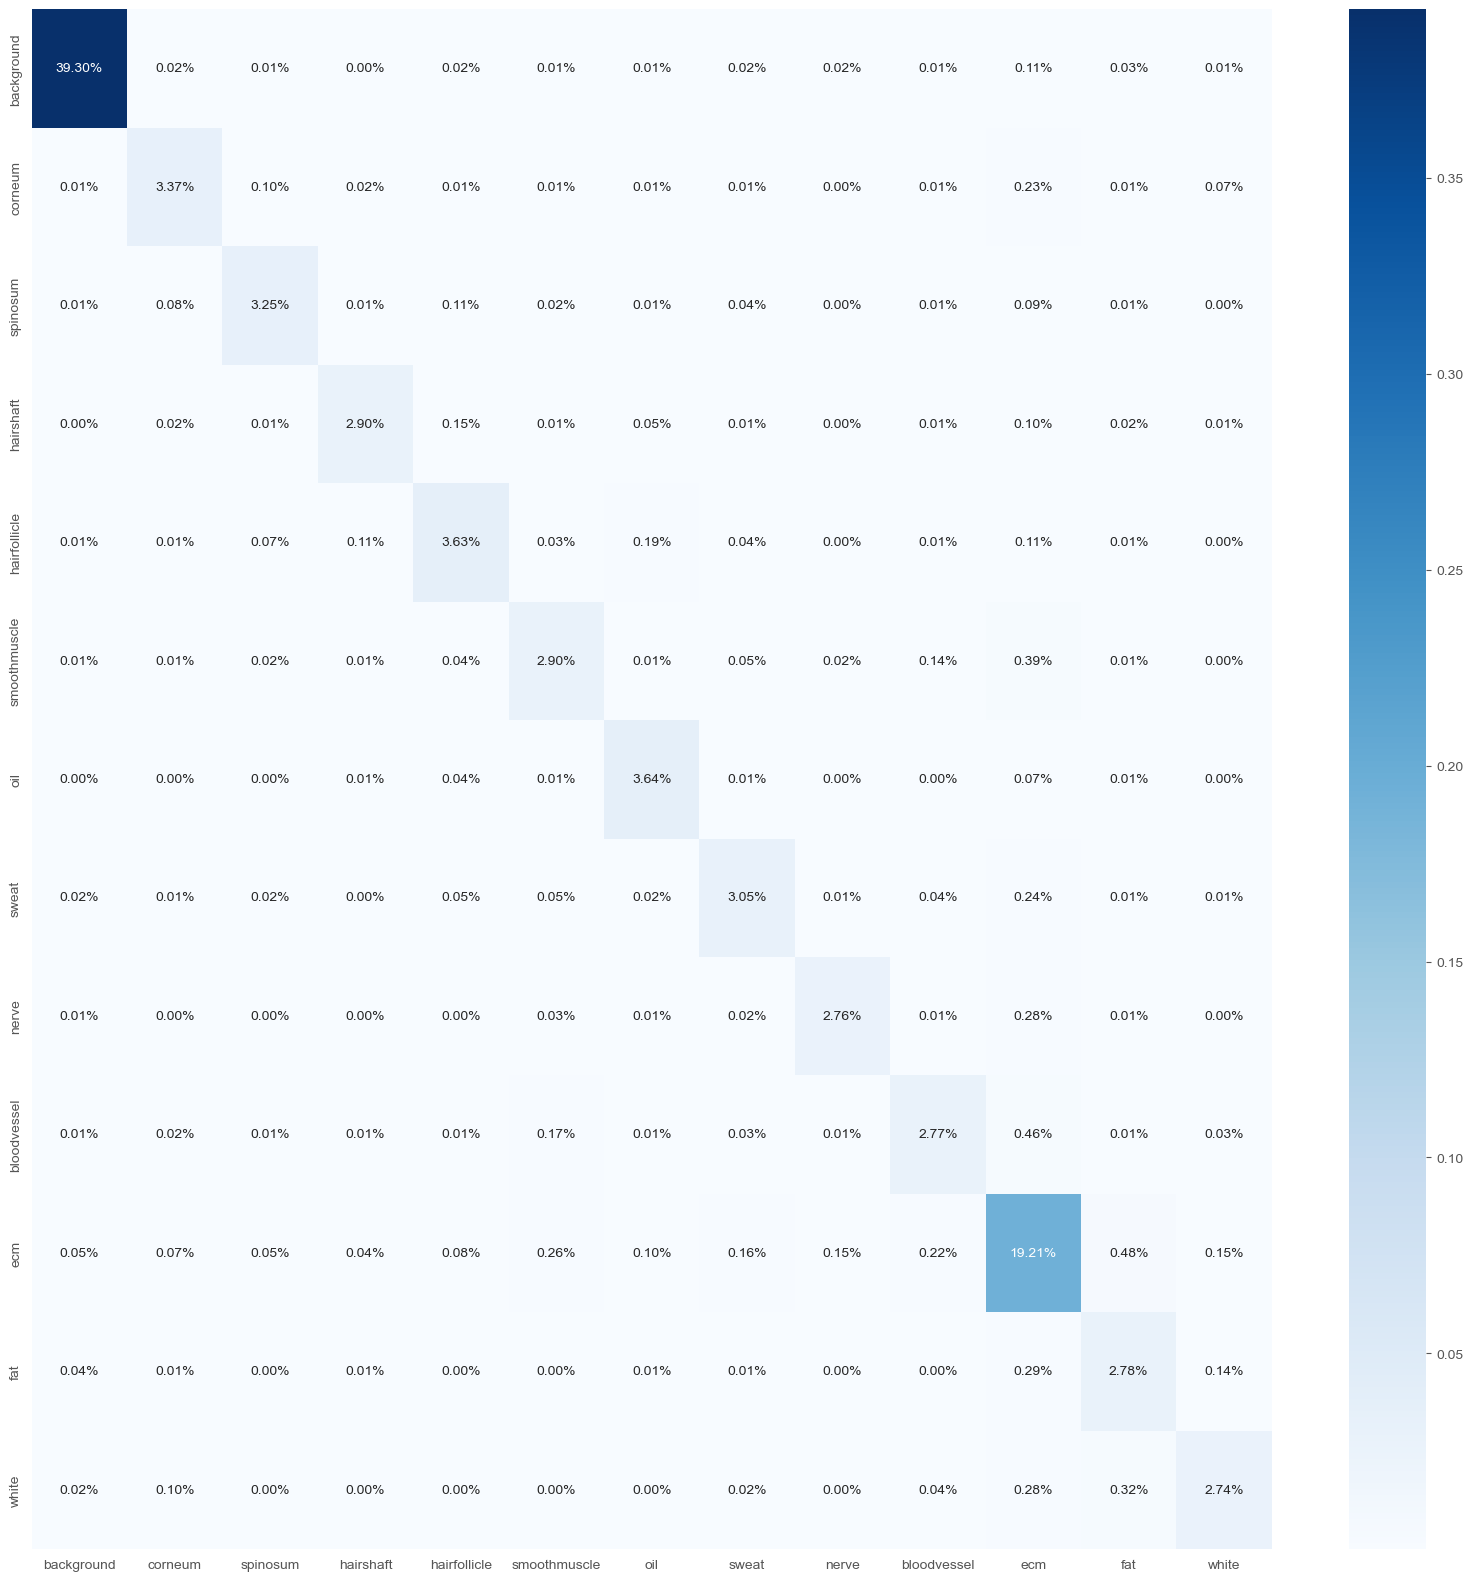

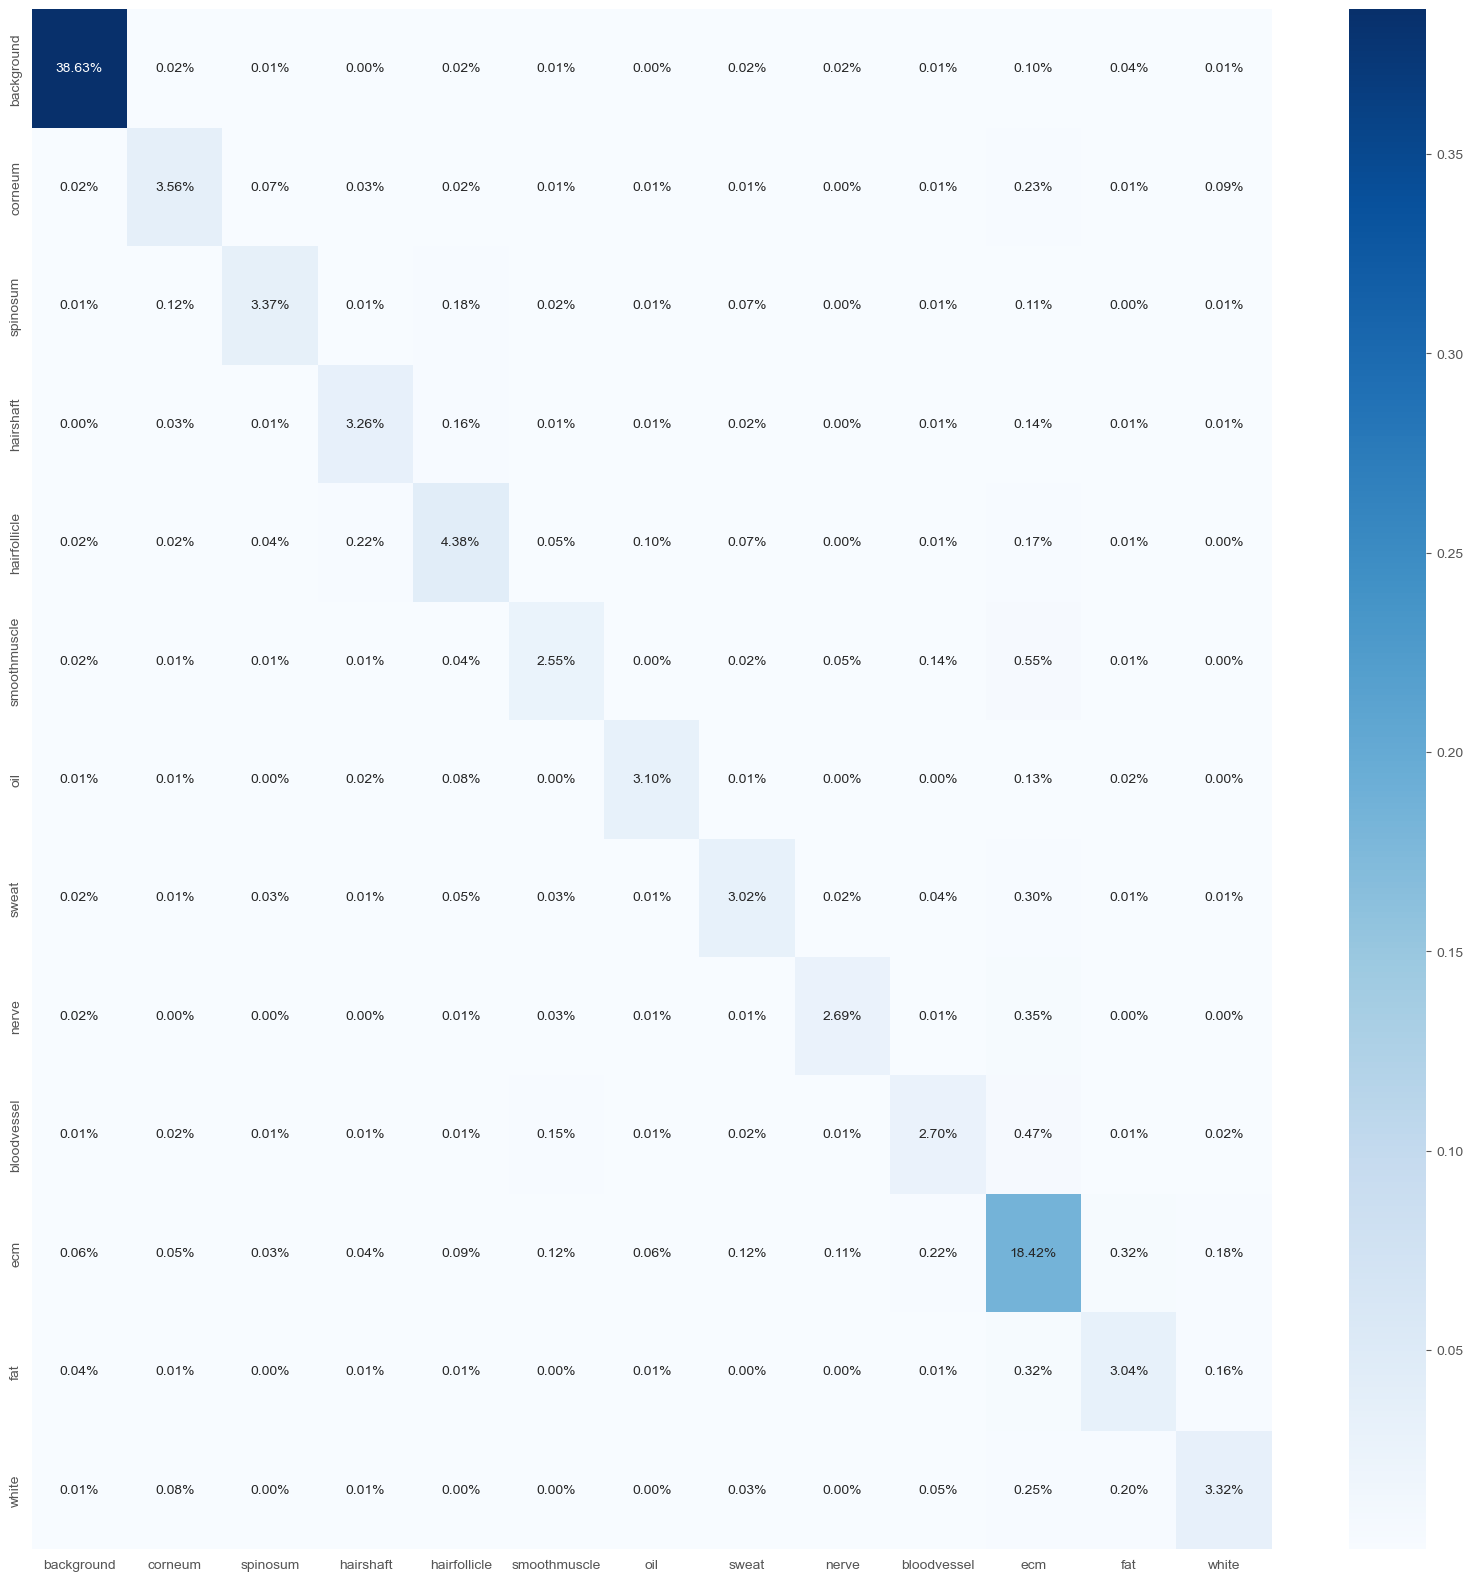

In [28]:
# finally run inference:
data_src = r"\\10.99.68.178\kyuex\image\skin_aging\deeplab_trainingset"
model_weight_dir = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet50"
start_fold = model_config.start_fold
do_TTA = False
class_list = list(['background','corneum','spinosum','hairshaft','hairfollicle','smoothmuscle','oil','sweat','nerve','bloodvessel','ecm','fat','white'])
# repeat for all number of folds:
for fold in range(0, model_config.total_fold):
    current_fold = start_fold + fold
    fold_dir = r"v11_fold{}".format(current_fold)
    image_path = os.path.join(data_src, fold_dir)
    test_dir = os.path.join(image_path, "validation")
    test_image_dir = os.path.join(test_dir, "im")
    test_label_dir = os.path.join(test_dir, 'label')
    test_images = natsorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith(".png")])
    test_labels = natsorted([os.path.join(test_label_dir, x) for x in os.listdir(test_label_dir) if x.endswith(".png")])
    test_dataloader = load_test_dataset()  # load datasets
    model = build_model()  # build model
    # print(model)
    print("Running Inference for Fold {}".format(current_fold))
    valid_f1_score, conf_matrix_total,y_true_list, y_pred_list = run_inference(model,test_dataloader,model_config.device,current_fold,do_TTA,model_weight_dir)
    print("Valid F1 Score for fold{} is : {}".format(current_fold,valid_f1_score))

    fig, ax = plt.subplots(figsize=(20,20))
    plot = sns.heatmap(conf_matrix_total/np.sum(conf_matrix_total),annot=True, fmt = '.2%', cmap = 'Blues', ax = ax, xticklabels=class_list, yticklabels=class_list)
    save_path = os.path.join(model_weight_dir,"confusion_matrix")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,"confusion_matrix_fold{}.png".format(current_fold)))
    y_true_list = [x for y in y_true_list for x in y]
    y_pred_list = [x for y in y_pred_list for x in y]
    classification_rep = classification_report(y_true_list, y_pred_list, target_names=class_list, output_dict=True)
    df = pd.DataFrame(classification_rep).transpose()
    print(df)

### Above, we see for both resnet50 and 101, without TTA performs slightly better, and surprisingly resnet50 is better than resnet101!
### Now perform inference on "real" H&E tiles w/out TTA. "Real" H&E tiles generated in /util/generate_inference_data.ipynb.

In [12]:
# finally run inference:
data_src = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\he_tiles\2022-06-14 15.39.21"
model_weight_dir = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet50"
start_fold = model_config.start_fold
do_TTA = model_config.do_TTA
class_list = list(['background','corneum','spinosum','hairshaft','hairfollicle','smoothmuscle','oil','sweat','nerve','bloodvessel','ecm','fat','white'])
# repeat for all number of folds:
for fold in range(0, model_config.total_fold):
    current_fold = start_fold + fold
    fold_dir = r"v11_fold{}".format(current_fold)
    image_path = os.path.join(data_src, fold_dir)
    test_dir = os.path.join(image_path, "validation")
    test_image_dir = os.path.join(test_dir, "im")
    test_label_dir = os.path.join(test_dir, 'label')
    test_images = natsorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith(".png")])
    test_labels = natsorted([os.path.join(test_label_dir, x) for x in os.listdir(test_label_dir) if x.endswith(".png")])
    test_dataloader = load_test_dataset()  # load datasets
    model = build_model()  # build model
    # print(model)
    print("Running Inference for Fold {}".format(current_fold))
    valid_f1_score, conf_matrix_total,y_true_list, y_pred_list = run_inference(model,test_dataloader,model_config.device,current_fold,do_TTA,model_weight_dir)
    print("Valid F1 Score for fold{} is : {}".format(current_fold,valid_f1_score))

    fig, ax = plt.subplots(figsize=(20,20))
    plot = sns.heatmap(conf_matrix_total/np.sum(conf_matrix_total),annot=True, fmt = '.2%', cmap = 'Blues', ax = ax, xticklabels=class_list, yticklabels=class_list)
    save_path = os.path.join(model_weight_dir,"confusion_matrix")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,"confusion_matrix_fold{}.png".format(current_fold)))
    y_true_list = [x for y in y_true_list for x in y]
    y_pred_list = [x for y in y_pred_list for x in y]
    classification_rep = classification_report(y_true_list, y_pred_list, target_names=class_list, output_dict=True)
    df = pd.DataFrame(classification_rep).transpose()
    print(df)

### We already saw that no TTA performs a bit better. Now, then let's try to do a individual and a 5-model ensemble inference w/out TTA on "real" H&E tiles to see if ensemble is better or not:

In [ ]:
# finally run inference:
data_src = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set"
model_weight_dir = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet50"
start_fold = model_config.start_fold
do_TTA = model_config.do_TTA
class_list = list(['background','corneum','spinosum','hairshaft','hairfollicle','smoothmuscle','oil','sweat','nerve','bloodvessel','ecm','fat','white'])
# repeat for all number of folds:
for fold in range(0, model_config.total_fold):
    current_fold = start_fold + fold
    image_path = os.path.join(data_src,"he_tiles")
    mask_path = os.path.join(data_src, "mask_tiles")
    bin_mask_path = os.path.join(data_src, "bin_mask_tiles")
    test_images = natsorted([os.path.join(image_path, x) for x in os.listdir(image_path) if x.endswith(".png")])
    test_labels = natsorted([os.path.join(mask_path, x) for x in os.listdir(mask_path) if x.endswith(".png")])
    test_bin_labels = natsorted([os.path.join(bin_mask_path, x) for x in os.listdir(bin_mask_path) if x.endswith(".png")])
    test_dataloader = load_test_dataset()  # load datasets
    model = build_model()  # build model
    # print(model)
    print("Running Inference for Fold {}".format(current_fold))
    valid_f1_score, conf_matrix_total,y_true_list, y_pred_list = run_inference(model,test_dataloader,model_config.device,current_fold,do_TTA,model_weight_dir)
    print("Valid F1 Score for fold{} is : {}".format(current_fold,valid_f1_score))

    fig, ax = plt.subplots(figsize=(20,20))
    plot = sns.heatmap(conf_matrix_total/np.sum(conf_matrix_total),annot=True, fmt = '.2%', cmap = 'Blues', ax = ax, xticklabels=class_list, yticklabels=class_list)
    save_path = os.path.join(model_weight_dir,"confusion_matrix")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,"confusion_matrix_fold{}.png".format(current_fold)))
    y_true_list = [x for y in y_true_list for x in y]
    y_pred_list = [x for y in y_pred_list for x in y]
    classification_rep = classification_report(y_true_list, y_pred_list, target_names=class_list, output_dict=True)
    df = pd.DataFrame(classification_rep).transpose()
    print(df)

In [ ]:
test_transforms = A.Compose([ToTensorV2()])  #just convert to tensor


class TestDataSet(Dataset):
    # initialize df, label, imagepath, transforms:
    def __init__(self, image_paths: list, mask_paths: list, transforms=None, label=True):
        self.label = label
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    # define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        if self.label:
            mask_path = self.mask_paths[idx]
            mask = cv2.imread(mask_path, 0)
            mask = np.array(mask)
            mask[mask == 13] = 0
        if self.transforms is not None:  # albumentations
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.unsqueeze(0)  # dtypes: image = torch.uin8, mask = torch.uint8
        return image, mask  # return tensors of equal dtype and size
        # image is size 3x1024x1024 and mask is size 1x1024x1024 (need dummy dimension to match dimension)


# define dataloading function to use above dataset to return train and val dataloaders:
def load_test_dataset():
    test_dataset = TestDataSet(image_paths=test_images, mask_paths=test_labels, transforms=test_transforms)
    test_dataloader = DataLoader(dataset=test_dataset,
                                 batch_size=model_config.test_batch_size,
                                 num_workers=0, pin_memory=True, shuffle=False)
    return test_dataloader  # return train and val dataloaders


# Define test image and test label paths:
data_src = r"\\10.99.68.178\kyuex\image\skin_aging\deeplab_trainingset"
fold_dir = r"v11_fold{}".format(model_config.start_fold)
image_path = os.path.join(data_src, fold_dir)
test_dir = os.path.join(image_path, "validation")
test_image_dir = os.path.join(test_dir, "im")
test_label_dir = os.path.join(test_dir, 'label')
test_images = natsorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith(".png")])
test_labels = natsorted([os.path.join(test_label_dir, x) for x in os.listdir(test_label_dir) if x.endswith(".png")])
test_dataloader = load_test_dataset()  # load datasets
# test to see if dataloaders return desired batch size and visualize images to see if images are indeed transformed:
test_dataloader = load_test_dataset()
images, labels = next(iter(test_dataloader))
print("Images have a tensor size of {}, and Labels have a tensor size of {}".
      format(images.size(), labels.size()))


def build_model():
    model = smp.DeepLabV3Plus(encoder_name=model_config.model_name, encoder_weights=None, encoder_depth=5,
                              decoder_channels=512, activation=None,
                              in_channels=3, classes=13)
    model.to(model_config.device)  # move model to gpu
    return model


def perform_TTA(x: torch.Tensor, model):
    shape = x.shape  #must be BCHW
    x = [x, *[torch.rot90(x, k=i, dims=(-2, -1)) for i in range(1, 4)]]
    x = torch.cat(x, dim=0)
    x = model(x)
    x = x.reshape(4, shape[0], 13,
                  *shape[-2:])  # 4 = three different rotations + original image, 13 = # of classes (y_pred)
    x = [torch.rot90(x[i], k=-i, dims=(-2, -1)) for i in range(4)]
    x = torch.stack(x, dim=0)
    return x.mean(0)


def calculate_f1_score_conf_matrix(y_pred: torch.Tensor, y_true: torch.Tensor):  # y_pred in probabilities
    y_pred = y_pred.cpu().numpy().flatten()  # 1d numpy array
    y_true = y_true.cpu().numpy().flatten()  # 1d numpy array
    f1_score_result = f1_score(y_pred, y_true, average="weighted")
    conf_matrix = confusion_matrix(y_true, y_pred)

    return f1_score_result, conf_matrix


@torch.no_grad()  #decorator to disable gradient calc
def run_inference(model, dataloader, device, fold, TTA: bool, weight_dir):
    valid_f1_history, y_true_list, y_pred_list = [], [], []
    conf_matrix_total = np.zeros((13, 13), dtype=int)
    model_path = os.path.join(weight_dir, "best_epoch-0{}.pt".format(fold))
    model.load_state_dict(torch.load(model_path))  #load model weights
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Inference', colour='red')
    for idx, (images, masks) in pbar:
        model.eval()  # eval stage
        images = images.to(device, dtype=torch.float)  #move tensor to gpu
        masks = masks.to(device, dtype=torch.int64)  #move tensor to gpu
        if TTA:
            prediction = perform_TTA(images, model)
        else:
            prediction = model(images)
        masks = masks.squeeze(1)  # N x 1024 x 1024
        y_pred = torch.argmax(prediction,
                              dim=1)  # get most likely class by applying argmax to logit y_pred (same as applying sigmoid), N x 13 x 1024 x 1024 -> N x 1 x 1024 x 1024
        y_pred = y_pred.squeeze(1)  # N x 1024 x 1024
        # get 13 x 13 conf matrix
        valid_f1, conf_matrix = calculate_f1_score_conf_matrix(y_pred, masks)  # find f1 score
        y_true_list.append(masks.cpu().numpy().flatten())
        y_pred_list.append(y_pred.cpu().numpy().flatten())
        valid_f1_history.append(valid_f1)
        conf_matrix_total += conf_matrix
    valid_f1_history = np.mean(valid_f1_history,
                               axis=0)
    return valid_f1_history, conf_matrix_total, y_true_list, y_pred_list

### Now, let's try to see which features the model pays attention to. Below is code to visualize the feature maps of DeepLabv3+ model on the synthesized tiles:


In [ ]:
# visualize each image after a convolutoinal layer?

### Below is code to visualize the feature maps of DeepLabv3+ model on the "real" H&E tiles: